Task 1 : Decimal representation reverse

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import random
import matplotlib.pyplot as plt
import time

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3603681457136145282
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4828102656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9267261220120143630
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:26:00.0, compute capability: 7.5"
]


Task 1 : Decimal representation model reversed

In [2]:
from __future__ import print_function
#import tensorflow as tf
#from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
from six.moves import range

class CharacterTable(object):
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    def __init__(self, chars):
        """Initialize character table.

        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.

        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.

        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))
        
questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = ' ' + str1
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

x_val = np.zeros((len(questions1), MAXLEN, len(chars)), dtype=np.bool)
y_val = np.zeros((len(questions1), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions1):
    x_val[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected1):
    y_val[i] = ctable.encode(sentence, DIGITS + 1)
    
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn
RNN = layers.SimpleRNN
model_rnn = Sequential()

model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_rnn.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_rnn.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()


#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_gru.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    # the first dimension to be the timesteps.
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_gru.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(1000000, 7, 12)
(1000000, 4, 12)
Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_______________________________________________

Task 1 : Training Decimal representation reversed LSTM

In [3]:
val_acc_LSTM_digit_True = []
val_mae_LSTM_digit_True = []
val_mse_LSTM_digit_True = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_digit_True.append(model.history.history["val_accuracy"])
    val_mae_LSTM_digit_True.append(model.history.history["val_mae"])
    val_mse_LSTM_digit_True.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_true = (t1-t0)/200
print(timeperiteration_lstm_true)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 34s 761us/sample - loss: 1.8799 - accuracy: 0.3231 - mae: 0.1221 - mse: 0.0608 - val_loss: 1.8862 - val_accuracy: 0.3202 - val_mae: 0.1242 - val_mse: 0.0618
Q 86+575  T 661  ☒ 109 
Q 920+273 T 1193 ☒ 1019
Q 411+421 T 832  ☒ 111 
Q 568+133 T 701  ☒ 101 
Q 674+704 T 1378 ☒ 111 
Q 865+321 T 1186 ☒ 101 
Q 778+800 T 1578 ☒ 1119
Q 534+848 T 1382 ☒ 114 
Q 519+485 T 1004 ☒ 111 
Q 36+414  T 450  ☒ 111 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 605us/sample - loss: 1.7216 - accuracy: 0.3625 - mae: 0.1146 - mse: 0.0569 - val_loss: 1.7114 - val_accuracy: 0.3611 - val_mae: 0.1161 - val_mse: 0.0569
Q 328+550 T 878  ☒ 107 
Q 391+342 T 733  ☒ 107 
Q 312+982 T 1294 ☒ 1207
Q 704+207 T 911  ☒ 107 
Q 163+166 T 329  ☒ 777 


Q 415+435 T 850  ☒ 860 
Q 959+83  T 1042 ☑ 1042
Q 69+69   T 138  ☒ 137 
Q 466+154 T 620  ☑ 620 
Q 92+190  T 282  ☑ 282 

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 605us/sample - loss: 0.2621 - accuracy: 0.9377 - mae: 0.0317 - mse: 0.0107 - val_loss: 0.3081 - val_accuracy: 0.9244 - val_mae: 0.0369 - val_mse: 0.0128
Q 262+819 T 1081 ☑ 1081
Q 205+609 T 814  ☒ 823 
Q 698+599 T 1297 ☒ 1288
Q 418+98  T 516  ☑ 516 
Q 345+750 T 1095 ☑ 1095
Q 946+240 T 1186 ☑ 1186
Q 145+612 T 757  ☑ 757 
Q 847+630 T 1477 ☑ 1477
Q 453+116 T 569  ☑ 569 
Q 210+985 T 1195 ☑ 1195

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 609us/sample - loss: 0.2207 - accuracy: 0.9481 - mae: 0.0272 - mse: 0.0089 - val_loss: 0.3338 - val_accuracy: 0.8941 - val_mae: 0.0381 - val_mse: 0.014

Q 94+160  T 254  ☑ 254 
Q 215+573 T 788  ☑ 788 
Q 539+569 T 1108 ☑ 1108
Q 815+647 T 1462 ☑ 1462

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.0122 - accuracy: 0.9984 - mae: 0.0018 - mse: 3.1520e-04 - val_loss: 0.0162 - val_accuracy: 0.9974 - val_mae: 0.0022 - val_mse: 4.3714e-04
Q 59+423  T 482  ☑ 482 
Q 80+44   T 124  ☑ 124 
Q 372+579 T 951  ☑ 951 
Q 815+829 T 1644 ☑ 1644
Q 655+461 T 1116 ☑ 1116
Q 812+321 T 1133 ☑ 1133
Q 547+337 T 884  ☑ 884 
Q 250+555 T 805  ☑ 805 
Q 751+298 T 1049 ☑ 1049
Q 9+711   T 720  ☑ 720 

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 605us/sample - loss: 0.0098 - accuracy: 0.9989 - mae: 0.0014 - mse: 2.2880e-04 - val_loss: 0.0165 - val_accuracy: 0.9970 - val_mae: 0.0022 - val_mse: 4.7005e-04
Q 536+

Q 80+407  T 487  ☑ 487 
Q 943+439 T 1382 ☑ 1382
Q 726+315 T 1041 ☑ 1041
Q 590+961 T 1551 ☑ 1551
Q 957+814 T 1771 ☑ 1771

--------------------------------------------------
Iteration 64
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0051 - accuracy: 0.9994 - mae: 7.4049e-04 - mse: 1.1669e-04 - val_loss: 0.0085 - val_accuracy: 0.9983 - val_mae: 0.0011 - val_mse: 2.5031e-04
Q 709+371 T 1080 ☑ 1080
Q 608+995 T 1603 ☑ 1603
Q 556+506 T 1062 ☑ 1062
Q 457+607 T 1064 ☑ 1064
Q 758+612 T 1370 ☑ 1370
Q 208+417 T 625  ☑ 625 
Q 777+145 T 922  ☑ 922 
Q 572+168 T 740  ☑ 740 
Q 587+296 T 883  ☑ 883 
Q 940+100 T 1040 ☑ 1040

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0035 - accuracy: 0.9996 - mae: 5.2400e-04 - mse: 6.9070e-05 - val_loss: 0.0064 - val_accuracy: 0.9988 - val_mae: 8.2

45000/45000 [==============================] - 29s 636us/sample - loss: 0.0498 - accuracy: 0.9868 - mae: 0.0033 - mse: 0.0018 - val_loss: 0.0119 - val_accuracy: 0.9976 - val_mae: 0.0015 - val_mse: 3.6181e-04
Q 644+202 T 846  ☑ 846 
Q 787+172 T 959  ☑ 959 
Q 769+223 T 992  ☑ 992 
Q 185+322 T 507  ☑ 507 
Q 192+340 T 532  ☑ 532 
Q 430+529 T 959  ☑ 959 
Q 76+603  T 679  ☑ 679 
Q 637+271 T 908  ☑ 908 
Q 322+885 T 1207 ☑ 1207
Q 845+681 T 1526 ☑ 1526

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 29s 651us/sample - loss: 0.0031 - accuracy: 0.9998 - mae: 4.7625e-04 - mse: 4.3726e-05 - val_loss: 0.0062 - val_accuracy: 0.9989 - val_mae: 8.1358e-04 - val_mse: 1.6445e-04
Q 160+730 T 890  ☑ 890 
Q 405+315 T 720  ☑ 720 
Q 179+767 T 946  ☑ 946 
Q 462+777 T 1239 ☑ 1239
Q 903+114 T 1017 ☒ 1007
Q 26+911  T 937  ☑ 937 
Q 984+404 T 1388 ☑ 1388
Q 915+562 T 1477 ☑ 1477
Q 708+492 T 1200 ☑ 1200

Q 881+729 T 1610 ☑ 1610
Q 83+157  T 240  ☑ 240 
Q 222+829 T 1051 ☑ 1051
Q 116+588 T 704  ☑ 704 
Q 555+365 T 920  ☑ 920 

--------------------------------------------------
Iteration 89
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0018 - accuracy: 0.9999 - mae: 2.8041e-04 - mse: 2.2926e-05 - val_loss: 0.0048 - val_accuracy: 0.9991 - val_mae: 5.9036e-04 - val_mse: 1.3180e-04
Q 46+835  T 881  ☑ 881 
Q 935+184 T 1119 ☑ 1119
Q 340+186 T 526  ☑ 526 
Q 74+850  T 924  ☑ 924 
Q 334+330 T 664  ☑ 664 
Q 270+713 T 983  ☑ 983 
Q 628+740 T 1368 ☑ 1368
Q 105+62  T 167  ☑ 167 
Q 70+410  T 480  ☑ 480 
Q 370+864 T 1234 ☑ 1234

--------------------------------------------------
Iteration 90
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0018 - accuracy: 0.9998 - mae: 2.7122e-04 - mse: 3.1711e-05 - val_loss: 0.0047 - val_accuracy: 0.9991 - val_mae:

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 614us/sample - loss: 0.0016 - accuracy: 0.9999 - mae: 2.5451e-04 - mse: 1.7676e-05 - val_loss: 0.0044 - val_accuracy: 0.9991 - val_mae: 5.4395e-04 - val_mse: 1.2525e-04
Q 442+140 T 582  ☑ 582 
Q 67+793  T 860  ☑ 860 
Q 716+779 T 1495 ☑ 1495
Q 303+110 T 413  ☑ 413 
Q 411+735 T 1146 ☑ 1146
Q 672+479 T 1151 ☑ 1151
Q 9+134   T 143  ☑ 143 
Q 222+667 T 889  ☑ 889 
Q 331+731 T 1062 ☑ 1062
Q 317+45  T 362  ☑ 362 

--------------------------------------------------
Iteration 102
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 607us/sample - loss: 0.0013 - accuracy: 0.9999 - mae: 2.0848e-04 - mse: 1.6782e-05 - val_loss: 0.0039 - val_accuracy: 0.9992 - val_mae: 4.7725e-04 - val_mse: 1.1086e-04
Q 939+729 T 1668 ☑ 1668
Q 361+190 T 551  ☑ 551 
Q 777+849 T 1626 ☑ 1626
Q 542+549 T 1091 ☑ 1091
Q 156+392 T 548  ☑ 548 
Q 860+274 T 1134 ☑ 1134
Q 916+

Q 549+905 T 1454 ☑ 1454
Q 653+430 T 1083 ☑ 1083
Q 864+859 T 1723 ☑ 1723
Q 918+929 T 1847 ☑ 1847
Q 62+34   T 96   ☑ 96  
Q 550+164 T 714  ☑ 714 
Q 769+652 T 1421 ☑ 1421
Q 500+849 T 1349 ☑ 1349
Q 376+784 T 1160 ☑ 1160
Q 101+598 T 699  ☑ 699 

--------------------------------------------------
Iteration 114
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 606us/sample - loss: 0.0011 - accuracy: 0.9999 - mae: 1.7268e-04 - mse: 1.1777e-05 - val_loss: 0.0039 - val_accuracy: 0.9992 - val_mae: 4.5857e-04 - val_mse: 1.1313e-04
Q 504+897 T 1401 ☑ 1401
Q 607+715 T 1322 ☑ 1322
Q 311+956 T 1267 ☑ 1267
Q 932+679 T 1611 ☑ 1611
Q 947+533 T 1480 ☑ 1480
Q 568+965 T 1533 ☑ 1533
Q 923+238 T 1161 ☑ 1161
Q 103+178 T 281  ☑ 281 
Q 246+720 T 966  ☑ 966 
Q 430+769 T 1199 ☑ 1199

--------------------------------------------------
Iteration 115
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample 

Q 966+946 T 1912 ☑ 1912
Q 857+680 T 1537 ☑ 1537
Q 807+922 T 1729 ☑ 1729
Q 922+779 T 1701 ☑ 1701

--------------------------------------------------
Iteration 126
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 8.4574e-04 - accuracy: 0.9999 - mae: 1.3233e-04 - mse: 9.6976e-06 - val_loss: 0.0027 - val_accuracy: 0.9995 - val_mae: 3.2293e-04 - val_mse: 7.3537e-05
Q 193+815 T 1008 ☑ 1008
Q 341+164 T 505  ☑ 505 
Q 740+551 T 1291 ☑ 1291
Q 508+882 T 1390 ☑ 1390
Q 140+104 T 244  ☑ 244 
Q 909+987 T 1896 ☑ 1896
Q 827+522 T 1349 ☑ 1349
Q 883+224 T 1107 ☑ 1107
Q 197+324 T 521  ☑ 521 
Q 943+37  T 980  ☑ 980 

--------------------------------------------------
Iteration 127
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.0011 - accuracy: 0.9998 - mae: 1.5631e-04 - mse: 2.6287e-05 - val_loss: 0.0035 - val_accuracy: 0.9992 - val_mae: 3.8813e-04 - val_

45000/45000 [==============================] - 27s 596us/sample - loss: 7.6515e-04 - accuracy: 1.0000 - mae: 1.1914e-04 - mse: 8.3580e-06 - val_loss: 0.0031 - val_accuracy: 0.9993 - val_mae: 3.5333e-04 - val_mse: 9.1696e-05
Q 258+307 T 565  ☑ 565 
Q 950+850 T 1800 ☑ 1800
Q 810+593 T 1403 ☑ 1403
Q 193+67  T 260  ☑ 260 
Q 271+524 T 795  ☑ 795 
Q 236+790 T 1026 ☑ 1026
Q 752+686 T 1438 ☑ 1438
Q 207+252 T 459  ☑ 459 
Q 260+505 T 765  ☑ 765 
Q 71+530  T 601  ☑ 601 

--------------------------------------------------
Iteration 139
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 8.7660e-04 - accuracy: 0.9999 - mae: 1.2789e-04 - mse: 1.6302e-05 - val_loss: 0.0030 - val_accuracy: 0.9993 - val_mae: 3.3207e-04 - val_mse: 9.0462e-05
Q 736+372 T 1108 ☑ 1108
Q 25+940  T 965  ☑ 965 
Q 941+134 T 1075 ☑ 1075
Q 223+818 T 1041 ☑ 1041
Q 993+486 T 1479 ☑ 1479
Q 618+675 T 1293 ☑ 1293
Q 65+573  T 638  ☑ 638 
Q 528+925 T 1453 ☑ 1453
Q 

Q 612+863 T 1475 ☑ 1475
Q 856+349 T 1205 ☑ 1205
Q 966+960 T 1926 ☑ 1926
Q 248+688 T 936  ☑ 936 
Q 112+547 T 659  ☑ 659 
Q 180+479 T 659  ☑ 659 
Q 821+164 T 985  ☑ 985 
Q 751+350 T 1101 ☑ 1101
Q 112+501 T 613  ☑ 613 
Q 959+914 T 1873 ☑ 1873

--------------------------------------------------
Iteration 151
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 616us/sample - loss: 6.2159e-04 - accuracy: 1.0000 - mae: 1.0066e-04 - mse: 3.6765e-06 - val_loss: 0.0027 - val_accuracy: 0.9994 - val_mae: 3.1407e-04 - val_mse: 8.0001e-05
Q 563+398 T 961  ☑ 961 
Q 944+760 T 1704 ☑ 1704
Q 757+619 T 1376 ☑ 1376
Q 267+295 T 562  ☑ 562 
Q 645+214 T 859  ☑ 859 
Q 998+209 T 1207 ☑ 1207
Q 137+212 T 349  ☑ 349 
Q 22+232  T 254  ☑ 254 
Q 455+649 T 1104 ☑ 1104
Q 808+111 T 919  ☑ 919 

--------------------------------------------------
Iteration 152
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 628us/sam

Q 711+417 T 1128 ☑ 1128
Q 221+46  T 267  ☑ 267 
Q 685+431 T 1116 ☑ 1116
Q 785+296 T 1081 ☑ 1081
Q 690+260 T 950  ☑ 950 

--------------------------------------------------
Iteration 163
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0204 - accuracy: 0.9940 - mae: 0.0013 - mse: 7.9603e-04 - val_loss: 0.0695 - val_accuracy: 0.9783 - val_mae: 0.0051 - val_mse: 0.0028
Q 382+446 T 828  ☑ 828 
Q 593+28  T 621  ☑ 621 
Q 135+635 T 770  ☑ 770 
Q 423+54  T 477  ☑ 477 
Q 982+997 T 1979 ☒ 1989
Q 835+383 T 1218 ☑ 1218
Q 49+588  T 637  ☑ 637 
Q 8+604   T 612  ☑ 612 
Q 179+781 T 960  ☑ 960 
Q 858+189 T 1047 ☒ 1048

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0105 - accuracy: 0.9972 - mae: 8.8504e-04 - mse: 3.7960e-04 - val_loss: 0.0063 - val_accuracy: 0.9983 - val_mae: 6.7923e-0

45000/45000 [==============================] - 27s 607us/sample - loss: 4.4382e-04 - accuracy: 1.0000 - mae: 7.2175e-05 - mse: 2.1330e-06 - val_loss: 0.0028 - val_accuracy: 0.9994 - val_mae: 2.9586e-04 - val_mse: 8.5386e-05
Q 259+5   T 264  ☑ 264 
Q 895+70  T 965  ☑ 965 
Q 231+992 T 1223 ☑ 1223
Q 411+629 T 1040 ☑ 1040
Q 163+700 T 863  ☑ 863 
Q 627+276 T 903  ☑ 903 
Q 544+284 T 828  ☑ 828 
Q 207+60  T 267  ☑ 267 
Q 6+210   T 216  ☑ 216 
Q 303+665 T 968  ☑ 968 

--------------------------------------------------
Iteration 176
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 4.0095e-04 - accuracy: 1.0000 - mae: 6.5091e-05 - mse: 2.1031e-06 - val_loss: 0.0025 - val_accuracy: 0.9994 - val_mae: 2.7130e-04 - val_mse: 8.0032e-05
Q 261+992 T 1253 ☑ 1253
Q 702+14  T 716  ☑ 716 
Q 373+758 T 1131 ☑ 1131
Q 3+44    T 47   ☑ 47  
Q 979+762 T 1741 ☑ 1741
Q 136+185 T 321  ☑ 321 
Q 668+995 T 1663 ☑ 1663
Q 354+890 T 1244 ☑ 1244
Q 

Q 54+591  T 645  ☑ 645 
Q 880+888 T 1768 ☑ 1768
Q 193+146 T 339  ☑ 339 
Q 822+84  T 906  ☑ 906 
Q 415+913 T 1328 ☑ 1328
Q 436+752 T 1188 ☑ 1188
Q 681+959 T 1640 ☑ 1640
Q 289+227 T 516  ☑ 516 
Q 852+548 T 1400 ☑ 1400
Q 416+421 T 837  ☑ 837 

--------------------------------------------------
Iteration 188
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 4.6819e-04 - accuracy: 1.0000 - mae: 7.6713e-05 - mse: 1.8204e-06 - val_loss: 0.0026 - val_accuracy: 0.9994 - val_mae: 2.8642e-04 - val_mse: 8.0706e-05
Q 544+480 T 1024 ☑ 1024
Q 711+696 T 1407 ☑ 1407
Q 724+370 T 1094 ☑ 1094
Q 686+833 T 1519 ☑ 1519
Q 468+658 T 1126 ☑ 1126
Q 351+249 T 600  ☑ 600 
Q 868+45  T 913  ☑ 913 
Q 869+124 T 993  ☑ 993 
Q 183+181 T 364  ☑ 364 
Q 248+148 T 396  ☑ 396 

--------------------------------------------------
Iteration 189
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sam

Q 580+748 T 1328 ☑ 1328
Q 394+322 T 716  ☑ 716 
Q 932+506 T 1438 ☑ 1438
Q 851+677 T 1528 ☑ 1528
Q 288+149 T 437  ☑ 437 
27.7125072658062


Task 1 : Training Decimal representation reversed simplernn

In [18]:
val_acc_simplernn_digit_True = []
val_mae_simplernn_digit_True = []
val_mse_simplernn_digit_True = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_digit_True.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_digit_True.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_digit_True.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_true = (t1-t0)/200
print(timeperiteration_simplernn_true)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 29s 644us/sample - loss: 1.6863 - accuracy: 0.3874 - mae: 0.1131 - mse: 0.0559 - val_loss: 1.7245 - val_accuracy: 0.3623 - val_mae: 0.1160 - val_mse: 0.0575
Q 59+888  T 947  ☒ 900 
Q 627+904 T 1531 ☒ 1577
Q 405+664 T 1069 ☒ 1055
Q 433+99  T 532  ☒ 422 
Q 67+645  T 712  ☒ 777 
Q 124+888 T 1012 ☒ 104 
Q 840+74  T 914  ☒ 801 
Q 889+217 T 1106 ☒ 104 
Q 87+915  T 1002 ☒ 903 
Q 685+23  T 708  ☒ 670 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 1.4794 - accuracy: 0.4518 - mae: 0.1040 - mse: 0.0511 - val_loss: 1.5546 - val_accuracy: 0.4105 - val_mae: 0.1101 - val_mse: 0.0541
Q 24+662  T 686  ☒ 687 
Q 450+486 T 936  ☒ 822 
Q 138+860 T 998  ☒ 1227
Q 940+646 T 1586 ☒ 1592
Q 893+721 T 1614 ☒ 1322


Q 316+227 T 543  ☒ 553 
Q 387+981 T 1368 ☑ 1368
Q 519+892 T 1411 ☑ 1411
Q 87+836  T 923  ☑ 923 
Q 624+979 T 1603 ☒ 1613

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 619us/sample - loss: 0.2349 - accuracy: 0.9264 - mae: 0.0277 - mse: 0.0104 - val_loss: 0.3435 - val_accuracy: 0.8773 - val_mae: 0.0361 - val_mse: 0.0158
Q 386+10  T 396  ☑ 396 
Q 117+233 T 350  ☑ 350 
Q 611+521 T 1132 ☑ 1132
Q 668+107 T 775  ☒ 774 
Q 666+765 T 1431 ☑ 1431
Q 463+297 T 760  ☑ 760 
Q 682+380 T 1062 ☒ 1052
Q 504+489 T 993  ☑ 993 
Q 470+367 T 837  ☑ 837 
Q 693+518 T 1211 ☑ 1211

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.2113 - accuracy: 0.9341 - mae: 0.0251 - mse: 0.0092 - val_loss: 0.3049 - val_accuracy: 0.8907 - val_mae: 0.0328 - val_mse: 0.014

Q 397+585 T 982  ☑ 982 
Q 572+551 T 1123 ☑ 1123
Q 935+475 T 1410 ☑ 1410
Q 978+875 T 1853 ☑ 1853

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0678 - accuracy: 0.9796 - mae: 0.0079 - mse: 0.0028 - val_loss: 0.1753 - val_accuracy: 0.9390 - val_mae: 0.0154 - val_mse: 0.0078
Q 579+802 T 1381 ☑ 1381
Q 224+831 T 1055 ☑ 1055
Q 510+381 T 891  ☑ 891 
Q 727+126 T 853  ☑ 853 
Q 892+872 T 1764 ☑ 1764
Q 213+491 T 704  ☑ 704 
Q 575+850 T 1425 ☑ 1425
Q 949+808 T 1757 ☑ 1757
Q 573+361 T 934  ☒ 924 
Q 575+389 T 964  ☒ 965 

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0899 - accuracy: 0.9713 - mae: 0.0095 - mse: 0.0038 - val_loss: 0.1276 - val_accuracy: 0.9561 - val_mae: 0.0124 - val_mse: 0.0057
Q 54+636  T 690  ☑ 690

Q 578+287 T 865  ☑ 865 
Q 494+886 T 1380 ☒ 1370
Q 624+496 T 1120 ☑ 1120
Q 515+833 T 1348 ☑ 1348
Q 878+41  T 919  ☑ 919 
Q 228+923 T 1151 ☑ 1151
Q 708+325 T 1033 ☑ 1033
Q 671+614 T 1285 ☑ 1285
Q 872+614 T 1486 ☑ 1486
Q 172+101 T 273  ☒ 272 

--------------------------------------------------
Iteration 52
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 593us/sample - loss: 0.0447 - accuracy: 0.9878 - mae: 0.0053 - mse: 0.0017 - val_loss: 0.2664 - val_accuracy: 0.9173 - val_mae: 0.0177 - val_mse: 0.0107
Q 997+458 T 1455 ☑ 1455
Q 705+682 T 1387 ☒ 1377
Q 210+3   T 213  ☑ 213 
Q 54+51   T 105  ☑ 105 
Q 361+689 T 1050 ☑ 1050
Q 455+843 T 1298 ☑ 1298
Q 519+876 T 1395 ☑ 1395
Q 363+883 T 1246 ☑ 1246
Q 586+610 T 1196 ☑ 1196
Q 204+813 T 1017 ☒ 1007

--------------------------------------------------
Iteration 53
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.0772 - a

45000/45000 [==============================] - 27s 600us/sample - loss: 0.0846 - accuracy: 0.9713 - mae: 0.0077 - mse: 0.0037 - val_loss: 0.1302 - val_accuracy: 0.9557 - val_mae: 0.0109 - val_mse: 0.0057
Q 313+536 T 849  ☒ 859 
Q 865+890 T 1755 ☑ 1755
Q 149+775 T 924  ☑ 924 
Q 334+340 T 674  ☑ 674 
Q 893+255 T 1148 ☑ 1148
Q 716+628 T 1344 ☑ 1344
Q 232+900 T 1132 ☑ 1132
Q 734+69  T 803  ☑ 803 
Q 53+458  T 511  ☑ 511 
Q 933+219 T 1152 ☑ 1152

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.0581 - accuracy: 0.9817 - mae: 0.0058 - mse: 0.0024 - val_loss: 0.1534 - val_accuracy: 0.9485 - val_mae: 0.0121 - val_mse: 0.0066
Q 827+687 T 1514 ☑ 1514
Q 334+435 T 769  ☑ 769 
Q 881+654 T 1535 ☑ 1535
Q 227+487 T 714  ☑ 714 
Q 398+187 T 585  ☑ 585 
Q 694+248 T 942  ☑ 942 
Q 215+206 T 421  ☒ 420 
Q 653+825 T 1478 ☑ 1478
Q 150+308 T 458  ☑ 458 
Q 382+248 T 630  ☑ 

Q 193+676 T 869  ☑ 869 
Q 836+102 T 938  ☑ 938 
Q 992+283 T 1275 ☑ 1275
Q 789+901 T 1690 ☒ 1680
Q 424+636 T 1060 ☑ 1060

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.1331 - accuracy: 0.9584 - mae: 0.0097 - mse: 0.0054 - val_loss: 0.1211 - val_accuracy: 0.9587 - val_mae: 0.0102 - val_mse: 0.0053
Q 784+203 T 987  ☑ 987 
Q 831+383 T 1214 ☑ 1214
Q 476+342 T 818  ☑ 818 
Q 59+202  T 261  ☑ 261 
Q 551+215 T 766  ☑ 766 
Q 450+912 T 1362 ☑ 1362
Q 454+488 T 942  ☑ 942 
Q 122+718 T 840  ☑ 840 
Q 476+385 T 861  ☑ 861 
Q 690+748 T 1438 ☑ 1438

--------------------------------------------------
Iteration 78
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0249 - accuracy: 0.9938 - mae: 0.0032 - mse: 9.0306e-04 - val_loss: 0.0732 - val_accuracy: 0.9758 - val_mae: 0.0068 - val_mse: 0

Q 103+564 T 667  ☒ 668 
Q 581+966 T 1547 ☑ 1547
Q 419+310 T 729  ☒ 739 
Q 364+788 T 1152 ☒ 1151
Q 924+599 T 1523 ☑ 1523

--------------------------------------------------
Iteration 102
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0366 - accuracy: 0.9890 - mae: 0.0038 - mse: 0.0015 - val_loss: 0.0664 - val_accuracy: 0.9778 - val_mae: 0.0059 - val_mse: 0.0029
Q 804+936 T 1740 ☑ 1740
Q 17+656  T 673  ☑ 673 
Q 858+806 T 1664 ☑ 1664
Q 481+609 T 1090 ☑ 1090
Q 800+530 T 1330 ☑ 1330
Q 260+281 T 541  ☑ 541 
Q 489+283 T 772  ☑ 772 
Q 66+224  T 290  ☑ 290 
Q 742+838 T 1580 ☑ 1580
Q 902+557 T 1459 ☑ 1459

--------------------------------------------------
Iteration 103
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.0112 - accuracy: 0.9983 - mae: 0.0016 - mse: 3.0768e-04 - val_loss: 0.0680 - val_accuracy: 0.9772 - val_mae: 0.0059 - val_mse:

Q 348+584 T 932  ☑ 932 
Q 771+207 T 978  ☑ 978 
Q 585+221 T 806  ☒ 706 
Q 753+427 T 1180 ☑ 1180

--------------------------------------------------
Iteration 127
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0085 - accuracy: 0.9988 - mae: 0.0012 - mse: 2.2041e-04 - val_loss: 0.0512 - val_accuracy: 0.9832 - val_mae: 0.0045 - val_mse: 0.0022
Q 833+418 T 1251 ☑ 1251
Q 299+945 T 1244 ☑ 1244
Q 522+858 T 1380 ☑ 1380
Q 353+319 T 672  ☑ 672 
Q 448+187 T 635  ☑ 635 
Q 959+699 T 1658 ☑ 1658
Q 70+971  T 1041 ☑ 1041
Q 788+614 T 1402 ☑ 1402
Q 36+571  T 607  ☑ 607 
Q 399+228 T 627  ☑ 627 

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.0064 - accuracy: 0.9994 - mae: 9.5219e-04 - mse: 1.3318e-04 - val_loss: 0.0513 - val_accuracy: 0.9834 - val_mae: 0.0044 - val_mse: 0.0022
Q 902+59

Q 842+340 T 1182 ☑ 1182
Q 491+227 T 718  ☑ 718 
Q 354+268 T 622  ☑ 622 
Q 258+949 T 1207 ☑ 1207
Q 985+885 T 1870 ☒ 1860

--------------------------------------------------
Iteration 152
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.0466 - accuracy: 0.9849 - mae: 0.0042 - mse: 0.0020 - val_loss: 0.0829 - val_accuracy: 0.9731 - val_mae: 0.0065 - val_mse: 0.0035
Q 730+805 T 1535 ☑ 1535
Q 937+348 T 1285 ☑ 1285
Q 522+75  T 597  ☑ 597 
Q 897+552 T 1449 ☑ 1449
Q 947+368 T 1315 ☑ 1315
Q 793+83  T 876  ☑ 876 
Q 697+27  T 724  ☑ 724 
Q 393+88  T 481  ☑ 481 
Q 544+773 T 1317 ☑ 1317
Q 99+86   T 185  ☑ 185 

--------------------------------------------------
Iteration 153
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.0345 - accuracy: 0.9894 - mae: 0.0033 - mse: 0.0014 - val_loss: 0.0660 - val_accuracy: 0.9777 - val_mae: 0.0056 - val_mse: 0.0

Q 477+533 T 1010 ☑ 1010
Q 45+306  T 351  ☑ 351 
Q 822+27  T 849  ☑ 849 
Q 31+774  T 805  ☑ 805 
Q 504+487 T 991  ☒ 9911

--------------------------------------------------
Iteration 177
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0127 - accuracy: 0.9973 - mae: 0.0016 - mse: 4.1963e-04 - val_loss: 0.0592 - val_accuracy: 0.9804 - val_mae: 0.0050 - val_mse: 0.0025
Q 730+282 T 1012 ☑ 1012
Q 566+554 T 1120 ☑ 1120
Q 16+406  T 422  ☑ 422 
Q 707+218 T 925  ☑ 925 
Q 31+435  T 466  ☑ 466 
Q 389+642 T 1031 ☑ 1031
Q 721+425 T 1146 ☑ 1146
Q 374+416 T 790  ☑ 790 
Q 277+766 T 1043 ☑ 1043
Q 748+176 T 924  ☑ 924 

--------------------------------------------------
Iteration 178
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.0058 - accuracy: 0.9995 - mae: 8.7471e-04 - mse: 1.2137e-04 - val_loss: 0.0421 - val_accuracy: 0.9863 - val_mae: 0.0037 - 

Task 1 : Training Decimal representation reversed GRU

In [19]:
val_acc_gru_digit_True = []
val_mae_gru_digit_True = []
val_mse_gru_digit_True = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_True.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_True.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_True.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_true = (t1-t0)/200
print(timeperiteration_gru_true)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 619us/sample - loss: 1.8515 - accuracy: 0.3299 - mae: 0.1211 - mse: 0.0603 - val_loss: 1.8641 - val_accuracy: 0.3207 - val_mae: 0.1260 - val_mse: 0.0613
Q 790+344 T 1134 ☒ 107 
Q 962+85  T 1047 ☒ 100 
Q 301+817 T 1118 ☒ 103 
Q 556+861 T 1417 ☒ 1056
Q 90+511  T 601  ☒ 100 
Q 499+703 T 1202 ☒ 1044
Q 144+710 T 854  ☒ 104 
Q 444+840 T 1284 ☒ 1044
Q 232+400 T 632  ☒ 133 
Q 737+821 T 1558 ☒ 1038

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 1.6404 - accuracy: 0.3861 - mae: 0.1112 - mse: 0.0550 - val_loss: 1.6594 - val_accuracy: 0.3786 - val_mae: 0.1139 - val_mse: 0.0560
Q 422+284 T 706  ☒ 500 
Q 96+218  T 314  ☒ 220 
Q 518+176 T 694  ☒ 600 
Q 800+681 T 1481 ☒ 1321
Q 828+757 T 1585 ☒ 1517


Q 152+492 T 644  ☒ 641 
Q 737+511 T 1248 ☒ 1242
Q 612+117 T 729  ☒ 722 
Q 990+689 T 1679 ☒ 1689
Q 613+734 T 1347 ☒ 1341

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.6098 - accuracy: 0.7771 - mae: 0.0467 - mse: 0.0212 - val_loss: 0.7129 - val_accuracy: 0.7355 - val_mae: 0.0540 - val_mse: 0.0247
Q 431+558 T 989  ☒ 986 
Q 913+793 T 1706 ☒ 1700
Q 177+471 T 648  ☒ 641 
Q 310+919 T 1229 ☒ 1227
Q 20+689  T 709  ☒ 706 
Q 957+646 T 1603 ☒ 1602
Q 201+486 T 687  ☒ 684 
Q 991+234 T 1225 ☒ 1220
Q 1+379   T 380  ☒ 370 
Q 491+852 T 1343 ☒ 1345

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.5922 - accuracy: 0.7835 - mae: 0.0451 - mse: 0.0205 - val_loss: 0.6955 - val_accuracy: 0.7420 - val_mae: 0.0521 - val_mse: 0.024

Q 304+433 T 737  ☑ 737 
Q 754+287 T 1041 ☑ 1041
Q 944+483 T 1427 ☑ 1427
Q 306+147 T 453  ☑ 453 
Q 931+183 T 1114 ☑ 1114

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 544us/sample - loss: 0.0078 - accuracy: 0.9990 - mae: 0.0011 - mse: 1.7862e-04 - val_loss: 0.0976 - val_accuracy: 0.9652 - val_mae: 0.0081 - val_mse: 0.0045
Q 605+377 T 982  ☑ 982 
Q 505+725 T 1230 ☑ 1230
Q 266+209 T 475  ☑ 475 
Q 297+795 T 1092 ☑ 1092
Q 256+713 T 969  ☑ 969 
Q 515+718 T 1233 ☑ 1233
Q 640+75  T 715  ☑ 715 
Q 653+963 T 1616 ☑ 1616
Q 309+730 T 1039 ☑ 1039
Q 902+251 T 1153 ☒ 1163

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0498 - accuracy: 0.9850 - mae: 0.0045 - mse: 0.0020 - val_loss: 0.0227 - val_accuracy: 0.9939 - val_mae: 0.0027 - val_mse: 8

Q 446+932 T 1378 ☑ 1378
Q 750+294 T 1044 ☑ 1044
Q 140+462 T 602  ☑ 602 
Q 629+110 T 739  ☑ 739 
Q 594+124 T 718  ☑ 718 

--------------------------------------------------
Iteration 64
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 545us/sample - loss: 0.0013 - accuracy: 1.0000 - mae: 2.1566e-04 - mse: 8.5225e-06 - val_loss: 0.0042 - val_accuracy: 0.9991 - val_mae: 5.3849e-04 - val_mse: 1.2380e-04
Q 134+135 T 269  ☑ 269 
Q 910+415 T 1325 ☑ 1325
Q 990+499 T 1489 ☑ 1489
Q 941+352 T 1293 ☑ 1293
Q 972+798 T 1770 ☑ 1770
Q 653+221 T 874  ☑ 874 
Q 549+849 T 1398 ☑ 1398
Q 499+795 T 1294 ☑ 1294
Q 138+167 T 305  ☑ 305 
Q 683+736 T 1419 ☑ 1419

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.0014 - accuracy: 0.9999 - mae: 2.0442e-04 - mse: 1.3094e-05 - val_loss: 0.0042 - val_accuracy: 0.9990 - val_mae:

45000/45000 [==============================] - 24s 543us/sample - loss: 0.0056 - accuracy: 0.9989 - mae: 6.4374e-04 - mse: 1.6567e-04 - val_loss: 0.0096 - val_accuracy: 0.9975 - val_mae: 0.0010 - val_mse: 3.4317e-04
Q 927+766 T 1693 ☑ 1693
Q 28+863  T 891  ☑ 891 
Q 963+264 T 1227 ☑ 1227
Q 836+399 T 1235 ☑ 1235
Q 482+905 T 1387 ☑ 1387
Q 505+340 T 845  ☑ 845 
Q 867+185 T 1052 ☑ 1052
Q 988+429 T 1417 ☑ 1417
Q 927+784 T 1711 ☑ 1711
Q 22+700  T 722  ☑ 722 

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 548us/sample - loss: 0.0036 - accuracy: 0.9993 - mae: 4.4305e-04 - mse: 9.5527e-05 - val_loss: 0.0076 - val_accuracy: 0.9979 - val_mae: 8.6725e-04 - val_mse: 2.7713e-04
Q 141+765 T 906  ☑ 906 
Q 51+245  T 296  ☑ 296 
Q 270+456 T 726  ☑ 726 
Q 788+821 T 1609 ☑ 1609
Q 594+301 T 895  ☑ 895 
Q 944+247 T 1191 ☑ 1191
Q 832+193 T 1025 ☑ 1025
Q 852+209 T 1061 ☑ 1061
Q 900+127 T 102

Q 757+346 T 1103 ☑ 1103
Q 217+918 T 1135 ☑ 1135
Q 440+675 T 1115 ☑ 1115
Q 902+346 T 1248 ☑ 1248
Q 936+844 T 1780 ☑ 1780
Q 178+388 T 566  ☑ 566 
Q 455+114 T 569  ☑ 569 
Q 514+787 T 1301 ☑ 1301
Q 971+858 T 1829 ☑ 1829
Q 637+763 T 1400 ☑ 1400

--------------------------------------------------
Iteration 89
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 545us/sample - loss: 8.9419e-04 - accuracy: 1.0000 - mae: 1.3878e-04 - mse: 6.9126e-06 - val_loss: 0.0031 - val_accuracy: 0.9993 - val_mae: 3.6893e-04 - val_mse: 9.2855e-05
Q 737+322 T 1059 ☑ 1059
Q 11+696  T 707  ☑ 707 
Q 536+520 T 1056 ☑ 1056
Q 791+543 T 1334 ☑ 1334
Q 986+134 T 1120 ☑ 1120
Q 700+832 T 1532 ☑ 1532
Q 767+760 T 1527 ☑ 1527
Q 214+713 T 927  ☑ 927 
Q 818+587 T 1405 ☑ 1405
Q 991+897 T 1888 ☑ 1888

--------------------------------------------------
Iteration 90
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sampl

Q 467+741 T 1208 ☑ 1208
Q 553+101 T 654  ☑ 654 
Q 384+505 T 889  ☑ 889 
Q 502+2   T 504  ☑ 504 

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 5.3897e-04 - accuracy: 1.0000 - mae: 8.6140e-05 - mse: 3.1795e-06 - val_loss: 0.0028 - val_accuracy: 0.9993 - val_mae: 3.1034e-04 - val_mse: 9.1789e-05
Q 795+85  T 880  ☑ 880 
Q 853+917 T 1770 ☑ 1770
Q 6+229   T 235  ☑ 235 
Q 638+637 T 1275 ☑ 1275
Q 152+625 T 777  ☑ 777 
Q 456+714 T 1170 ☑ 1170
Q 604+252 T 856  ☑ 856 
Q 300+145 T 445  ☑ 445 
Q 552+990 T 1542 ☑ 1542
Q 148+49  T 197  ☑ 197 

--------------------------------------------------
Iteration 102
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 540us/sample - loss: 0.0534 - accuracy: 0.9845 - mae: 0.0036 - mse: 0.0021 - val_loss: 0.0211 - val_accuracy: 0.9936 - val_mae: 0.0021 - val_mse: 8.5116e

45000/45000 [==============================] - 24s 538us/sample - loss: 0.0011 - accuracy: 1.0000 - mae: 1.6665e-04 - mse: 9.3612e-06 - val_loss: 0.0048 - val_accuracy: 0.9988 - val_mae: 4.8422e-04 - val_mse: 1.6140e-04
Q 552+50  T 602  ☑ 602 
Q 284+699 T 983  ☑ 983 
Q 827+612 T 1439 ☑ 1439
Q 632+690 T 1322 ☑ 1322
Q 701+527 T 1228 ☑ 1228
Q 203+721 T 924  ☑ 924 
Q 18+255  T 273  ☑ 273 
Q 558+371 T 929  ☑ 929 
Q 141+595 T 736  ☑ 736 
Q 413+987 T 1400 ☑ 1400

--------------------------------------------------
Iteration 114
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 0.0165 - accuracy: 0.9951 - mae: 0.0012 - mse: 6.3056e-04 - val_loss: 0.0178 - val_accuracy: 0.9946 - val_mae: 0.0017 - val_mse: 7.1871e-04
Q 882+824 T 1706 ☑ 1706
Q 550+348 T 898  ☑ 898 
Q 589+518 T 1107 ☒ 1007
Q 886+976 T 1862 ☑ 1862
Q 894+42  T 936  ☑ 936 
Q 595+676 T 1271 ☑ 1271
Q 911+633 T 1544 ☑ 1544
Q 730+198 T 928  ☑ 928 
Q 639+520 T 1159 ☑

Q 398+158 T 556  ☑ 556 
Q 79+620  T 699  ☑ 699 
Q 902+297 T 1199 ☑ 1199
Q 751+978 T 1729 ☑ 1729
Q 261+824 T 1085 ☑ 1085
Q 841+910 T 1751 ☑ 1751
Q 668+602 T 1270 ☑ 1270
Q 837+919 T 1756 ☑ 1756
Q 4+82    T 86   ☑ 86  
Q 655+393 T 1048 ☑ 1048

--------------------------------------------------
Iteration 126
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 5.8027e-04 - accuracy: 1.0000 - mae: 9.6193e-05 - mse: 9.6173e-07 - val_loss: 0.0026 - val_accuracy: 0.9994 - val_mae: 3.1355e-04 - val_mse: 8.0507e-05
Q 65+862  T 927  ☑ 927 
Q 566+981 T 1547 ☑ 1547
Q 826+944 T 1770 ☑ 1770
Q 120+120 T 240  ☑ 240 
Q 51+323  T 374  ☑ 374 
Q 398+341 T 739  ☑ 739 
Q 326+554 T 880  ☑ 880 
Q 37+786  T 823  ☑ 823 
Q 606+284 T 890  ☑ 890 
Q 669+571 T 1240 ☑ 1240

--------------------------------------------------
Iteration 127
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 539us/sam

Q 120+739 T 859  ☑ 859 
Q 826+363 T 1189 ☑ 1189
Q 650+163 T 813  ☑ 813 
Q 688+411 T 1099 ☑ 1099
Q 46+533  T 579  ☑ 579 

--------------------------------------------------
Iteration 138
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 3.5313e-04 - accuracy: 1.0000 - mae: 5.8645e-05 - mse: 3.8519e-07 - val_loss: 0.0021 - val_accuracy: 0.9994 - val_mae: 2.4289e-04 - val_mse: 7.4341e-05
Q 437+523 T 960  ☑ 960 
Q 904+232 T 1136 ☑ 1136
Q 848+797 T 1645 ☑ 1645
Q 867+184 T 1051 ☑ 1051
Q 258+113 T 371  ☑ 371 
Q 370+546 T 916  ☑ 916 
Q 615+927 T 1542 ☑ 1542
Q 413+520 T 933  ☑ 933 
Q 454+282 T 736  ☑ 736 
Q 564+519 T 1083 ☑ 1083

--------------------------------------------------
Iteration 139
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 3.1721e-04 - accuracy: 1.0000 - mae: 5.2629e-05 - mse: 4.2705e-07 - val_loss: 0.0020 - val_accuracy: 0.9995 

45000/45000 [==============================] - 25s 560us/sample - loss: 2.5085e-04 - accuracy: 1.0000 - mae: 4.1610e-05 - mse: 3.4645e-07 - val_loss: 0.0019 - val_accuracy: 0.9995 - val_mae: 1.9712e-04 - val_mse: 6.3192e-05
Q 477+199 T 676  ☑ 676 
Q 706+570 T 1276 ☑ 1276
Q 647+796 T 1443 ☑ 1443
Q 510+546 T 1056 ☑ 1056
Q 181+477 T 658  ☑ 658 
Q 824+111 T 935  ☑ 935 
Q 356+420 T 776  ☑ 776 
Q 4+369   T 373  ☑ 373 
Q 800+526 T 1326 ☑ 1326
Q 988+636 T 1624 ☑ 1624

--------------------------------------------------
Iteration 151
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 560us/sample - loss: 0.0467 - accuracy: 0.9868 - mae: 0.0028 - mse: 0.0018 - val_loss: 0.0359 - val_accuracy: 0.9889 - val_mae: 0.0033 - val_mse: 0.0015
Q 391+800 T 1191 ☑ 1191
Q 390+229 T 619  ☑ 619 
Q 6+394   T 400  ☑ 400 
Q 725+400 T 1125 ☑ 1125
Q 73+42   T 115  ☑ 115 
Q 944+315 T 1259 ☑ 1259
Q 722+829 T 1551 ☑ 1551
Q 690+5   T 695  ☑ 695 
Q 828+102 T 930  ☑ 930

Q 325+660 T 985  ☑ 985 
Q 755+552 T 1307 ☑ 1307
Q 309+313 T 622  ☑ 622 
Q 284+892 T 1176 ☒ 1186
Q 639+631 T 1270 ☑ 1270
Q 141+497 T 638  ☑ 638 
Q 90+356  T 446  ☑ 446 
Q 320+944 T 1264 ☒ 1274
Q 986+411 T 1397 ☑ 1397
Q 624+913 T 1537 ☑ 1537

--------------------------------------------------
Iteration 163
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 0.0175 - accuracy: 0.9947 - mae: 0.0015 - mse: 6.8884e-04 - val_loss: 0.0240 - val_accuracy: 0.9923 - val_mae: 0.0019 - val_mse: 0.0010
Q 26+33   T 59   ☒ 69  
Q 456+714 T 1170 ☑ 1170
Q 838+983 T 1821 ☑ 1821
Q 645+958 T 1603 ☑ 1603
Q 719+190 T 909  ☑ 909 
Q 588+51  T 639  ☑ 639 
Q 535+697 T 1232 ☑ 1232
Q 425+267 T 692  ☑ 692 
Q 435+241 T 676  ☑ 676 
Q 995+944 T 1939 ☑ 1939

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 544us/sample - loss: 0.00

Q 332+674 T 1006 ☑ 1006
Q 530+994 T 1524 ☑ 1524
Q 658+14  T 672  ☑ 672 
Q 866+91  T 957  ☑ 957 

--------------------------------------------------
Iteration 175
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 0.0494 - accuracy: 0.9861 - mae: 0.0031 - mse: 0.0019 - val_loss: 0.0121 - val_accuracy: 0.9965 - val_mae: 0.0012 - val_mse: 4.6831e-04
Q 135+140 T 275  ☑ 275 
Q 698+940 T 1638 ☑ 1638
Q 557+489 T 1046 ☑ 1046
Q 300+124 T 424  ☑ 424 
Q 958+331 T 1289 ☑ 1289
Q 719+285 T 1004 ☑ 1004
Q 821+467 T 1288 ☑ 1288
Q 570+986 T 1556 ☑ 1556
Q 793+987 T 1780 ☑ 1780
Q 845+675 T 1520 ☑ 1520

--------------------------------------------------
Iteration 176
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 538us/sample - loss: 0.0015 - accuracy: 0.9998 - mae: 2.1691e-04 - mse: 3.4183e-05 - val_loss: 0.0040 - val_accuracy: 0.9990 - val_mae: 4.4498e-04 - val_mse: 1.3372e-04


45000/45000 [==============================] - 24s 539us/sample - loss: 3.2590e-04 - accuracy: 1.0000 - mae: 5.3541e-05 - mse: 1.0294e-06 - val_loss: 0.0017 - val_accuracy: 0.9996 - val_mae: 1.9638e-04 - val_mse: 5.6570e-05
Q 650+272 T 922  ☑ 922 
Q 301+333 T 634  ☑ 634 
Q 911+664 T 1575 ☑ 1575
Q 167+59  T 226  ☑ 226 
Q 558+846 T 1404 ☑ 1404
Q 103+348 T 451  ☑ 451 
Q 319+805 T 1124 ☑ 1124
Q 198+627 T 825  ☑ 825 
Q 299+616 T 915  ☑ 915 
Q 257+98  T 355  ☑ 355 

--------------------------------------------------
Iteration 188
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0012 - accuracy: 0.9997 - mae: 1.2123e-04 - mse: 3.8841e-05 - val_loss: 0.0147 - val_accuracy: 0.9955 - val_mae: 0.0011 - val_mse: 5.9497e-04
Q 394+812 T 1206 ☑ 1206
Q 333+231 T 564  ☑ 564 
Q 408+672 T 1080 ☑ 1080
Q 689+23  T 712  ☑ 712 
Q 244+549 T 793  ☑ 793 
Q 320+59  T 379  ☑ 379 
Q 361+591 T 952  ☑ 952 
Q 854+437 T 1291 ☑ 1291
Q 873+620 

Q 79+126  T 205  ☑ 205 
Q 432+298 T 730  ☑ 730 
Q 651+161 T 812  ☑ 812 
Q 721+269 T 990  ☑ 990 
Q 649+911 T 1560 ☑ 1560
Q 426+217 T 643  ☑ 643 
Q 147+743 T 890  ☑ 890 
Q 621+116 T 737  ☑ 737 
Q 461+372 T 833  ☑ 833 
Q 548+345 T 893  ☑ 893 
35.57839452505112


Task 1 : Decimal representation model plain

In [22]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))



digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))
        
questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = ' ' + str1
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)
        
        
x_val = np.zeros((len(questions1), MAXLEN, len(chars)), dtype=np.bool)
y_val = np.zeros((len(questions1), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions1):
    x_val[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected1):
    y_val[i] = ctable.encode(sentence, DIGITS + 1)

print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn
RNN = layers.SimpleRNN
model_rnn = Sequential()

model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_rnn.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_rnn.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()


#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_gru.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    # the first dimension to be the timesteps.
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_gru.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(1000000, 7, 12)
(1000000, 4, 12)
Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_____________________________________________

Task 1 : Training Decimal representation plain

In [23]:
val_acc_LSTM_digit_False = []
val_mae_LSTM_digit_False = []
val_mse_LSTM_digit_False = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_digit_False.append(model.history.history["val_accuracy"])
    val_mae_LSTM_digit_False.append(model.history.history["val_mae"])
    val_mse_LSTM_digit_False.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_false = (t1-t0)/200
print(timeperiteration_lstm_false)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 693us/sample - loss: 1.8910 - accuracy: 0.3220 - mae: 0.1226 - mse: 0.0611 - val_loss: 1.9523 - val_accuracy: 0.3139 - val_mae: 0.1308 - val_mse: 0.0640
Q 568+893 T 1461 ☒ 1107
Q 605+649 T 1254 ☒ 110 
Q 554+766 T 1320 ☒ 110 
Q 331+516 T 847  ☒ 122 
Q 296+846 T 1142 ☒ 100 
Q 914+742 T 1656 ☒ 101 
Q 857+704 T 1561 ☒ 110 
Q 608+656 T 1264 ☒ 110 
Q  52+159 T 211  ☒ 123 
Q  459+98 T 557  ☒ 110 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 1.7538 - accuracy: 0.3526 - mae: 0.1164 - mse: 0.0579 - val_loss: 1.8856 - val_accuracy: 0.3200 - val_mae: 0.1250 - val_mse: 0.0617
Q 806+170 T 976  ☒ 122 
Q  64+122 T 186  ☒ 120 
Q 833+405 T 1238 ☒ 110 
Q 447+248 T 695  ☒ 110 
Q  537+96 T 633  ☒ 1100


Q 753+207 T 960  ☒ 970 
Q 455+172 T 627  ☒ 517 
Q 493+388 T 881  ☒ 951 
Q 579+577 T 1156 ☑ 1156
Q  15+477 T 492  ☒     

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4795 - accuracy: 0.8398 - mae: 0.0500 - mse: 0.0208 - val_loss: 1.1024 - val_accuracy: 0.5960 - val_mae: 0.0841 - val_mse: 0.0402
Q 480+131 T 611  ☒ 612 
Q    89+8 T 97   ☒ 2 22
Q 621+504 T 1125 ☑ 1125
Q 268+720 T 988  ☒ 1008
Q 294+344 T 638  ☒ 648 
Q 703+212 T 915  ☒ 935 
Q 583+688 T 1271 ☒ 1361
Q 221+469 T 690  ☑ 690 
Q 265+225 T 490  ☑ 490 
Q 187+547 T 734  ☑ 734 

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.3967 - accuracy: 0.8774 - mae: 0.0437 - mse: 0.0172 - val_loss: 1.0160 - val_accuracy: 0.6392 - val_mae: 0.0786 - val_mse: 0.037

Q 735+331 T 1066 ☑ 1066
Q 886+910 T 1796 ☒ 1896
Q 812+840 T 1652 ☑ 1652

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 605us/sample - loss: 0.0418 - accuracy: 0.9878 - mae: 0.0046 - mse: 0.0017 - val_loss: 0.6929 - val_accuracy: 0.7964 - val_mae: 0.0375 - val_mse: 0.0205
Q 587+577 T 1164 ☑ 1164
Q 542+716 T 1258 ☑ 1258
Q 818+159 T 977  ☒ 907 
Q  60+492 T 552  ☒   44
Q  785+67 T 852  ☒ 11+4
Q 916+105 T 1021 ☑ 1021
Q 523+195 T 718  ☑ 718 
Q 493+368 T 861  ☑ 861 
Q 239+926 T 1165 ☑ 1165
Q 554+690 T 1244 ☑ 1244

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.0185 - accuracy: 0.9967 - mae: 0.0026 - mse: 5.6525e-04 - val_loss: 0.6631 - val_accuracy: 0.8057 - val_mae: 0.0352 - val_mse: 0.0192
Q 294+667 T 961  ☑ 961 
Q 732+118 T 850  ☑

Q 704+702 T 1406 ☑ 1406
Q  53+812 T 865  ☒ 4444
Q 373+252 T 625  ☑ 625 
Q 556+223 T 779  ☑ 779 
Q 192+219 T 411  ☑ 411 
Q 711+522 T 1233 ☑ 1233
Q 773+371 T 1144 ☑ 1144
Q 945+729 T 1674 ☑ 1674
Q 387+109 T 496  ☑ 496 
Q 523+716 T 1239 ☑ 1239

--------------------------------------------------
Iteration 52
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0457 - accuracy: 0.9855 - mae: 0.0038 - mse: 0.0019 - val_loss: 0.8743 - val_accuracy: 0.8114 - val_mae: 0.0344 - val_mse: 0.0219
Q 443+197 T 640  ☒ 630 
Q 545+393 T 938  ☑ 938 
Q 121+731 T 852  ☒ 842 
Q 236+625 T 861  ☑ 861 
Q 324+244 T 568  ☑ 568 
Q 184+394 T 578  ☑ 578 
Q  75+921 T 996  ☒ 1444
Q  65+478 T 543  ☒ 4443
Q 438+523 T 961  ☑ 961 
Q 171+626 T 797  ☑ 797 

--------------------------------------------------
Iteration 53
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0145 - a

45000/45000 [==============================] - 27s 596us/sample - loss: 0.0045 - accuracy: 0.9996 - mae: 6.7327e-04 - mse: 9.3796e-05 - val_loss: 0.8385 - val_accuracy: 0.8293 - val_mae: 0.0298 - val_mse: 0.0198
Q 891+542 T 1433 ☑ 1433
Q 526+689 T 1215 ☑ 1215
Q 985+410 T 1395 ☑ 1395
Q  414+48 T 462  ☒ 56  
Q 492+457 T 949  ☒ 959 
Q   2+403 T 405  ☒    2
Q 206+422 T 628  ☑ 628 
Q 843+253 T 1096 ☑ 1096
Q 918+550 T 1468 ☑ 1468
Q 328+554 T 882  ☑ 882 

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0028 - accuracy: 0.9999 - mae: 4.3702e-04 - mse: 3.5886e-05 - val_loss: 0.8350 - val_accuracy: 0.8301 - val_mae: 0.0295 - val_mse: 0.0197
Q 373+449 T 822  ☑ 822 
Q 518+456 T 974  ☑ 974 
Q 474+873 T 1347 ☑ 1347
Q  50+927 T 977  ☒ 4011
Q 285+225 T 510  ☑ 510 
Q 330+619 T 949  ☑ 949 
Q 804+469 T 1273 ☑ 1273
Q  71+785 T 856  ☒  444
Q 161+604 T 765  ☑ 765 
Q 9

Q 298+620 T 918  ☑ 918 
Q 559+649 T 1208 ☑ 1208
Q 636+793 T 1429 ☑ 1429
Q 592+374 T 966  ☑ 966 
Q  72+397 T 469  ☒ 4443

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.0016 - accuracy: 0.9999 - mae: 2.5309e-04 - mse: 1.5293e-05 - val_loss: 0.8990 - val_accuracy: 0.8353 - val_mae: 0.0284 - val_mse: 0.0197
Q 900+789 T 1689 ☒ 1699
Q 476+451 T 927  ☑ 927 
Q 186+291 T 477  ☑ 477 
Q 579+966 T 1545 ☑ 1545
Q 586+640 T 1226 ☑ 1226
Q 389+409 T 798  ☑ 798 
Q 871+143 T 1014 ☑ 1014
Q 944+666 T 1610 ☑ 1610
Q 952+866 T 1818 ☑ 1818
Q 814+647 T 1461 ☑ 1461

--------------------------------------------------
Iteration 78
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.0020 - accuracy: 0.9998 - mae: 2.8520e-04 - mse: 3.4816e-05 - val_loss: 0.8943 - val_accuracy: 0.8305 - val_mae: 0.0292 

Q 209+821 T 1030 ☒ 1020
Q 721+113 T 834  ☑ 834 
Q   98+97 T 195  ☒   12
Q 967+753 T 1720 ☑ 1720
Q   14+12 T 26   ☒   22

--------------------------------------------------
Iteration 102
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0407 - accuracy: 0.9873 - mae: 0.0031 - mse: 0.0017 - val_loss: 1.1815 - val_accuracy: 0.8476 - val_mae: 0.0267 - val_mse: 0.0204
Q 390+515 T 905  ☑ 905 
Q 960+592 T 1552 ☑ 1552
Q 151+956 T 1107 ☑ 1107
Q 608+730 T 1338 ☑ 1338
Q 881+322 T 1203 ☑ 1203
Q 338+240 T 578  ☑ 578 
Q 772+304 T 1076 ☑ 1076
Q 825+970 T 1795 ☑ 1795
Q 876+531 T 1407 ☑ 1407
Q 178+435 T 613  ☑ 613 

--------------------------------------------------
Iteration 103
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0029 - accuracy: 0.9996 - mae: 4.1101e-04 - mse: 6.9198e-05 - val_loss: 1.1735 - val_accuracy: 0.8524 - val_mae: 0.0255 - val_

45000/45000 [==============================] - 27s 607us/sample - loss: 6.1168e-04 - accuracy: 1.0000 - mae: 1.0100e-04 - mse: 1.7399e-06 - val_loss: 1.1825 - val_accuracy: 0.8517 - val_mae: 0.0254 - val_mse: 0.0198
Q 464+716 T 1180 ☑ 1180
Q 722+363 T 1085 ☑ 1085
Q 768+742 T 1510 ☑ 1510
Q 980+382 T 1362 ☑ 1362
Q 442+382 T 824  ☑ 824 
Q  244+89 T 333  ☒ 934 
Q 548+197 T 745  ☑ 745 
Q 673+846 T 1519 ☑ 1519
Q   8+486 T 494  ☒ 4 14
Q 866+130 T 996  ☒ 9976

--------------------------------------------------
Iteration 115
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 5.4314e-04 - accuracy: 1.0000 - mae: 8.9880e-05 - mse: 1.2098e-06 - val_loss: 1.1920 - val_accuracy: 0.8519 - val_mae: 0.0253 - val_mse: 0.0199
Q  511+19 T 530  ☒ 91  
Q 180+926 T 1106 ☑ 1106
Q 134+738 T 872  ☑ 872 
Q 809+222 T 1031 ☑ 1031
Q 343+418 T 761  ☑ 761 
Q 181+764 T 945  ☑ 945 
Q  57+470 T 527  ☒ 478 
Q  20+890 T 910  ☒ 400 
Q 314+304 T 618  ☑

Q 210+724 T 934  ☑ 934 
Q 125+995 T 1120 ☑ 1120
Q 957+426 T 1383 ☑ 1383
Q 356+181 T 537  ☑ 537 
Q 739+416 T 1155 ☑ 1155

--------------------------------------------------
Iteration 127
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 5.7893e-04 - accuracy: 1.0000 - mae: 9.5614e-05 - mse: 1.6235e-06 - val_loss: 1.1642 - val_accuracy: 0.8498 - val_mae: 0.0256 - val_mse: 0.0199
Q 120+327 T 447  ☑ 447 
Q  877+98 T 975  ☒ 1776
Q 292+149 T 441  ☑ 441 
Q 894+739 T 1633 ☑ 1633
Q 574+815 T 1389 ☑ 1389
Q 562+490 T 1052 ☑ 1052
Q 483+140 T 623  ☑ 623 
Q 328+652 T 980  ☑ 980 
Q 968+430 T 1398 ☑ 1398
Q  29+399 T 428  ☒ 47  

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 5.0647e-04 - accuracy: 1.0000 - mae: 8.3770e-05 - mse: 1.2038e-06 - val_loss: 1.1637 - val_accuracy: 0.8494 - val_ma

45000/45000 [==============================] - 27s 601us/sample - loss: 3.6708e-04 - accuracy: 1.0000 - mae: 6.0900e-05 - mse: 5.3564e-07 - val_loss: 1.2210 - val_accuracy: 0.8510 - val_mae: 0.0253 - val_mse: 0.0200
Q 537+294 T 831  ☑ 831 
Q 587+948 T 1535 ☑ 1535
Q 780+837 T 1617 ☑ 1617
Q 709+855 T 1564 ☑ 1564
Q  23+998 T 1021 ☒ 400 
Q 382+707 T 1089 ☑ 1089
Q 849+925 T 1774 ☑ 1774
Q 614+397 T 1011 ☑ 1011
Q 141+383 T 524  ☑ 524 
Q 459+802 T 1261 ☑ 1261

--------------------------------------------------
Iteration 140
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 3.4643e-04 - accuracy: 1.0000 - mae: 5.7337e-05 - mse: 7.4272e-07 - val_loss: 1.2262 - val_accuracy: 0.8508 - val_mae: 0.0254 - val_mse: 0.0200
Q 947+159 T 1106 ☑ 1106
Q 459+551 T 1010 ☑ 1010
Q  727+42 T 769  ☒ 107 
Q 227+432 T 659  ☑ 659 
Q 312+921 T 1233 ☑ 1233
Q 808+772 T 1580 ☑ 1580
Q 692+788 T 1480 ☑ 1480
Q  95+857 T 952  ☒ 1332
Q 425+245 T 670  ☑

Q 106+971 T 1077 ☑ 1077
Q 933+151 T 1084 ☑ 1084
Q  88+862 T 950  ☒ 1533
Q 716+998 T 1714 ☑ 1714
Q 439+571 T 1010 ☑ 1010

--------------------------------------------------
Iteration 152
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 7.2029e-04 - accuracy: 1.0000 - mae: 1.1516e-04 - mse: 6.1137e-06 - val_loss: 1.2741 - val_accuracy: 0.8541 - val_mae: 0.0249 - val_mse: 0.0201
Q  718+22 T 740  ☒ 100 
Q 158+901 T 1059 ☑ 1059
Q 885+412 T 1297 ☑ 1297
Q 716+765 T 1481 ☑ 1481
Q 145+305 T 450  ☑ 450 
Q 108+260 T 368  ☑ 368 
Q 397+600 T 997  ☑ 997 
Q 649+341 T 990  ☑ 990 
Q 664+695 T 1359 ☑ 1359
Q  979+82 T 1061 ☒ 1752

--------------------------------------------------
Iteration 153
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 4.5631e-04 - accuracy: 1.0000 - mae: 7.5558e-05 - mse: 9.3326e-07 - val_loss: 1.2728 - val_accuracy: 0.8540 - val_ma

45000/45000 [==============================] - 27s 599us/sample - loss: 3.8356e-04 - accuracy: 1.0000 - mae: 6.3647e-05 - mse: 5.3726e-07 - val_loss: 1.2720 - val_accuracy: 0.8527 - val_mae: 0.0250 - val_mse: 0.0202
Q 910+309 T 1219 ☑ 1219
Q  86+420 T 506  ☒ 1360
Q 462+946 T 1408 ☑ 1408
Q   836+4 T 840  ☒   14
Q 670+845 T 1515 ☑ 1515
Q 628+111 T 739  ☑ 739 
Q 259+219 T 478  ☑ 478 
Q 753+854 T 1607 ☑ 1607
Q 556+278 T 834  ☑ 834 
Q  442+54 T 496  ☒ 908 

--------------------------------------------------
Iteration 165
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 3.3784e-04 - accuracy: 1.0000 - mae: 5.6061e-05 - mse: 4.6567e-07 - val_loss: 1.2748 - val_accuracy: 0.8529 - val_mae: 0.0250 - val_mse: 0.0202
Q 838+708 T 1546 ☑ 1546
Q 746+612 T 1358 ☑ 1358
Q 848+960 T 1808 ☑ 1808
Q   45+54 T 99   ☒    1
Q 342+769 T 1111 ☑ 1111
Q 918+369 T 1287 ☑ 1287
Q 781+986 T 1767 ☑ 1767
Q 200+667 T 867  ☑ 867 
Q 875+136 T 1011 ☑

Q 649+720 T 1369 ☑ 1369
Q 748+619 T 1367 ☑ 1367
Q 973+147 T 1120 ☑ 1120
Q 546+446 T 992  ☑ 992 
Q 581+895 T 1476 ☑ 1476

--------------------------------------------------
Iteration 177
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 2.5708e-04 - accuracy: 1.0000 - mae: 4.2731e-05 - mse: 2.2134e-07 - val_loss: 1.3420 - val_accuracy: 0.8554 - val_mae: 0.0245 - val_mse: 0.0203
Q 221+474 T 695  ☑ 695 
Q 166+546 T 712  ☑ 712 
Q  335+24 T 359  ☒ 730 
Q 863+847 T 1710 ☑ 1710
Q 763+250 T 1013 ☑ 1013
Q  78+236 T 314  ☒ 30  
Q 313+633 T 946  ☑ 946 
Q 529+464 T 993  ☑ 993 
Q 365+778 T 1143 ☑ 1143
Q  721+70 T 791  ☒ 1000

--------------------------------------------------
Iteration 178
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 2.3272e-04 - accuracy: 1.0000 - mae: 3.8684e-05 - mse: 1.9572e-07 - val_loss: 1.3418 - val_accuracy: 0.8551 - val_ma

45000/45000 [==============================] - 27s 605us/sample - loss: 2.3543e-04 - accuracy: 1.0000 - mae: 3.9146e-05 - mse: 1.7454e-07 - val_loss: 1.3123 - val_accuracy: 0.8554 - val_mae: 0.0245 - val_mse: 0.0202
Q 376+298 T 674  ☑ 674 
Q 349+518 T 867  ☑ 867 
Q 464+248 T 712  ☑ 712 
Q 968+309 T 1277 ☑ 1277
Q 744+472 T 1216 ☑ 1216
Q 605+855 T 1460 ☑ 1460
Q  61+578 T 639  ☒ 50  
Q 610+957 T 1567 ☑ 1567
Q 489+779 T 1268 ☑ 1268
Q 905+547 T 1452 ☑ 1452

--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 2.1152e-04 - accuracy: 1.0000 - mae: 3.5176e-05 - mse: 1.4755e-07 - val_loss: 1.3142 - val_accuracy: 0.8555 - val_mae: 0.0245 - val_mse: 0.0202
Q 993+774 T 1767 ☑ 1767
Q 357+131 T 488  ☑ 488 
Q 597+409 T 1006 ☑ 1006
Q 815+990 T 1805 ☑ 1805
Q  568+72 T 640  ☒ 133 
Q  15+801 T 816  ☒ 10  
Q   0+617 T 617  ☒   22
Q 156+508 T 664  ☑ 664 
Q  715+87 T 802  ☒

simplernn digit false

In [24]:
val_acc_simplernn_digit_false = []
val_mae_simplernn_digit_false = []
val_mse_simplernn_digit_false = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_digit_false.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_digit_false.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_digit_false.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_false = (t1-t0)/200
print(timeperiteration_simplernn_false)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 660us/sample - loss: 1.6710 - accuracy: 0.3906 - mae: 0.1126 - mse: 0.0556 - val_loss: 2.0172 - val_accuracy: 0.3114 - val_mae: 0.1233 - val_mse: 0.0623
Q 218+973 T 1191 ☒ 1289
Q 755+708 T 1463 ☒ 1556
Q 128+555 T 683  ☒ 105 
Q 477+634 T 1111 ☒ 1154
Q  253+95 T 348  ☒ 3  +
Q 401+946 T 1347 ☒ 1114
Q 100+611 T 711  ☒ 101 
Q 122+342 T 464  ☒ 155 
Q  157+23 T 180  ☒ 788 
Q  253+13 T 266  ☒ 3   

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 613us/sample - loss: 1.4428 - accuracy: 0.4665 - mae: 0.1019 - mse: 0.0497 - val_loss: 1.9571 - val_accuracy: 0.3543 - val_mae: 0.1168 - val_mse: 0.0604
Q  204+79 T 283  ☒ 5  +
Q 496+790 T 1286 ☒ 1324
Q 676+119 T 795  ☒ 796 
Q  22+113 T 135  ☒ 222 
Q 928+359 T 1287 ☒ 1194


Q 497+552 T 1049 ☑ 1049
Q 886+893 T 1779 ☒ 1788
Q 813+317 T 1130 ☒ 1120
Q 692+398 T 1090 ☒ 1000
Q 571+980 T 1551 ☒ 1541

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.3168 - accuracy: 0.8924 - mae: 0.0363 - mse: 0.0143 - val_loss: 1.9806 - val_accuracy: 0.6547 - val_mae: 0.0720 - val_mse: 0.0426
Q 554+568 T 1122 ☒ 1121
Q  45+541 T 586  ☒ 696 
Q 481+915 T 1396 ☒ 1306
Q  96+938 T 1034 ☒ 1833
Q 360+985 T 1345 ☒ 1354
Q 719+535 T 1254 ☑ 1254
Q 403+788 T 1191 ☒ 1190
Q  83+592 T 675  ☒ 695 
Q 391+337 T 728  ☑ 728 
Q 577+624 T 1201 ☒ 1101

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.2917 - accuracy: 0.9022 - mae: 0.0337 - mse: 0.0131 - val_loss: 1.9556 - val_accuracy: 0.6871 - val_mae: 0.0681 - val_mse: 0.039

Q 681+938 T 1619 ☑ 1619
Q 337+127 T 464  ☑ 464 
Q 395+213 T 608  ☒ 609 

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.0926 - accuracy: 0.9717 - mae: 0.0113 - mse: 0.0039 - val_loss: 2.0094 - val_accuracy: 0.7785 - val_mae: 0.0443 - val_mse: 0.0307
Q  61+844 T 905  ☒ 1435
Q 512+360 T 872  ☑ 872 
Q 609+588 T 1197 ☒ 1196
Q 294+791 T 1085 ☒ 1086
Q 724+632 T 1356 ☑ 1356
Q 279+562 T 841  ☒ 831 
Q 264+814 T 1078 ☑ 1078
Q 451+174 T 625  ☑ 625 
Q 165+481 T 646  ☑ 646 
Q 892+553 T 1445 ☑ 1445

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.1173 - accuracy: 0.9604 - mae: 0.0129 - mse: 0.0052 - val_loss: 2.1499 - val_accuracy: 0.7424 - val_mae: 0.0498 - val_mse: 0.0350
Q 504+266 T 770  ☒ 760 
Q 220+826 T 1046 ☑ 104

Q 115+975 T 1090 ☒ 1099
Q 199+155 T 354  ☒ 454 
Q  937+83 T 1020 ☒ 77  
Q 156+624 T 780  ☑ 780 
Q  28+302 T 330  ☒ 750 
Q  87+834 T 921  ☒ 1735
Q 663+744 T 1407 ☑ 1407
Q 527+211 T 738  ☒ 739 
Q    10+7 T 17   ☒ 41 5
Q 266+260 T 526  ☑ 526 

--------------------------------------------------
Iteration 52
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.0809 - accuracy: 0.9744 - mae: 0.0091 - mse: 0.0034 - val_loss: 2.0675 - val_accuracy: 0.7649 - val_mae: 0.0449 - val_mse: 0.0325
Q 816+317 T 1133 ☒ 1123
Q 575+789 T 1364 ☑ 1364
Q 499+639 T 1138 ☒ 1239
Q 469+149 T 618  ☑ 618 
Q 539+376 T 915  ☑ 915 
Q 904+520 T 1424 ☒ 1434
Q  43+467 T 510  ☒ 709 
Q 615+675 T 1290 ☒ 1390
Q 629+669 T 1298 ☒ 1398
Q 802+106 T 908  ☑ 908 

--------------------------------------------------
Iteration 53
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0824 - a

45000/45000 [==============================] - 27s 604us/sample - loss: 0.0791 - accuracy: 0.9735 - mae: 0.0086 - mse: 0.0035 - val_loss: 2.0290 - val_accuracy: 0.7741 - val_mae: 0.0425 - val_mse: 0.0316
Q  101+86 T 187  ☒ 3  9
Q  51+552 T 603  ☒ 790 
Q  485+62 T 547  ☒ 75  
Q 321+236 T 557  ☑ 557 
Q 247+100 T 347  ☒ 346 
Q 829+291 T 1120 ☒ 1111
Q 805+459 T 1264 ☒ 1263
Q  37+571 T 608  ☒ 789 
Q 573+247 T 820  ☑ 820 
Q  57+656 T 713  ☒ 782 

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.0600 - accuracy: 0.9812 - mae: 0.0071 - mse: 0.0025 - val_loss: 1.9978 - val_accuracy: 0.7926 - val_mae: 0.0393 - val_mse: 0.0294
Q 348+785 T 1133 ☑ 1133
Q 120+105 T 225  ☑ 225 
Q 132+499 T 631  ☑ 631 
Q 946+632 T 1578 ☑ 1578
Q 605+398 T 1003 ☒ 903 
Q 567+760 T 1327 ☑ 1327
Q 683+492 T 1175 ☑ 1175
Q 308+485 T 793  ☒ 783 
Q 385+502 T 887  ☑ 887 
Q  409+74 T 483  ☒ 

Q  865+69 T 934  ☒ 66  
Q 586+112 T 698  ☒ 798 
Q 620+158 T 778  ☑ 778 
Q  58+288 T 346  ☒ 76  

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0806 - accuracy: 0.9724 - mae: 0.0082 - mse: 0.0036 - val_loss: 2.0670 - val_accuracy: 0.7768 - val_mae: 0.0414 - val_mse: 0.0314
Q  66+184 T 250  ☒ 760 
Q 288+607 T 895  ☑ 895 
Q 968+255 T 1223 ☒ 1224
Q 769+184 T 953  ☑ 953 
Q 785+227 T 1012 ☒ 1021
Q 186+930 T 1116 ☒ 1215
Q 479+132 T 611  ☑ 611 
Q 504+629 T 1133 ☑ 1133
Q 586+888 T 1474 ☒ 1473
Q 769+110 T 879  ☑ 879 

--------------------------------------------------
Iteration 78
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0614 - accuracy: 0.9802 - mae: 0.0068 - mse: 0.0026 - val_loss: 1.9451 - val_accuracy: 0.8011 - val_mae: 0.0374 - val_mse: 0.0283
Q 723+825 T 1548 ☑ 154

Q 882+182 T 1064 ☑ 1064
Q 988+253 T 1241 ☑ 1241
Q  84+506 T 590  ☒ 600 
Q 796+384 T 1180 ☑ 1180
Q 166+259 T 425  ☑ 425 
Q  22+216 T 238  ☒ 727 
Q 818+710 T 1528 ☑ 1528
Q 128+219 T 347  ☑ 347 
Q 182+546 T 728  ☑ 728 
Q 994+265 T 1259 ☑ 1259

--------------------------------------------------
Iteration 90
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0359 - accuracy: 0.9899 - mae: 0.0044 - mse: 0.0014 - val_loss: 1.9745 - val_accuracy: 0.8014 - val_mae: 0.0368 - val_mse: 0.0284
Q  69+310 T 379  ☒ 662 
Q 856+540 T 1396 ☒ 1297
Q  29+370 T 399  ☒ 760 
Q 629+854 T 1483 ☑ 1483
Q 198+319 T 517  ☑ 517 
Q 821+757 T 1578 ☑ 1578
Q 890+406 T 1296 ☑ 1296
Q 283+763 T 1046 ☑ 1046
Q 231+114 T 345  ☑ 345 
Q   9+997 T 1006 ☒ 9592

--------------------------------------------------
Iteration 91
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.1049 - a

45000/45000 [==============================] - 27s 602us/sample - loss: 0.0295 - accuracy: 0.9922 - mae: 0.0037 - mse: 0.0011 - val_loss: 1.9696 - val_accuracy: 0.8025 - val_mae: 0.0363 - val_mse: 0.0283
Q 329+902 T 1231 ☒ 1221
Q  83+634 T 717  ☒ 780 
Q  998+35 T 1033 ☒ 903 
Q 593+417 T 1010 ☑ 1010
Q 497+552 T 1049 ☑ 1049
Q 974+621 T 1595 ☒ 1695
Q 439+581 T 1020 ☑ 1020
Q 350+250 T 600  ☑ 600 
Q 927+499 T 1426 ☑ 1426
Q 428+677 T 1105 ☑ 1105

--------------------------------------------------
Iteration 103
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.1046 - accuracy: 0.9641 - mae: 0.0091 - mse: 0.0046 - val_loss: 1.9862 - val_accuracy: 0.7962 - val_mae: 0.0377 - val_mse: 0.0291
Q   401+8 T 409  ☒ 3973
Q 387+587 T 974  ☑ 974 
Q 316+249 T 565  ☑ 565 
Q 821+770 T 1591 ☑ 1591
Q 993+777 T 1770 ☒ 1760
Q 367+818 T 1185 ☒ 1184
Q 408+280 T 688  ☒ 697 
Q  373+58 T 431  ☒ 5  9
Q 395+421 T 816  ☑ 816 
Q 498+970 T 1468 ☑

Q 910+355 T 1265 ☑ 1265
Q 182+211 T 393  ☑ 393 
Q 277+619 T 896  ☑ 896 
Q 562+132 T 694  ☑ 694 
Q 358+105 T 463  ☑ 463 

--------------------------------------------------
Iteration 115
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0589 - accuracy: 0.9805 - mae: 0.0061 - mse: 0.0026 - val_loss: 1.9633 - val_accuracy: 0.8065 - val_mae: 0.0356 - val_mse: 0.0278
Q 458+492 T 950  ☒ 940 
Q 223+998 T 1221 ☑ 1221
Q 783+826 T 1609 ☑ 1609
Q 940+247 T 1187 ☑ 1187
Q 639+156 T 795  ☑ 795 
Q 263+694 T 957  ☑ 957 
Q 870+861 T 1731 ☑ 1731
Q 460+398 T 858  ☑ 858 
Q  771+71 T 842  ☒ 87  
Q 336+473 T 809  ☑ 809 

--------------------------------------------------
Iteration 116
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 605us/sample - loss: 0.0325 - accuracy: 0.9910 - mae: 0.0039 - mse: 0.0013 - val_loss: 1.9471 - val_accuracy: 0.8160 - val_mae: 0.0338 - val_mse: 0.0

Q 173+690 T 863  ☑ 863 
Q 243+178 T 421  ☑ 421 
Q 123+211 T 334  ☑ 334 

--------------------------------------------------
Iteration 140
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.0166 - accuracy: 0.9968 - mae: 0.0023 - mse: 5.4098e-04 - val_loss: 1.9725 - val_accuracy: 0.8168 - val_mae: 0.0333 - val_mse: 0.0267
Q 113+530 T 643  ☑ 643 
Q 183+110 T 293  ☒ 392 
Q 373+561 T 934  ☑ 934 
Q 137+646 T 783  ☑ 783 
Q 520+492 T 1012 ☑ 1012
Q 433+744 T 1177 ☑ 1177
Q  227+45 T 272  ☒ 76 7
Q  529+37 T 566  ☒ 9047
Q 835+248 T 1083 ☑ 1083
Q 490+136 T 626  ☑ 626 

--------------------------------------------------
Iteration 141
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.1100 - accuracy: 0.9631 - mae: 0.0086 - mse: 0.0047 - val_loss: 2.2377 - val_accuracy: 0.7474 - val_mae: 0.0449 - val_mse: 0.0358
Q 716+914 T 1630 ☑ 1630
Q 118+137 T 255 

Q 759+985 T 1744 ☑ 1744
Q 284+782 T 1066 ☒ 1056
Q 759+526 T 1285 ☑ 1285
Q 436+761 T 1197 ☑ 1197
Q 290+151 T 441  ☑ 441 
Q   8+338 T 346  ☒ 275 
Q 671+244 T 915  ☑ 915 
Q  82+351 T 433  ☒ 741 
Q  569+74 T 643  ☒ 9631
Q  319+37 T 356  ☒ 9047

--------------------------------------------------
Iteration 153
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0177 - accuracy: 0.9966 - mae: 0.0024 - mse: 5.7982e-04 - val_loss: 1.9466 - val_accuracy: 0.8206 - val_mae: 0.0325 - val_mse: 0.0262
Q 993+193 T 1186 ☒ 1196
Q 910+256 T 1166 ☑ 1166
Q 653+340 T 993  ☑ 993 
Q 650+909 T 1559 ☒ 1569
Q 918+159 T 1077 ☑ 1077
Q 735+219 T 954  ☒ 953 
Q 894+922 T 1816 ☑ 1816
Q 216+423 T 639  ☑ 639 
Q 200+614 T 814  ☑ 814 
Q  31+683 T 714  ☒ 1400

--------------------------------------------------
Iteration 154
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.01

45000/45000 [==============================] - 27s 601us/sample - loss: 0.0866 - accuracy: 0.9715 - mae: 0.0072 - mse: 0.0037 - val_loss: 1.9791 - val_accuracy: 0.8105 - val_mae: 0.0344 - val_mse: 0.0275
Q 797+979 T 1776 ☑ 1776
Q 280+794 T 1074 ☑ 1074
Q 304+544 T 848  ☑ 848 
Q 634+824 T 1458 ☑ 1458
Q 749+603 T 1352 ☑ 1352
Q  44+115 T 159  ☒ 719 
Q  77+163 T 240  ☒ 760 
Q 730+967 T 1697 ☒ 1797
Q 519+351 T 870  ☒ 860 
Q 470+563 T 1033 ☑ 1033

--------------------------------------------------
Iteration 166
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.0202 - accuracy: 0.9949 - mae: 0.0026 - mse: 7.3460e-04 - val_loss: 1.9584 - val_accuracy: 0.8209 - val_mae: 0.0325 - val_mse: 0.0262
Q 258+732 T 990  ☑ 990 
Q 811+812 T 1623 ☑ 1623
Q 837+758 T 1595 ☑ 1595
Q  17+915 T 932  ☒ 1224
Q 643+789 T 1432 ☑ 1432
Q 666+884 T 1550 ☑ 1550
Q 641+340 T 981  ☑ 981 
Q 719+761 T 1480 ☒ 1470
Q 441+294 T 735  ☑ 735 
Q 652+433 T 10

Q  551+89 T 640  ☒ 77 8
Q 176+301 T 477  ☑ 477 
Q 930+197 T 1127 ☑ 1127
Q 935+148 T 1083 ☑ 1083
Q 641+625 T 1266 ☑ 1266

--------------------------------------------------
Iteration 178
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 604us/sample - loss: 0.0406 - accuracy: 0.9876 - mae: 0.0038 - mse: 0.0017 - val_loss: 2.1113 - val_accuracy: 0.7796 - val_mae: 0.0394 - val_mse: 0.0317
Q 352+462 T 814  ☑ 814 
Q 496+568 T 1064 ☑ 1064
Q 649+544 T 1193 ☒ 1293
Q  817+97 T 914  ☒ 88  
Q 183+497 T 680  ☑ 680 
Q  78+441 T 519  ☒ 709 
Q 737+903 T 1640 ☑ 1640
Q 661+193 T 854  ☑ 854 
Q 395+166 T 561  ☑ 561 
Q 235+341 T 576  ☑ 576 

--------------------------------------------------
Iteration 179
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.1240 - accuracy: 0.9598 - mae: 0.0092 - mse: 0.0052 - val_loss: 2.0196 - val_accuracy: 0.8050 - val_mae: 0.0354 - val_mse: 0.0

gru digit false

In [25]:
val_acc_gru_digit_false = []
val_mae_gru_digit_false = []
val_mse_gru_digit_false = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_false.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_false.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_false.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_false = (t1-t0)/200
print(timeperiteration_gru_false)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 28s 619us/sample - loss: 1.8614 - accuracy: 0.3280 - mae: 0.1213 - mse: 0.0604 - val_loss: 1.9255 - val_accuracy: 0.3149 - val_mae: 0.1299 - val_mse: 0.0630
Q 981+205 T 1186 ☒ 105 
Q  87+249 T 336  ☒ 115 
Q 221+254 T 475  ☒ 135 
Q 609+257 T 866  ☒ 105 
Q 651+743 T 1394 ☒ 115 
Q 534+564 T 1098 ☒ 115 
Q  656+48 T 704  ☒ 110 
Q 495+169 T 664  ☒ 105 
Q 648+425 T 1073 ☒ 115 
Q 886+104 T 990  ☒ 105 

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 1.6461 - accuracy: 0.3858 - mae: 0.1114 - mse: 0.0551 - val_loss: 1.7281 - val_accuracy: 0.3518 - val_mae: 0.1138 - val_mse: 0.0574
Q  98+435 T 533  ☒ 400 
Q 812+239 T 1051 ☒ 1038
Q 943+199 T 1142 ☒ 1418
Q 768+358 T 1126 ☒ 1078
Q 624+798 T 1422 ☒ 1433


Q  178+46 T 224  ☒     
Q 452+662 T 1114 ☒ 1122
Q 345+337 T 682  ☒ 677 
Q  35+737 T 772  ☒     
Q 912+918 T 1830 ☒ 1894

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.8183 - accuracy: 0.6952 - mae: 0.0620 - mse: 0.0291 - val_loss: 1.6534 - val_accuracy: 0.5305 - val_mae: 0.0876 - val_mse: 0.0498
Q  456+87 T 543  ☒     
Q 605+154 T 759  ☒ 754 
Q 690+554 T 1244 ☒ 1234
Q  53+351 T 404  ☒     
Q 618+948 T 1566 ☒ 1574
Q 129+111 T 240  ☒ 354 
Q 834+651 T 1485 ☒ 1587
Q 334+302 T 636  ☒ 644 
Q 617+231 T 848  ☒ 854 
Q 603+629 T 1232 ☒ 1244

--------------------------------------------------
Iteration 15
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 545us/sample - loss: 0.7901 - accuracy: 0.7056 - mae: 0.0601 - mse: 0.0281 - val_loss: 1.6110 - val_accuracy: 0.5476 - val_mae: 0.0852 - val_mse: 0.048

Q 937+655 T 1592 ☑ 1592
Q 895+190 T 1085 ☒ 1076
Q 722+181 T 903  ☒ 904 

--------------------------------------------------
Iteration 39
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 546us/sample - loss: 0.0663 - accuracy: 0.9836 - mae: 0.0084 - mse: 0.0025 - val_loss: 1.2635 - val_accuracy: 0.8081 - val_mae: 0.0409 - val_mse: 0.0287
Q 621+260 T 881  ☑ 881 
Q 193+237 T 430  ☑ 430 
Q 438+222 T 660  ☒ 650 
Q 436+207 T 643  ☑ 643 
Q 727+985 T 1712 ☑ 1712
Q 594+190 T 784  ☑ 784 
Q  501+33 T 534  ☒     
Q 179+789 T 968  ☑ 968 
Q 751+936 T 1687 ☑ 1687
Q 899+600 T 1499 ☑ 1499

--------------------------------------------------
Iteration 40
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0709 - accuracy: 0.9809 - mae: 0.0085 - mse: 0.0028 - val_loss: 1.2674 - val_accuracy: 0.8106 - val_mae: 0.0401 - val_mse: 0.0284
Q 152+407 T 559  ☒ 569 
Q 436+720 T 1156 ☑ 115

Q 141+279 T 420  ☑ 420 
Q 610+753 T 1363 ☑ 1363
Q  461+64 T 525  ☒     
Q 102+545 T 647  ☑ 647 
Q  91+872 T 963  ☒     
Q 967+242 T 1209 ☑ 1209
Q 993+160 T 1153 ☑ 1153
Q 679+519 T 1198 ☑ 1198
Q 977+828 T 1805 ☑ 1805
Q 414+635 T 1049 ☑ 1049

--------------------------------------------------
Iteration 52
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 544us/sample - loss: 0.0375 - accuracy: 0.9895 - mae: 0.0043 - mse: 0.0015 - val_loss: 1.3595 - val_accuracy: 0.8341 - val_mae: 0.0318 - val_mse: 0.0255
Q  79+909 T 988  ☒     
Q 776+412 T 1188 ☑ 1188
Q 823+442 T 1265 ☑ 1265
Q 312+390 T 702  ☑ 702 
Q 388+995 T 1383 ☑ 1383
Q 833+461 T 1294 ☑ 1294
Q 229+321 T 550  ☑ 550 
Q 613+909 T 1522 ☑ 1522
Q 496+940 T 1436 ☒ 1426
Q 531+401 T 932  ☑ 932 

--------------------------------------------------
Iteration 53
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 544us/sample - loss: 0.0227 - a

45000/45000 [==============================] - 24s 542us/sample - loss: 0.0167 - accuracy: 0.9961 - mae: 0.0020 - mse: 5.6875e-04 - val_loss: 1.4197 - val_accuracy: 0.8422 - val_mae: 0.0289 - val_mse: 0.0241
Q 860+370 T 1230 ☑ 1230
Q 877+819 T 1696 ☑ 1696
Q  297+30 T 327  ☒     
Q 990+980 T 1970 ☒ 1981
Q 139+648 T 787  ☑ 787 
Q 276+924 T 1200 ☑ 1200
Q 509+990 T 1499 ☑ 1499
Q  29+711 T 740  ☒     
Q 708+904 T 1612 ☑ 1612
Q  946+79 T 1025 ☒ 4444

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 0.0091 - accuracy: 0.9986 - mae: 0.0013 - mse: 2.4401e-04 - val_loss: 1.4134 - val_accuracy: 0.8430 - val_mae: 0.0286 - val_mse: 0.0240
Q 567+905 T 1472 ☑ 1472
Q 796+989 T 1785 ☑ 1785
Q 532+295 T 827  ☑ 827 
Q   2+545 T 547  ☒     
Q 873+947 T 1820 ☒ 1810
Q 201+854 T 1055 ☑ 1055
Q 626+702 T 1328 ☑ 1328
Q  74+323 T 397  ☒     
Q 789+172 T 961  ☑ 961 
Q 356+500 T

Q  45+576 T 621  ☒     
Q  160+60 T 220  ☒     
Q 946+464 T 1410 ☑ 1410
Q 817+387 T 1204 ☑ 1204
Q 463+319 T 782  ☑ 782 

--------------------------------------------------
Iteration 77
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.0040 - accuracy: 0.9997 - mae: 6.0606e-04 - mse: 6.7050e-05 - val_loss: 1.4289 - val_accuracy: 0.8454 - val_mae: 0.0275 - val_mse: 0.0232
Q  57+600 T 657  ☒     
Q 144+544 T 688  ☑ 688 
Q 443+433 T 876  ☑ 876 
Q 170+215 T 385  ☑ 385 
Q  86+952 T 1038 ☒  999
Q 254+422 T 676  ☑ 676 
Q 766+101 T 867  ☑ 867 
Q 501+784 T 1285 ☑ 1285
Q   219+6 T 225  ☒     
Q  409+96 T 505  ☒     

--------------------------------------------------
Iteration 78
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0071 - accuracy: 0.9986 - mae: 8.8948e-04 - mse: 2.1355e-04 - val_loss: 1.4479 - val_accuracy: 0.8367 - val_mae: 0.0293 

Q 529+777 T 1306 ☑ 1306
Q 981+532 T 1513 ☑ 1513
Q 928+609 T 1537 ☑ 1537
Q  74+518 T 592  ☒   66
Q 476+631 T 1107 ☑ 1107

--------------------------------------------------
Iteration 102
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 25s 545us/sample - loss: 0.0068 - accuracy: 0.9986 - mae: 8.1072e-04 - mse: 2.1226e-04 - val_loss: 1.6397 - val_accuracy: 0.8381 - val_mae: 0.0283 - val_mse: 0.0240
Q 334+672 T 1006 ☑ 1006
Q 164+153 T 317  ☑ 317 
Q  47+166 T 213  ☒     
Q 493+711 T 1204 ☑ 1204
Q 229+537 T 766  ☑ 766 
Q 734+471 T 1205 ☑ 1205
Q 215+298 T 513  ☑ 513 
Q 768+845 T 1613 ☑ 1613
Q 236+469 T 705  ☑ 705 
Q 938+797 T 1735 ☑ 1735

--------------------------------------------------
Iteration 103
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.0034 - accuracy: 0.9995 - mae: 4.6742e-04 - mse: 7.4956e-05 - val_loss: 1.6161 - val_accuracy: 0.8428 - val_mae: 0.027

Q 415+549 T 964  ☑ 964 
Q 153+443 T 596  ☑ 596 
Q 318+567 T 885  ☑ 885 
Q 579+290 T 869  ☑ 869 

--------------------------------------------------
Iteration 127
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 541us/sample - loss: 0.0072 - accuracy: 0.9983 - mae: 8.6286e-04 - mse: 2.4618e-04 - val_loss: 1.6948 - val_accuracy: 0.8421 - val_mae: 0.0275 - val_mse: 0.0237
Q 722+407 T 1129 ☑ 1129
Q 347+268 T 615  ☑ 615 
Q 691+207 T 898  ☑ 898 
Q 604+193 T 797  ☑ 797 
Q 970+277 T 1247 ☑ 1247
Q 801+856 T 1657 ☑ 1657
Q  81+741 T 822  ☒     
Q 308+436 T 744  ☑ 744 
Q 114+784 T 898  ☑ 898 
Q 541+532 T 1073 ☑ 1073

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0042 - accuracy: 0.9992 - mae: 5.2838e-04 - mse: 1.1699e-04 - val_loss: 1.7041 - val_accuracy: 0.8414 - val_mae: 0.0276 - val_mse: 0.0238
Q 18

Q 663+649 T 1312 ☑ 1312
Q 967+915 T 1882 ☑ 1882
Q 864+867 T 1731 ☑ 1731
Q 254+475 T 729  ☑ 729 
Q 320+583 T 903  ☑ 903 

--------------------------------------------------
Iteration 152
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.0046 - accuracy: 0.9989 - mae: 2.9798e-04 - mse: 1.5197e-04 - val_loss: 1.8529 - val_accuracy: 0.8151 - val_mae: 0.0321 - val_mse: 0.0274
Q  60+767 T 827  ☒   77
Q 852+138 T 990  ☑ 990 
Q 347+494 T 841  ☑ 841 
Q 840+748 T 1588 ☑ 1588
Q 978+618 T 1596 ☑ 1596
Q 155+191 T 346  ☒ 447 
Q 206+789 T 995  ☑ 995 
Q 912+138 T 1050 ☑ 1050
Q 805+392 T 1197 ☑ 1197
Q 611+716 T 1327 ☑ 1327

--------------------------------------------------
Iteration 153
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 0.0597 - accuracy: 0.9826 - mae: 0.0039 - mse: 0.0023 - val_loss: 1.7103 - val_accuracy: 0.8457 - val_mae: 0.0268 - val_

45000/45000 [==============================] - 24s 541us/sample - loss: 0.0056 - accuracy: 0.9986 - mae: 3.4692e-04 - mse: 1.8898e-04 - val_loss: 1.8863 - val_accuracy: 0.8029 - val_mae: 0.0342 - val_mse: 0.0289
Q 638+773 T 1411 ☑ 1411
Q 510+360 T 870  ☑ 870 
Q 807+612 T 1419 ☑ 1419
Q 848+565 T 1413 ☑ 1413
Q 607+604 T 1211 ☑ 1211
Q 546+377 T 923  ☑ 923 
Q 731+452 T 1183 ☑ 1183
Q 322+515 T 837  ☑ 837 
Q 574+260 T 834  ☑ 834 
Q 347+984 T 1331 ☑ 1331

--------------------------------------------------
Iteration 165
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 543us/sample - loss: 0.0567 - accuracy: 0.9832 - mae: 0.0038 - mse: 0.0022 - val_loss: 1.7381 - val_accuracy: 0.8462 - val_mae: 0.0267 - val_mse: 0.0232
Q 581+705 T 1286 ☑ 1286
Q 884+416 T 1300 ☑ 1300
Q  306+38 T 344  ☒     
Q 825+815 T 1640 ☒ 1630
Q 831+787 T 1618 ☑ 1618
Q 406+836 T 1242 ☑ 1242
Q 500+656 T 1156 ☑ 1156
Q 506+926 T 1432 ☑ 1432
Q   154+0 T 154  ☒     
Q 990+209 

Q 809+117 T 926  ☑ 926 
Q 380+325 T 705  ☑ 705 
Q 828+730 T 1558 ☑ 1558
Q 792+313 T 1105 ☑ 1105
Q 154+388 T 542  ☑ 542 

--------------------------------------------------
Iteration 177
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 542us/sample - loss: 7.5505e-04 - accuracy: 1.0000 - mae: 1.2432e-04 - mse: 2.5542e-06 - val_loss: 1.7045 - val_accuracy: 0.8523 - val_mae: 0.0252 - val_mse: 0.0223
Q 564+383 T 947  ☑ 947 
Q 352+532 T 884  ☑ 884 
Q 470+665 T 1135 ☑ 1135
Q  604+91 T 695  ☒ 0111
Q  37+158 T 195  ☒ 57  
Q 182+759 T 941  ☑ 941 
Q  35+686 T 721  ☒ 56  
Q 478+672 T 1150 ☑ 1150
Q 768+503 T 1271 ☑ 1271
Q  76+280 T 356  ☒ 855 

--------------------------------------------------
Iteration 178
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 544us/sample - loss: 6.2948e-04 - accuracy: 1.0000 - mae: 1.0377e-04 - mse: 1.7671e-06 - val_loss: 1.7046 - val_accuracy: 0.8525 - val_ma

45000/45000 [==============================] - 24s 541us/sample - loss: 4.8963e-04 - accuracy: 1.0000 - mae: 8.0985e-05 - mse: 1.0223e-06 - val_loss: 1.7272 - val_accuracy: 0.8528 - val_mae: 0.0250 - val_mse: 0.0223
Q 358+861 T 1219 ☑ 1219
Q  84+318 T 402  ☒ 676 
Q 720+815 T 1535 ☑ 1535
Q  79+224 T 303  ☒ 793 
Q 241+276 T 517  ☑ 517 
Q 130+552 T 682  ☑ 682 
Q 305+685 T 990  ☑ 990 
Q  41+895 T 936  ☒     
Q 559+947 T 1506 ☑ 1506
Q  85+781 T 866  ☒ 1556

--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 24s 540us/sample - loss: 4.4482e-04 - accuracy: 1.0000 - mae: 7.3632e-05 - mse: 8.0182e-07 - val_loss: 1.7264 - val_accuracy: 0.8530 - val_mae: 0.0250 - val_mse: 0.0222
Q 108+221 T 329  ☑ 329 
Q 311+938 T 1249 ☑ 1249
Q  47+549 T 596  ☒ 896 
Q 525+361 T 886  ☑ 886 
Q 521+375 T 896  ☑ 896 
Q 821+311 T 1132 ☑ 1132
Q 990+638 T 1628 ☑ 1628
Q 107+797 T 904  ☑ 904 
Q 714+665 T 1379 ☑

Plots task 1

NameError: name 'val_acc_simplernn_digit_True' is not defined

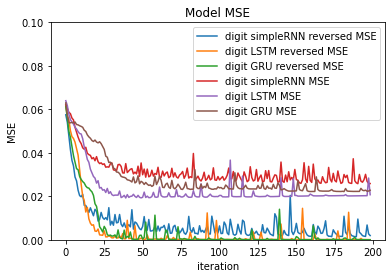

<Figure size 1440x720 with 0 Axes>

In [47]:
plt.plot(val_acc_simplernn_digit_True, label = "digit simpleRNN reversed accuracy")
plt.plot(val_acc_LSTM_digit_True, label = "digit LSTM reversed accuracy")
plt.plot(val_acc_gru_digit_True, label = "digit GRU reversed accuracy")

plt.plot(val_acc_simplernn_digit_false, label = "digit simpleRNN accuracy")
plt.plot(val_acc_LSTM_digit_False, label = "digit LSTM accuracy")
plt.plot(val_acc_gru_digit_false, label = "digit GRU accuracy")

plt.legend()
plt.title('Model accuracy digit')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.ylim(0,1)
plt.savefig("Model accuracy digit.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mse_simplernn_digit_True, label = "digit simpleRNN reversed MAE")
plt.plot(val_mse_LSTM_digit_True, label = "digit LSTM reversed MAE")
plt.plot(val_mse_gru_digit_True, label =  "digit GRU reversed MAE")

plt.plot(val_mse_simplernn_digit_false, label =  "digit simpleRNN MAE")
plt.plot(val_mse_LSTM_digit_False, label =  "digit LSTM MAE")
plt.plot(val_mse_gru_digit_false, label =  "digit GRU MAE")

plt.legend()
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('iteration')
plt.ylim(0,.2)
plt.savefig("Model mae digit.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)

plt.plot(val_mse_simplernn_digit_True, label = "digit simpleRNN reversed MSE")
plt.plot(val_mse_LSTM_digit_True, label = "digit LSTM reversed MSE")
plt.plot(val_mse_gru_digit_True, label =  "digit GRU reversed MSE")

plt.plot(val_mse_simplernn_digit_false, label =  "digit simpleRNN MSE")
plt.plot(val_mse_LSTM_digit_False, label =  "digit LSTM MSE")
plt.plot(val_mse_gru_digit_false, label =  "digit GRU MSE")

plt.legend()
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.ylim(0,.1)
plt.savefig("Model mse digit.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)

Task 2 : Bit representation model reversed

In [41]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 7.
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))

questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = str1 + ' '
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Total addition questions:', len(questions))

#Convert questions to bit-notation
newquestions = []
for i in range(len(questions)):
    data = questions[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion = '+'.join(strings)
    newquestions.append(newquestion)

#Convert expected to bit-notation
newexpected = []
for i in range(len(expected)):
    newexp = [int(bit) for bit in '{:010b}'.format(int(expected[i]))]
    newexp = ''.join(map(str, newexp))
    if len(newexp) < 11:
        newexp = '0' + newexp
    newexpected.append(newexp)

#Convert questions1 to bit-notation
newquestions1 = []
for i in range(len(questions1)):
    data = questions1[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion1 = '+'.join(strings)
    newquestions1.append(newquestion1)

#Convert expected1 to bit-notation
newexpected1 = []
for i in range(len(expected1)):
    newexp1 = [int(bit) for bit in '{:010b}'.format(int(expected1[i]))]
    newexp1 = ''.join(map(str, newexp1))
    if len(newexp1) < 11:
        newexp1 = '0' + newexp1
    newexpected1.append(newexp1)

# Maximum length of input is 'binary + binary' (e.g., '0001101011+110001001'). Maximum length of 21.
# binary is DIGITS.
DIGITSBIT = 10
MAXLENBIT = DIGITSBIT + 1 + DIGITSBIT

# All the numbers, plus sign and space for padding.
charsbit = '01+ '
ctablebit = CharacterTable(charsbit)

print('Vectorization...')
x = np.zeros((len(newquestions), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestions), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.

indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITSBIT + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn

RNN = layers.SimpleRNN

model_rnn = Sequential()
model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_rnn.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_rnn.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()



#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_gru.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_gru.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 21, 4)
(45000, 11, 4)
Validation Data:
(1000000, 21, 4)
(1000000, 11, 4)
Build model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               68096     
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 11, 4)             516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_____________________________________________

Task 2 : Training Bit representation reversed lstm reversed

In [48]:
val_acc_bit_lstm_true = []
val_mae_bit_lstm_true = []
val_mse_bit_lstm_true = []

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_bit_lstm_true.append(model.history.history["val_accuracy"])
    val_mae_bit_lstm_true.append(model.history.history["val_mae"])
    val_mse_bit_lstm_true.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_true_bit = (t1-t0)/200
print(timeperiteration_lstm_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 669us/sample - loss: 0.6684 - accuracy: 0.5354 - mae: 0.2388 - mse: 0.1196 - val_loss: 0.7086 - val_accuracy: 0.5017 - val_mae: 0.2486 - val_mse: 0.1277
Q 0010101001+0001111100 T 11000000001 ☒ 01111000000
Q 0101001001+0011011110 T 01111010011 ☒ 01111000000
Q 1010010010+1111111001 T 10100110000 ☒ 01110000000
Q 1010101101+0011110011 T 10101001011 ☒ 01110000000
Q 0010111001+0011110100 T 11010101011 ☒ 01111000000
Q 1101001111+0011100111 T 01001100000 ☒ 01110000000
Q 0110101111+0000100011 T 01100001000 ☒ 01111000000
Q 0101101100+0010100010 T 10111001100 ☒ 01111000000
Q 1011010000+1100100110 T 00101100110 ☒ 01110000000
Q 0000001001+0100011000 T 11000011101 ☒ 00000000000

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 31s 679us/sample - loss: 0.6516 - accuracy: 0.5522 - mae: 0.2326 - mse: 0.1164 - val_loss: 0.6958 - val_accuracy: 0.5153 - val_mae: 0.2463 - val_mse: 0.1248
Q 0001100100+1011001011 T 01100011111 ☒ 10111111111
Q 1000110101+1011011001 T 10001011000 ☒ 10011111111
Q 1000110100+1010001000 T 01101100011 ☒ 00111111111
Q 0000001101+0101101010 T 10000011010 ☒ 10011111111
Q 1111000000+0010100001 T 01011101001 ☒ 01111111111
Q 1000011001+1111010001 T 11101000101 ☒ 10011111111
Q 1110101110+1101011010 T 01000011001 ☒ 10011111111
Q 1111100001+1100100101 T 10100010101 ☒ 10011111111
Q 1000010000+0110001111 T 01010111110 ☒ 01111111111
Q 0001001000+0100100101 T 10001100110 ☒ 01111111111

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.6515 - accuracy: 0.5544 - mae: 0.2325 - mse: 0.1163 - val_loss: 0.7002 - val_accuracy

45000/45000 [==============================] - 30s 671us/sample - loss: 0.6510 - accuracy: 0.5528 - mae: 0.2323 - mse: 0.1163 - val_loss: 0.6950 - val_accuracy: 0.5147 - val_mae: 0.2462 - val_mse: 0.1247
Q 0101111010+1010011000 T 01111001110 ☒ 01111111111
Q 0110001110+1110001011 T 10101110000 ☒ 10111111111
Q 0110101011+0001010110 T 01101110010 ☒ 10111111111
Q 0110000011+1110010001 T 01001111000 ☒ 11111111111
Q 1111010111+0010101101 T 01100001000 ☒ 11111111111
Q 1101011010+1011100101 T 10100110001 ☒ 11111111111
Q 0111000011+0001000111 T 01010111000 ☒ 10111111111
Q 1110101110+0110110000 T 01001110000 ☒ 01111111111
Q 1011100000+0001000011 T 11000111101 ☒ 01111111111
Q 1000000011+0110101001 T 11101000110 ☒ 10111111111

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 670us/sample - loss: 0.6508 - accuracy: 0.5528 - mae: 0.2323 - mse: 0.1162 - val_loss: 0.6969 - val_accuracy

45000/45000 [==============================] - 30s 670us/sample - loss: 0.6502 - accuracy: 0.5556 - mae: 0.2320 - mse: 0.1161 - val_loss: 0.6956 - val_accuracy: 0.5161 - val_mae: 0.2459 - val_mse: 0.1248
Q 1100101000+0101011101 T 10000000011 ☒ 01110000000
Q 0110011101+0100000000 T 00100001011 ☒ 01110000000
Q 1110110101+1111000010 T 01100000000 ☒ 10000000000
Q 0000101110+1001100010 T 01010000110 ☒ 10000000000
Q 0010111001+1100011110 T 10010111010 ☒ 10000000000
Q 1111000001+0110100101 T 01111011111 ☒ 10000000000
Q 1100100110+0000011011 T 01100000100 ☒ 10000000000
Q 1110000001+1100100100 T 11001111000 ☒ 10000000000
Q 1001001101+1111001100 T 01111111011 ☒ 10000000000
Q 1100001011+1000100010 T 01110001110 ☒ 10000000000

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 669us/sample - loss: 0.6501 - accuracy: 0.5552 - mae: 0.2320 - mse: 0.1161 - val_loss: 0.6969 - val_accuracy

simple rnn bit true

In [49]:
val_acc_simplernn_bit_True = []
val_mae_simplernn_bit_True = []
val_mse_simplernn_bit_True = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_bit_True.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_bit_True.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_bit_True.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_true_bit = (t1-t0)/200
print(timeperiteration_simplernn_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 1ms/sample - loss: 0.6665 - accuracy: 0.5416 - mae: 0.2371 - mse: 0.1188 - val_loss: 0.6968 - val_accuracy: 0.5105 - val_mae: 0.2469 - val_mse: 0.1252
Q 0001011001+1000100010 T 01111011100 ☒ 10100000000
Q 0101010010+0110110000 T 01110101001 ☒ 01111111111
Q 1100101101+1010111101 T 10000111100 ☒ 10000000000
Q 1100000100+1110100001 T 01010011010 ☒ 01100000000
Q 0100000010+0010111010 T 10001100101 ☒ 01110101111
Q 1101110000+0010000011 T 00101110100 ☒ 01111111111
Q 0000111001+1111111010 T 01100101001 ☒ 00100000000
Q 0001100011+1101010000 T 01001111101 ☒ 01111111111
Q 1011010010+1010000010 T 00100001001 ☒ 01111111111
Q 0010010011+1010101001 T 10010110011 ☒ 10010000000

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] -

45000/45000 [==============================] - 43s 956us/sample - loss: 0.6282 - accuracy: 0.5802 - mae: 0.2235 - mse: 0.1113 - val_loss: 0.6817 - val_accuracy: 0.5399 - val_mae: 0.2378 - val_mse: 0.1213
Q 1010000010+1000101001 T 01000101101 ☒ 00100000000
Q 0001010011+0101011011 T 10100000110 ☒ 10100000000
Q 0101010010+1100000000 T 01101111111 ☒ 01101010111
Q 1000111110+1110010100 T 11000010011 ☒ 10100000000
Q 0000011011+1011101011 T 01001111100 ☒ 01000000000
Q 0000101001+1001011100 T 01001110011 ☒ 01100000000
Q 0000111010+1100000000 T 01101100010 ☒ 01101010100
Q 1100101101+1010001000 T 10100000111 ☒ 00110111111
Q 0101101011+1000100011 T 10110100101 ☒ 10100000000
Q 0111001110+1000011100 T 01100010010 ☒ 01100000000

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 959us/sample - loss: 0.6120 - accuracy: 0.5956 - mae: 0.2167 - mse: 0.1080 - val_loss: 0.6795 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 0.5642 - accuracy: 0.6360 - mae: 0.1975 - mse: 0.0985 - val_loss: 0.6509 - val_accuracy: 0.5818 - val_mae: 0.2183 - val_mse: 0.1135
Q 1001011110+1101011100 T 10111101100 ☒ 10111111111
Q 0100110001+0100010101 T 01011100101 ☒ 01111111111
Q 1111011101+1001100000 T 01010100101 ☒ 00011111111
Q 0000101111+0110001011 T 10111101101 ☒ 11001111111
Q 0010101011+0110010010 T 01011101110 ☒ 01111111111
Q 0011000101+0001010010 T 01110110100 ☒ 01101111111
Q 0011011000+1110011010 T 11011011010 ☒ 11000000000
Q 1010001101+1011110101 T 01111110110 ☒ 00011111111
Q 0000011001+1100011101 T 11011001111 ☒ 11010000000
Q 0010000000+0001010110 T 00111010000 ☒ 00111111111

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 963us/sample - loss: 0.5615 - accuracy: 0.6396 - mae: 0.

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 961us/sample - loss: 0.5428 - accuracy: 0.6550 - mae: 0.1893 - mse: 0.0944 - val_loss: 0.6394 - val_accuracy: 0.5972 - val_mae: 0.2101 - val_mse: 0.1106
Q 0101111001+0010011001 T 01010001100 ☒ 01011011111
Q 1010100101+0101010000 T 00010111110 ☒ 00010111111
Q 0000110000+0011001010 T 10000110001 ☒ 00101111111
Q 1110010011+1101001100 T 01111110010 ☒ 00100111111
Q 0100000110+0010011010 T 10100111000 ☒ 10111111111
Q 1110110100+0101100101 T 10000010111 ☒ 01111111111
Q 0001110100+0100010100 T 01011100110 ☒ 01010111111
Q 0100100110+1001010010 T 01111100100 ☒ 01111111111
Q 0001110000+1111111100 T 10010110010 ☒ 01001111111
Q 1000111010+1000010110 T 11010001101 ☒ 11011111111

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 972us/sample - loss: 0.5413 - accuracy: 0.6556 - mae: 0.

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 967us/sample - loss: 0.5286 - accuracy: 0.6667 - mae: 0.1840 - mse: 0.0917 - val_loss: 0.6389 - val_accuracy: 0.6032 - val_mae: 0.2062 - val_mse: 0.1099
Q 1100010100+1101000111 T 10000101110 ☒ 01110000000
Q 0010010001+0001101100 T 10110110001 ☒ 10110000000
Q 1100010000+1111111010 T 00110110100 ☒ 00111000000
Q 0001110000+1110010101 T 11001011010 ☒ 10000000000
Q 1011000110+0110101000 T 10111000001 ☒ 01100100000
Q 1000010010+0011001111 T 10011101101 ☒ 10010111111
Q 1110110010+1101010001 T 01010011100 ☒ 01010000000
Q 0011111100+0000110101 T 10001110010 ☒ 10000000000
Q 0110010100+1011110100 T 11001101010 ☒ 10010000000
Q 0000010010+0010101000 T 10101010010 ☒ 01110000000

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 0.5286 - accuracy: 0.6667 - mae: 0.

45000/45000 [==============================] - 43s 960us/sample - loss: 0.5175 - accuracy: 0.6766 - mae: 0.1799 - mse: 0.0896 - val_loss: 0.6479 - val_accuracy: 0.6050 - val_mae: 0.2047 - val_mse: 0.1106
Q 0011010101+1110100010 T 10110110010 ☒ 10110000000
Q 1011111010+0110110000 T 01001111001 ☒ 00011001111
Q 1000100011+1111001111 T 10010001110 ☒ 10000000000
Q 0101100101+0001110001 T 10111111011 ☒ 11110000000
Q 1110000011+0011001011 T 10000000001 ☒ 01110000000
Q 1010001000+0001000010 T 10110001110 ☒ 01000000000
Q 0101100001+1101011100 T 10101010111 ☒ 10111000000
Q 1111111010+1000000111 T 10010011101 ☒ 10001000000
Q 1011001100+0111110000 T 01011111010 ☒ 00101110000
Q 0111001011+1001011110 T 11001100000 ☒ 11000000000

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 0.5204 - accuracy: 0.6740 - mae: 0.1805 - mse: 0.0901 - val_loss: 0.6442 - val_accuracy

45000/45000 [==============================] - 44s 981us/sample - loss: 0.5125 - accuracy: 0.6805 - mae: 0.1777 - mse: 0.0887 - val_loss: 0.6466 - val_accuracy: 0.6085 - val_mae: 0.2026 - val_mse: 0.1100
Q 0010101011+0010010001 T 10001001111 ☒ 10000000000
Q 1000110000+1000001100 T 10100110011 ☒ 00110000000
Q 0111011001+1011010110 T 10001111110 ☒ 10011000000
Q 1110111101+1100110011 T 11101010011 ☒ 11010000000
Q 1111111001+1100101111 T 11101111011 ☒ 11110111111
Q 0110000001+1011000000 T 10001100101 ☒ 01101011111
Q 0101110110+1011101111 T 10011010001 ☒ 10000000000
Q 1111111011+1100110000 T 01011101100 ☒ 01001110000
Q 0101000100+1010000111 T 01110101100 ☒ 11000000000
Q 1101000011+1010110001 T 11000000110 ☒ 11100000000

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 970us/sample - loss: 0.5096 - accuracy: 0.6824 - mae: 0.1768 - mse: 0.0882 - val_loss: 0.6473 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 971us/sample - loss: 0.5050 - accuracy: 0.6858 - mae: 0.1750 - mse: 0.0873 - val_loss: 0.6562 - val_accuracy: 0.6071 - val_mae: 0.2025 - val_mse: 0.1111
Q 1001000000+0101001011 T 00100000001 ☒ 00100000000
Q 0001010100+0001011001 T 10111000101 ☒ 11000000000
Q 0001101000+1000101110 T 01010001100 ☒ 01001000000
Q 1110001110+0110100111 T 10101011101 ☒ 10110000000
Q 1011110111+0100011110 T 10000010011 ☒ 10000000000
Q 1101000010+0001100100 T 01111110101 ☒ 10001111111
Q 1110111010+1001000011 T 10101000110 ☒ 10111111111
Q 1111011011+0101111101 T 10011011101 ☒ 10100000000
Q 1111001101+0111011001 T 10001110111 ☒ 10000000000
Q 0010011100+1110101101 T 11000001101 ☒ 11000000000

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 972us/sample - loss: 0.5049 - accuracy: 0.6868 - mae: 0.

45000/45000 [==============================] - 43s 959us/sample - loss: 0.5018 - accuracy: 0.6886 - mae: 0.1737 - mse: 0.0867 - val_loss: 0.6582 - val_accuracy: 0.6096 - val_mae: 0.2013 - val_mse: 0.1106
Q 0100100000+1100100000 T 01110000101 ☒ 00010000000
Q 0110110110+0101111000 T 10000011111 ☒ 10001111111
Q 1100110011+1010011010 T 11010000111 ☒ 11010000000
Q 0001000010+0011111011 T 01011111000 ☒ 01100111111
Q 1010001000+1101001110 T 11101111010 ☒ 10000001000
Q 0010001111+0101110010 T 01101110010 ☒ 01101000000
Q 1010000001+1101111101 T 10000111010 ☒ 10000000000
Q 0110110001+0100001111 T 01110100110 ☒ 01111000000
Q 1110100111+1100101100 T 10000000111 ☒ 10000000000
Q 0000110000+0001111011 T 11011000000 ☒ 01110111100

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 977us/sample - loss: 0.5000 - accuracy: 0.6893 - mae: 0.1732 - mse: 0.0864 - val_loss: 0.6506 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 971us/sample - loss: 0.4966 - accuracy: 0.6918 - mae: 0.1718 - mse: 0.0858 - val_loss: 0.6614 - val_accuracy: 0.6114 - val_mae: 0.1999 - val_mse: 0.1110
Q 0100111101+0110000000 T 01000000101 ☒ 00111011111
Q 0011110010+1011111011 T 01111110011 ☒ 00111111111
Q 0010011110+0101000111 T 10001000101 ☒ 01111111111
Q 0001001000+0011100000 T 00001101101 ☒ 00001011111
Q 1000101010+0001110000 T 10101100111 ☒ 01100000000
Q 1001000000+1101100000 T 01011011001 ☒ 01001111111
Q 1001001100+0010001011 T 01011100100 ☒ 01100111111
Q 1011110111+1001011001 T 10111000011 ☒ 10101111111
Q 1001101011+1100101100 T 01101100110 ☒ 01111111111
Q 1110110110+1110010100 T 11010011111 ☒ 11001101011

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 953us/sample - loss: 0.4993 - accuracy: 0.6913 - mae: 0.

45000/45000 [==============================] - 44s 971us/sample - loss: 0.4928 - accuracy: 0.6952 - mae: 0.1705 - mse: 0.0851 - val_loss: 0.6642 - val_accuracy: 0.6116 - val_mae: 0.1998 - val_mse: 0.1110
Q 1010111001+1110001000 T 10001001000 ☒ 01111010000
Q 0110000001+1110010111 T 10101001010 ☒ 10101000000
Q 0110010101+1001101001 T 01111010110 ☒ 10000000000
Q 0111000000+1110000011 T 01111011011 ☒ 01001000000
Q 1011000110+0101110111 T 10011100100 ☒ 10010000000
Q 1111100010+1000100000 T 10111010100 ☒ 01101100000
Q 0110011101+1101010110 T 01111001011 ☒ 00000000000
Q 0001000000+1101001001 T 11000110001 ☒ 01101101010
Q 0100001001+1110010111 T 10110000110 ☒ 10101000000
Q 1001110000+0011110011 T 01110000111 ☒ 01100000000

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 974us/sample - loss: 0.4916 - accuracy: 0.6955 - mae: 0.1702 - mse: 0.0849 - val_loss: 0.6579 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 956us/sample - loss: 0.4889 - accuracy: 0.6977 - mae: 0.1689 - mse: 0.0844 - val_loss: 0.6671 - val_accuracy: 0.6116 - val_mae: 0.1996 - val_mse: 0.1112
Q 1101010001+0100110111 T 10010110100 ☒ 10000000000
Q 0110000111+0110110000 T 01010010011 ☒ 00100011111
Q 1111001001+1001101001 T 00100101101 ☒ 10100000000
Q 0010111101+1101110001 T 01101000000 ☒ 01100000000
Q 1111111010+0100111101 T 01101001000 ☒ 01100000000
Q 0000010010+1011000011 T 10000101101 ☒ 01111011111
Q 0010111000+0010000110 T 10111010110 ☒ 10110100000
Q 1001100110+0100010100 T 10010001101 ☒ 10011101000
Q 0101110101+1101101001 T 10010110010 ☒ 10011111111
Q 0011100000+0001111011 T 11010101100 ☒ 01110010000

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 954us/sample - loss: 0.4881 - accuracy: 0.6986 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 956us/sample - loss: 0.4897 - accuracy: 0.6988 - mae: 0.1689 - mse: 0.0845 - val_loss: 0.6635 - val_accuracy: 0.6135 - val_mae: 0.1990 - val_mse: 0.1105
Q 1101110011+1010000000 T 01011011101 ☒ 01011010000
Q 1000111000+0100001000 T 00101111001 ☒ 00100111111
Q 0110101101+0110110000 T 01010100000 ☒ 01010110100
Q 0100001000+0010011010 T 10100100001 ☒ 01011000000
Q 0001010010+0100011000 T 11000101110 ☒ 01000100101
Q 0001001111+1110111100 T 11001001011 ☒ 11000000000
Q 1111111100+0000110000 T 01001111100 ☒ 01010000111
Q 1001010110+0100001010 T 01011101011 ☒ 01101010000
Q 0010001000+1011010000 T 01001110010 ☒ 00010000000
Q 1101100010+1100011000 T 00111100001 ☒ 00111101111

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 954us/sample - loss: 0.4873 - accuracy: 0.6997 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 971us/sample - loss: 0.4849 - accuracy: 0.7011 - mae: 0.1675 - mse: 0.0837 - val_loss: 0.6742 - val_accuracy: 0.6136 - val_mae: 0.1985 - val_mse: 0.1112
Q 1010100101+0010000000 T 00010101010 ☒ 00010101111
Q 1001011011+1011101000 T 01100000000 ☒ 00110111011
Q 1011010000+1010000000 T 00001101000 ☒ 00000111111
Q 1111111101+0011010000 T 10010110111 ☒ 01100011111
Q 1010111011+1000111101 T 01110110001 ☒ 01111000000
Q 1101010001+1110110111 T 01011001010 ☒ 01010000000
Q 1101000011+1101000111 T 11010010110 ☒ 11001101000
Q 0111110111+0011000000 T 10000101101 ☒ 01101111111
Q 1001000111+0110011001 T 01110011101 ☒ 01110111111
Q 0010111011+1100011111 T 10000111111 ☒ 10000000000

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 978us/sample - loss: 0.4827 - accuracy: 0.7036 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 55s 1ms/sample - loss: 0.4821 - accuracy: 0.7037 - mae: 0.1665 - mse: 0.0832 - val_loss: 0.6721 - val_accuracy: 0.6141 - val_mae: 0.1982 - val_mse: 0.1110
Q 1011001100+0100000101 T 01011101100 ☒ 01001100000
Q 1101101010+0110101000 T 01100101011 ☒ 01100110111
Q 1111110101+1100011000 T 10100010001 ☒ 00101111111
Q 0010010111+0110011001 T 01010001111 ☒ 01001011111
Q 1001100101+1100001010 T 01101111001 ☒ 01101111111
Q 0010101101+1010011010 T 10010011100 ☒ 10001111111
Q 0110101001+0111001111 T 10101011110 ☒ 10101011000
Q 0101001000+1000011111 T 00110111110 ☒ 00110111111
Q 0011101110+0010001000 T 10111111110 ☒ 01001101111
Q 0110000010+1011100111 T 01100010111 ☒ 01100111111

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 55s 1ms/sample - loss: 0.4837 - accuracy: 0.7015 - mae: 0.167

45000/45000 [==============================] - 53s 1ms/sample - loss: 0.4813 - accuracy: 0.7036 - mae: 0.1660 - mse: 0.0831 - val_loss: 0.6783 - val_accuracy: 0.6126 - val_mae: 0.1986 - val_mse: 0.1116
Q 1111001100+0001001111 T 11000100011 ☒ 10000000000
Q 1110000000+0001101111 T 10010100101 ☒ 00010000000
Q 1110101111+0011110110 T 01101000001 ☒ 01100000000
Q 0000110101+1110001111 T 11001110111 ☒ 11000000000
Q 0101101001+1100010010 T 00110001110 ☒ 00111111111
Q 0101111110+0110100110 T 10010111001 ☒ 10010111111
Q 1000010000+1000001000 T 01001010001 ☒ 00001011111
Q 1100110010+0100000111 T 11001000001 ☒ 11001000000
Q 0100011111+1110111101 T 10110110000 ☒ 10110000000
Q 1101010111+1100101110 T 11010100111 ☒ 11011000000

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 53s 1ms/sample - loss: 0.4804 - accuracy: 0.7040 - mae: 0.1660 - mse: 0.0830 - val_loss: 0.6755 - val_accuracy: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 55s 1ms/sample - loss: 0.4774 - accuracy: 0.7061 - mae: 0.1651 - mse: 0.0824 - val_loss: 0.6798 - val_accuracy: 0.6148 - val_mae: 0.1976 - val_mse: 0.1113
Q 1000110001+0000111101 T 00110100110 ☒ 00111111111
Q 0010110111+0100010011 T 10000100001 ☒ 00001111111
Q 1110001110+0001011110 T 10110011110 ☒ 10110111111
Q 1010011111+0100101110 T 10110110111 ☒ 10110011111
Q 0100010001+0000100100 T 10000111110 ☒ 10000011111
Q 0101111001+1010100001 T 01100000011 ☒ 01000000000
Q 1011000110+1100000000 T 01100110111 ☒ 01100011111
Q 0110001110+1101100010 T 01101000100 ☒ 01111111111
Q 1101000101+1011101000 T 01000100010 ☒ 00011111111
Q 0111101001+0000111000 T 01100110001 ☒ 01100111111

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 55s 1ms/sample - loss: 0.4811 - accuracy: 0.7033 - mae: 0.165

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 982us/sample - loss: 0.4753 - accuracy: 0.7078 - mae: 0.1644 - mse: 0.0821 - val_loss: 0.6904 - val_accuracy: 0.6122 - val_mae: 0.1986 - val_mse: 0.1125
Q 1000110010+1000110001 T 01010011100 ☒ 01010000000
Q 0001000010+1011100000 T 10101100110 ☒ 01000001010
Q 0011011011+0000001110 T 10111110010 ☒ 11010101111
Q 1000101101+0000000000 T 00001111111 ☒ 00011011111
Q 0111111101+1111010111 T 01111111000 ☒ 01111111111
Q 1111011011+0000110011 T 11000111100 ☒ 11001000000
Q 0111011010+1101001000 T 10011010001 ☒ 01011010000
Q 1001101110+1011111011 T 01100000100 ☒ 01010000000
Q 0011001111+1000010101 T 01010001111 ☒ 01011011111
Q 1010011101+0110110101 T 01010000011 ☒ 01001000000

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 993us/sample - loss: 0.4798 - accuracy: 0.7046 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 995us/sample - loss: 0.4757 - accuracy: 0.7083 - mae: 0.1643 - mse: 0.0821 - val_loss: 0.6819 - val_accuracy: 0.6153 - val_mae: 0.1973 - val_mse: 0.1112
Q 1011001000+0000010000 T 01100011001 ☒ 00001111111
Q 0101101100+1011100011 T 11001001001 ☒ 11000000000
Q 0110101001+0001100100 T 10001111010 ☒ 10000000000
Q 0001100110+0111010000 T 01101100100 ☒ 01101011111
Q 0001110001+0000011000 T 01110100110 ☒ 01110110101
Q 1110110110+0101001100 T 10001110000 ☒ 10011000000
Q 1111000000+0000111001 T 00111011101 ☒ 00111011111
Q 0010100111+0010001101 T 10110010010 ☒ 10110101010
Q 0100011011+0100101001 T 10010001011 ☒ 10001000000
Q 1111001000+1001100101 T 11000000000 ☒ 01000101111

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 995us/sample - loss: 0.4731 - accuracy: 0.7099 - mae: 0

45000/45000 [==============================] - 45s 994us/sample - loss: 0.4720 - accuracy: 0.7094 - mae: 0.1633 - mse: 0.0815 - val_loss: 0.6917 - val_accuracy: 0.6148 - val_mae: 0.1972 - val_mse: 0.1120
Q 1100011001+1101011010 T 00111011111 ☒ 01001100000
Q 1011100011+0000110011 T 10110000111 ☒ 11000000000
Q 0011101110+0100010011 T 01101110010 ☒ 01111111111
Q 1100010001+1000110110 T 10000110111 ☒ 10000111111
Q 1010011111+1111110000 T 01101000011 ☒ 01101101111
Q 0011111100+1110010110 T 01001000000 ☒ 01001111111
Q 1100101010+1111110011 T 10000101111 ☒ 00001100000
Q 0000001100+1000111011 T 00111011111 ☒ 01000000000
Q 1101100010+1011011001 T 00111111100 ☒ 01000011111
Q 1111100101+1110101101 T 01110000111 ☒ 01111001111

--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 986us/sample - loss: 0.4736 - accuracy: 0.7099 - mae: 0.1634 - mse: 0.0818 - val_loss: 0.6876 - val_accurac

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 994us/sample - loss: 0.4778 - accuracy: 0.7070 - mae: 0.1646 - mse: 0.0825 - val_loss: 0.6882 - val_accuracy: 0.6153 - val_mae: 0.1970 - val_mse: 0.1119
Q 1010011110+1101101101 T 01011010001 ☒ 01010000000
Q 0111110101+1100111000 T 01011001110 ☒ 01100000000
Q 1100011010+1100101000 T 01001001111 ☒ 01001000000
Q 1001011110+1101000011 T 11110101001 ☒ 11111011111
Q 1010001110+0011101101 T 01001001111 ☒ 01010000000
Q 0110110100+0110100101 T 01000100011 ☒ 01000000000
Q 0011110011+1101110001 T 01111101011 ☒ 01111000000
Q 0000011011+0100101110 T 10001101100 ☒ 10000000000
Q 1001100111+1010110111 T 10000110110 ☒ 10001100000
Q 1000010001+1000110111 T 10001000110 ☒ 10000000000

--------------------------------------------------
Iteration 182
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 988us/sample - loss: 0.4740 - accuracy: 0.7086 - mae: 0

45000/45000 [==============================] - 45s 994us/sample - loss: 0.4746 - accuracy: 0.7084 - mae: 0.1637 - mse: 0.0820 - val_loss: 0.6920 - val_accuracy: 0.6151 - val_mae: 0.1971 - val_mse: 0.1120
Q 1011001111+0110001010 T 01111101010 ☒ 10000000000
Q 1101101101+0000001011 T 00101110111 ☒ 00100000000
Q 1010000000+0111000001 T 01010100011 ☒ 01001111111
Q 0101100001+1110001011 T 11011101101 ☒ 11100000000
Q 0010101000+1111101010 T 00011001001 ☒ 00011001000
Q 1111111011+1100010100 T 01110111111 ☒ 01111111111
Q 1010101010+1101010011 T 00100000101 ☒ 00100000000
Q 0000010111+0000000110 T 10100100000 ☒ 10100111111
Q 0100010101+0011011100 T 10001010100 ☒ 10000000000
Q 1110000111+0000000010 T 01111000001 ☒ 11100000000

--------------------------------------------------
Iteration 191
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 996us/sample - loss: 0.4724 - accuracy: 0.7106 - mae: 0.1630 - mse: 0.0816 - val_loss: 0.6908 - val_accurac

45000/45000 [==============================] - 45s 997us/sample - loss: 0.4722 - accuracy: 0.7110 - mae: 0.1629 - mse: 0.0815 - val_loss: 0.6893 - val_accuracy: 0.6149 - val_mae: 0.1971 - val_mse: 0.1117
Q 1110100101+0010001100 T 10000100001 ☒ 10000111111
Q 0100011000+1000101111 T 01101100100 ☒ 01101000000
Q 1001010010+1011011010 T 10101001011 ☒ 10101111111
Q 1100011101+0101000001 T 10010001010 ☒ 10011111111
Q 1110110011+0110001010 T 01110110111 ☒ 01111111111
Q 0110001010+1011011110 T 01111111001 ☒ 01111111111
Q 1110101000+0010000000 T 01100010000 ☒ 00100000000
Q 1011011010+1011011110 T 01110111101 ☒ 01110111111
Q 1101010111+1011001101 T 11001111000 ☒ 11001011111
Q 0000101001+1111011000 T 00110010110 ☒ 00100111111
45.456570332050326


gru bit true 

In [50]:
val_acc_gru_bit_True = []
val_mae_gru_bit_True = []
val_mse_gru_bit_True = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_bit_True.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_bit_True.append(model_gru.history.history["val_mae"])##
    val_mse_gru_bit_True.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_true_bit = (t1-t0)/200
print(timeperiteration_gru_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 34s 746us/sample - loss: 0.6824 - accuracy: 0.5314 - mae: 0.2421 - mse: 0.1209 - val_loss: 0.7106 - val_accuracy: 0.5023 - val_mae: 0.2492 - val_mse: 0.1288
Q 0101100000+1001000011 T 01101000111 ☒ 01111111111
Q 0001010111+1100100000 T 01011011010 ☒ 01111111111
Q 1111111100+1100111110 T 11000001010 ☒ 01111111111
Q 1110101100+1110111001 T 01010001000 ☒ 01111111111
Q 1111111100+1100001100 T 10001110111 ☒ 01111111111
Q 1011110010+1001011110 T 11010100001 ☒ 01111111111
Q 1000000110+1000000110 T 10010001110 ☒ 01111111111
Q 0101011011+1010011100 T 10101111000 ☒ 01111111111
Q 1000110010+0110001110 T 01110111101 ☒ 01111111111
Q 0110110000+0101001001 T 01011011010 ☒ 01111111111

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 27s 598us/sample - loss: 0.6513 - accuracy: 0.5527 - mae: 0.2324 - mse: 0.1163 - val_loss: 0.6947 - val_accuracy: 0.5148 - val_mae: 0.2462 - val_mse: 0.1246
Q 0010000011+1010110011 T 00110010101 ☒ 10111111111
Q 0011010000+1101101011 T 01111101010 ☒ 01111111111
Q 1100100110+0101011011 T 01100001110 ☒ 10011111111
Q 1011011010+0011001001 T 10110101000 ☒ 10111111111
Q 1111011010+1100111011 T 10001111111 ☒ 10111111111
Q 1111101111+0101100011 T 01010111000 ☒ 10111111111
Q 0010000000+0101100001 T 10011010011 ☒ 01111111111
Q 0000001101+0110110100 T 01010110000 ☒ 01100111111
Q 0110100110+0100110100 T 10111000011 ☒ 10111111111
Q 1010100000+0011000000 T 00101001010 ☒ 00001111111

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 606us/sample - loss: 0.6511 - accuracy: 0.5533 - mae: 0.2324 - mse: 0.1163 - val_loss: 0.6988 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.6499 - accuracy: 0.5542 - mae: 0.2320 - mse: 0.1161 - val_loss: 0.6985 - val_accuracy: 0.5155 - val_mae: 0.2460 - val_mse: 0.1251
Q 0001100000+0110111000 T 01101010101 ☒ 01100000000
Q 1001100000+0111101101 T 00111101001 ☒ 01100000000
Q 0001011101+0011011000 T 10011100000 ☒ 10000000000
Q 1000011101+0100000110 T 10110001100 ☒ 00000000000
Q 1010011111+0010010101 T 10111000011 ☒ 10000000000
Q 0000101111+0111110110 T 10100101011 ☒ 10000000000
Q 0011001000+0110011001 T 10000111110 ☒ 01100000000
Q 0110001011+0010100100 T 11010001111 ☒ 10000000000
Q 0111001000+0101000011 T 01111000100 ☒ 01100000000
Q 0100100100+1010010000 T 01011001010 ☒ 01100000000

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.6497 - accuracy: 0.5545 - mae: 0.2319 - mse: 0.1160 - val_loss: 0.6962 - val_accuracy

45000/45000 [==============================] - 27s 596us/sample - loss: 0.5808 - accuracy: 0.6206 - mae: 0.2051 - mse: 0.1020 - val_loss: 0.6466 - val_accuracy: 0.5749 - val_mae: 0.2207 - val_mse: 0.1136
Q 0101000100+0010110000 T 10000111001 ☒ 01101111111
Q 0111100110+0111101000 T 01110001000 ☒ 00111111111
Q 0010111101+1100100000 T 01011101100 ☒ 01011111111
Q 1011101101+0100110110 T 01100000011 ☒ 01000000000
Q 0110110000+1101001000 T 00001100110 ☒ 00001111111
Q 0001000011+0100011000 T 11000011111 ☒ 01011000000
Q 1101001100+1111110000 T 01010010110 ☒ 00111111111
Q 0110101001+1101000010 T 11001111001 ☒ 10111111111
Q 0000101111+1111100110 T 10010101001 ☒ 10000000000
Q 1010010000+1101011001 T 11001101110 ☒ 01110000000

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.5734 - accuracy: 0.6266 - mae: 0.2019 - mse: 0.1005 - val_loss: 0.6418 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.5319 - accuracy: 0.6622 - mae: 0.1855 - mse: 0.0923 - val_loss: 0.6197 - val_accuracy: 0.6107 - val_mae: 0.2037 - val_mse: 0.1073
Q 0001110111+0001000110 T 01000101000 ☒ 01011000000
Q 0100010100+1010110000 T 01001100011 ☒ 00100000000
Q 1010100000+1110000011 T 01010111001 ☒ 01000000000
Q 0111001010+0010000100 T 01010011000 ☒ 01000000000
Q 0011100101+0111010001 T 11010111001 ☒ 11000000000
Q 1100000000+1111001110 T 00101101111 ☒ 00110000000
Q 0101000100+1010001001 T 01111111000 ☒ 00110000000
Q 1110101010+1010101110 T 10100011011 ☒ 10010111111
Q 1100000100+0000100011 T 01001101010 ☒ 01001000000
Q 1011111000+1101010000 T 01101011101 ☒ 01000000000

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.5298 - accuracy: 0.6632 - mae: 0.1846 - mse: 0.0919 - val_loss: 0.6215 - val_accuracy

45000/45000 [==============================] - 27s 601us/sample - loss: 0.5112 - accuracy: 0.6811 - mae: 0.1773 - mse: 0.0883 - val_loss: 0.6197 - val_accuracy: 0.6190 - val_mae: 0.1972 - val_mse: 0.1065
Q 1101000010+0001110010 T 01111001111 ☒ 01110111000
Q 0111010010+0101000111 T 01100101100 ☒ 01101000000
Q 0011011011+1000110010 T 10010011101 ☒ 10011111111
Q 1001011011+1011001001 T 10101010011 ☒ 10111111111
Q 0110101111+0010101000 T 01100000001 ☒ 00101000000
Q 1011011101+1100101000 T 01111011001 ☒ 01110001111
Q 0110011110+1110001111 T 10110101101 ☒ 10111111111
Q 1010000001+0000010110 T 10100110001 ☒ 10100000000
Q 1100111101+1010100100 T 10111011010 ☒ 10100000011
Q 1100111001+1000101010 T 10110110011 ☒ 10100011111

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.5091 - accuracy: 0.6827 - mae: 0.1766 - mse: 0.0879 - val_loss: 0.6156 - val_accuracy

45000/45000 [==============================] - 27s 600us/sample - loss: 0.4961 - accuracy: 0.6943 - mae: 0.1716 - mse: 0.0855 - val_loss: 0.6168 - val_accuracy: 0.6287 - val_mae: 0.1931 - val_mse: 0.1051
Q 1111001101+0011101000 T 10010110111 ☒ 01111101011
Q 1000010111+1100010111 T 10000101100 ☒ 10000000000
Q 0000011000+0101101001 T 01110000000 ☒ 00100000000
Q 0001111100+1010111001 T 11011101000 ☒ 11101000011
Q 0111111100+1011101100 T 01000111110 ☒ 01001000000
Q 0111110010+1110010101 T 11011111101 ☒ 11100000111
Q 0011001000+0000000010 T 10100101010 ☒ 01010000000
Q 1000101001+0100111001 T 01111111101 ☒ 00011000000
Q 0110110100+1110010010 T 01101101001 ☒ 01110000000
Q 1011110001+1000010101 T 01011101111 ☒ 01011000000

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.4957 - accuracy: 0.6950 - mae: 0.1713 - mse: 0.0855 - val_loss: 0.6153 - val_accuracy

45000/45000 [==============================] - 27s 599us/sample - loss: 0.4842 - accuracy: 0.7043 - mae: 0.1671 - mse: 0.0833 - val_loss: 0.6150 - val_accuracy: 0.6349 - val_mae: 0.1897 - val_mse: 0.1040
Q 1110001101+1111111010 T 00111110100 ☒ 01000000000
Q 1111001101+1001000100 T 11001110000 ☒ 11000000000
Q 0010100100+0110101011 T 10100010011 ☒ 10100000000
Q 0110010010+1001111000 T 01001100101 ☒ 01010100000
Q 1100000100+1111001001 T 00101000110 ☒ 00010000000
Q 1010000000+0110110001 T 01011001011 ☒ 01010100000
Q 1010110111+1000001000 T 01111101101 ☒ 01111110000
Q 1101110000+1100010110 T 01111110001 ☒ 10000011111
Q 1011110000+0111110001 T 00111101011 ☒ 00111111110
Q 0111100100+1100110111 T 11001000000 ☒ 11000011111

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.4819 - accuracy: 0.7063 - mae: 0.1664 - mse: 0.0829 - val_loss: 0.6178 - val_accuracy

45000/45000 [==============================] - 27s 599us/sample - loss: 0.4721 - accuracy: 0.7135 - mae: 0.1629 - mse: 0.0811 - val_loss: 0.6240 - val_accuracy: 0.6369 - val_mae: 0.1876 - val_mse: 0.1043
Q 1001110000+0000110011 T 10101011000 ☒ 01010100000
Q 1111110000+1010000010 T 00011000110 ☒ 00011000000
Q 0010011100+0111111101 T 10111010001 ☒ 11011010101
Q 1010101000+0010001100 T 01011101101 ☒ 01011101000
Q 1100000000+1110101000 T 01100001111 ☒ 00001100000
Q 1111100111+0011100000 T 01100101011 ☒ 01100000000
Q 1110010110+0011111101 T 01100010111 ☒ 01100000000
Q 0010110001+1111100110 T 01111010011 ☒ 01111111111
Q 0110010000+0010110000 T 10000111000 ☒ 00001100111
Q 0001111100+0110010100 T 10111011111 ☒ 10111000000

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.4720 - accuracy: 0.7141 - mae: 0.1627 - mse: 0.0811 - val_loss: 0.6238 - val_accuracy

45000/45000 [==============================] - 27s 607us/sample - loss: 0.4638 - accuracy: 0.7202 - mae: 0.1599 - mse: 0.0797 - val_loss: 0.6349 - val_accuracy: 0.6382 - val_mae: 0.1864 - val_mse: 0.1050
Q 1011001001+1000100000 T 10000100000 ☒ 10001010111
Q 1111110000+0011110011 T 01101100000 ☒ 01101000000
Q 0101000010+0001111001 T 01110000010 ☒ 01101000000
Q 1111111101+0000111101 T 10000000000 ☒ 01111100000
Q 1100001110+0101100100 T 01001011101 ☒ 01001000000
Q 0100001111+0110011111 T 10010010000 ☒ 10010000000
Q 0111001000+1101111010 T 11100110011 ☒ 10000000000
Q 1000111100+1110111100 T 01101110100 ☒ 01110000000
Q 1000001110+1010101110 T 11101110100 ☒ 11101111111
Q 1101010001+1101001000 T 10001100101 ☒ 01001000000

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.4643 - accuracy: 0.7192 - mae: 0.1600 - mse: 0.0798 - val_loss: 0.6298 - val_accuracy

45000/45000 [==============================] - 27s 602us/sample - loss: 0.4559 - accuracy: 0.7264 - mae: 0.1572 - mse: 0.0783 - val_loss: 0.6457 - val_accuracy: 0.6391 - val_mae: 0.1858 - val_mse: 0.1058
Q 0010001101+0010000101 T 10011100101 ☒ 10011000000
Q 1001100001+1101101010 T 10111000110 ☒ 10110000000
Q 1001111001+0001100001 T 01111001011 ☒ 01110000000
Q 1111000111+1000110111 T 01010011100 ☒ 01010000000
Q 0110010011+0110110000 T 01010001101 ☒ 01010110000
Q 0101100001+1001000000 T 11011000111 ☒ 01101000000
Q 0010101101+0111011100 T 10011101011 ☒ 10010111111
Q 0010000000+0101110010 T 00110100001 ☒ 00110101111
Q 0010100110+1001000011 T 10010011101 ☒ 10010111000
Q 1100110000+0101111000 T 00011101100 ☒ 00011111100

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.4557 - accuracy: 0.7255 - mae: 0.1571 - mse: 0.0783 - val_loss: 0.6385 - val_accuracy

45000/45000 [==============================] - 27s 602us/sample - loss: 0.4476 - accuracy: 0.7315 - mae: 0.1543 - mse: 0.0769 - val_loss: 0.6489 - val_accuracy: 0.6409 - val_mae: 0.1847 - val_mse: 0.1056
Q 0000011101+0011100110 T 01101010011 ☒ 01101100000
Q 0011101101+0111110001 T 01011001000 ☒ 01011111111
Q 0000111101+1000010101 T 01001111001 ☒ 01001100000
Q 1101111011+0010110101 T 00111101110 ☒ 00111000000
Q 1101101000+1010101100 T 00111110110 ☒ 00100100000
Q 1000001110+0110111000 T 11011011011 ☒ 11011101111
Q 0001101100+0110000000 T 01010100000 ☑ 01010100000
Q 0000100000+1110001111 T 01100111110 ☒ 01101000000
Q 1000101010+1001000000 T 11001100001 ☒ 01010000000
Q 1101011010+0000010111 T 10010101000 ☒ 10010000001

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.4487 - accuracy: 0.7308 - mae: 0.1546 - mse: 0.0771 - val_loss: 0.6568 - val_accurac

45000/45000 [==============================] - 27s 596us/sample - loss: 0.4400 - accuracy: 0.7368 - mae: 0.1519 - mse: 0.0756 - val_loss: 0.6597 - val_accuracy: 0.6420 - val_mae: 0.1839 - val_mse: 0.1060
Q 0001101010+1000110001 T 01001100000 ☒ 01001011111
Q 1111010000+0001011001 T 01010110010 ☒ 01010101111
Q 1111100010+0100101101 T 01111110001 ☒ 01111111111
Q 0011000110+0110110001 T 10101001110 ☒ 10100000111
Q 0011000000+1010100110 T 01000001101 ☒ 01011111111
Q 0000111101+0110000000 T 01101011001 ☒ 00101111100
Q 1001011101+0000010000 T 01000111010 ☒ 01001111111
Q 1010110001+1010000000 T 10000101001 ☒ 01000111000
Q 1001010101+1010001111 T 01011110011 ☒ 01011111111
Q 0101101010+0010010001 T 10111010000 ☒ 10111000000

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.4419 - accuracy: 0.7357 - mae: 0.1522 - mse: 0.0759 - val_loss: 0.6648 - val_accurac

45000/45000 [==============================] - 27s 597us/sample - loss: 0.4373 - accuracy: 0.7386 - mae: 0.1506 - mse: 0.0751 - val_loss: 0.6714 - val_accuracy: 0.6424 - val_mae: 0.1833 - val_mse: 0.1066
Q 0000001101+0101010010 T 10100010011 ☒ 10001000111
Q 1000000100+1101101000 T 01110101100 ☒ 00100011111
Q 1101110000+1010110101 T 10101000010 ☒ 00111101111
Q 0100100010+1100011101 T 10110000001 ☒ 10101111111
Q 0010011011+1011011101 T 11100010111 ☒ 11011011111
Q 0110000001+0100101110 T 10111000111 ☒ 10111111111
Q 1110111010+0010101001 T 10011110100 ☒ 10011111111
Q 1101001101+1111001111 T 10001001000 ☒ 10000111111
Q 0010000100+1001010110 T 01011110011 ☒ 01011111111
Q 0100000010+1110101001 T 11100110111 ☒ 11100000000

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.4322 - accuracy: 0.7411 - mae: 0.1492 - mse: 0.0743 - val_loss: 0.6739 - val_accurac

45000/45000 [==============================] - 27s 596us/sample - loss: 0.4317 - accuracy: 0.7427 - mae: 0.1486 - mse: 0.0742 - val_loss: 0.6831 - val_accuracy: 0.6423 - val_mae: 0.1833 - val_mse: 0.1073
Q 1111101100+0001111110 T 01011010111 ☒ 01001111111
Q 1001011101+1001010001 T 01110000110 ☒ 01110011111
Q 1101101010+1111101000 T 01100100010 ☒ 01100000111
Q 0000011101+0001001000 T 01010011000 ☒ 01010001011
Q 0010110110+0110000010 T 01110000000 ☑ 01110000000
Q 1001110011+1010000100 T 01101011011 ☒ 01101010000
Q 1110111100+1001001110 T 10111011000 ☒ 10111111111
Q 0000011000+1110110001 T 10110101111 ☒ 01101011111
Q 1000000010+0000100011 T 10011010111 ☒ 10011011111
Q 0100001011+1110010100 T 10010101111 ☒ 10010000000

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4281 - accuracy: 0.7448 - mae: 0.1477 - mse: 0.0736 - val_loss: 0.6843 - val_accurac

45000/45000 [==============================] - 27s 599us/sample - loss: 0.4233 - accuracy: 0.7480 - mae: 0.1461 - mse: 0.0727 - val_loss: 0.6912 - val_accuracy: 0.6440 - val_mae: 0.1821 - val_mse: 0.1074
Q 1101110001+1101111110 T 01101110000 ☒ 01101111000
Q 1010010011+0011001101 T 10001100101 ☒ 10001000001
Q 0010101001+1010101111 T 01101110100 ☒ 01100000000
Q 1100000100+1111011101 T 00100100000 ☒ 00010000000
Q 0101001101+1001101100 T 10001101001 ☒ 10001000000
Q 0001011100+1110011111 T 10011001111 ☒ 10010011111
Q 1001100000+1110100111 T 01111001011 ☒ 01111011111
Q 1100010000+1000111110 T 10100101100 ☒ 01101000000
Q 1111001010+1100101010 T 10110111010 ☒ 10110000111
Q 0010000000+1000101100 T 10100010110 ☒ 01110001111

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.4256 - accuracy: 0.7468 - mae: 0.1465 - mse: 0.0731 - val_loss: 0.7034 - val_accurac

45000/45000 [==============================] - 27s 597us/sample - loss: 0.4204 - accuracy: 0.7496 - mae: 0.1449 - mse: 0.0723 - val_loss: 0.7099 - val_accuracy: 0.6426 - val_mae: 0.1824 - val_mse: 0.1087
Q 1111100000+1111001000 T 00011100011 ☒ 00001100000
Q 1000000001+1010100011 T 10100010110 ☒ 10100000001
Q 1000101000+1001101101 T 10001010011 ☒ 01110110000
Q 1010011101+1011000011 T 00101001110 ☒ 00100000000
Q 1100101011+0110001010 T 01100001101 ☒ 01100000000
Q 1000101000+0011010100 T 00100100001 ☒ 00100101000
Q 1001010000+0001111110 T 00110100011 ☒ 00110101000
Q 0101101100+0100000010 T 11010000000 ☒ 11011111111
Q 0111010011+1000011000 T 10010111000 ☒ 00111111000
Q 1000110111+0010101011 T 01100100111 ☒ 01011000000

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4182 - accuracy: 0.7512 - mae: 0.1441 - mse: 0.0719 - val_loss: 0.7025 - val_accurac

45000/45000 [==============================] - 27s 599us/sample - loss: 0.4126 - accuracy: 0.7542 - mae: 0.1425 - mse: 0.0709 - val_loss: 0.7148 - val_accuracy: 0.6439 - val_mae: 0.1818 - val_mse: 0.1087
Q 1001011001+1011011010 T 10011111111 ☒ 10011100000
Q 1110011100+1010000001 T 01101001111 ☒ 01100000000
Q 1011000010+1010111101 T 11010110111 ☒ 11011000000
Q 1101001101+1001001010 T 10110100000 ☒ 10111111111
Q 0001001111+1001111011 T 11101000001 ☒ 11100001111
Q 1010000000+1111110110 T 01011101101 ☒ 01011100000
Q 1001110010+1000111010 T 10011111100 ☒ 10100000010
Q 1011011101+1001110011 T 10111000011 ☒ 10111111111
Q 1010101000+1101000101 T 00011010110 ☒ 00011000000
Q 0100111110+1100100101 T 11100111010 ☒ 11100100000

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.4122 - accuracy: 0.7550 - mae: 0.1424 - mse: 0.0709 - val_loss: 0.7207 - val_accurac

45000/45000 [==============================] - 27s 596us/sample - loss: 0.4126 - accuracy: 0.7556 - mae: 0.1423 - mse: 0.0709 - val_loss: 0.7213 - val_accuracy: 0.6437 - val_mae: 0.1819 - val_mse: 0.1088
Q 0001101010+1011101101 T 01100001100 ☒ 01100011111
Q 1100010010+1101000001 T 01000000101 ☒ 00111111111
Q 1011100111+1101110011 T 10011101001 ☒ 10011111111
Q 0011010101+1110001110 T 10000010000 ☒ 10000000000
Q 0011010000+1010011100 T 10101010010 ☒ 01111000000
Q 1101001100+0111001100 T 01110001000 ☒ 01101111111
Q 0101010001+0101111000 T 01010100100 ☒ 01010000000
Q 0110010000+1111000000 T 01101110001 ☒ 00010000111
Q 0010010010+1110111010 T 01101100001 ☒ 01101111111
Q 0010010010+1100010011 T 01001011000 ☒ 01001011111

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.4125 - accuracy: 0.7551 - mae: 0.1422 - mse: 0.0709 - val_loss: 0.7226 - val_accurac

Q 0111010100+0010101001 T 10010001110 ☒ 10010111111

--------------------------------------------------
Iteration 172
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.4027 - accuracy: 0.7610 - mae: 0.1394 - mse: 0.0693 - val_loss: 0.7359 - val_accuracy: 0.6442 - val_mae: 0.1814 - val_mse: 0.1093
Q 1000100001+0110111010 T 10101110110 ☒ 10100000000
Q 1111000010+0010010111 T 00110011011 ☒ 00110001111
Q 0111100110+0110111000 T 10011001001 ☒ 10011111111
Q 1111010000+1110011111 T 10000110001 ☒ 10000111111
Q 0111001000+0001110100 T 10101000111 ☒ 01000101111
Q 1000011111+1000101000 T 01001000011 ☒ 00110100011
Q 1101001110+0010000000 T 01111100010 ☒ 01111001111
Q 0101101010+1101101101 T 01100001100 ☒ 01100011111
Q 0000111001+0100010001 T 10000101111 ☒ 10000111111
Q 0111110111+1000110001 T 10000000000 ☒ 01111111111

--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 1000

Q 1111101010+1110010001 T 00100110100 ☒ 00110000000
Q 1111111110+1100101010 T 10000011000 ☒ 10000100000
Q 1010101000+1010011110 T 01010000010 ☒ 01001111111
Q 0011001001+0011100000 T 01111000111 ☑ 01111000111

--------------------------------------------------
Iteration 181
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4002 - accuracy: 0.7631 - mae: 0.1383 - mse: 0.0688 - val_loss: 0.7563 - val_accuracy: 0.6446 - val_mae: 0.1811 - val_mse: 0.1103
Q 0100000110+1101100010 T 10000101001 ☒ 10000101111
Q 0010110111+1000001011 T 10010100011 ☒ 10010000111
Q 0110110011+1110000111 T 01000011001 ☒ 01000110000
Q 0010111001+0100101000 T 10001010010 ☒ 01101100000
Q 0111110110+1000100101 T 10101111000 ☒ 10110111111
Q 1001110110+1010010010 T 01000011000 ☒ 01001001011
Q 1111011010+0001100000 T 10010011111 ☒ 01100111100
Q 0100101110+1110111011 T 10110101100 ☒ 10110100000
Q 0101010101+0100001001 T 10010001001 ☒ 10010000000
Q 

Q 0101100010+0100101111 T 10010001001 ☒ 10010111111
Q 1011101001+0111001110 T 01100000010 ☒ 01100010111
Q 1100111100+0111011110 T 01101000100 ☒ 01101000000
Q 0000000011+1010110000 T 01110000110 ☒ 01110000000
Q 1101111101+0110110100 T 01010001000 ☒ 01010011111

--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.3967 - accuracy: 0.7649 - mae: 0.1372 - mse: 0.0683 - val_loss: 0.7651 - val_accuracy: 0.6413 - val_mae: 0.1827 - val_mse: 0.1113
Q 1100000100+1111110011 T 00100001101 ☒ 00100001000
Q 0010001011+1001000111 T 10001111011 ☒ 10010011111
Q 1010001000+0110010011 T 01011000000 ☑ 01011000000
Q 1111010101+0011100010 T 10011110100 ☒ 10011100111
Q 0100101111+1111111000 T 11001000000 ☒ 11000011111
Q 0000010101+1111000011 T 01010010111 ☒ 01010000011
Q 0000001100+1001101011 T 10000011001 ☒ 10000000000
Q 0101010110+0110101100 T 10000001100 ☒ 10001000000
Q 

Q 1001100111+1111001101 T 10000010110 ☒ 11001111111
Q 0111110000+1111110010 T 10010010101 ☒ 01110101111
Q 1100111010+0010101101 T 01001011000 ☒ 01000111111
Q 1110100111+0000000000 T 01110010111 ☒ 01110011111
Q 1010000011+1011110100 T 10101001110 ☒ 10100001000

--------------------------------------------------
Iteration 199
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.3941 - accuracy: 0.7675 - mae: 0.1363 - mse: 0.0678 - val_loss: 0.7711 - val_accuracy: 0.6437 - val_mae: 0.1814 - val_mse: 0.1110
Q 1100011001+0011000000 T 00101000110 ☒ 00010000000
Q 0011011010+0111100111 T 10001000100 ☒ 10001111000
Q 0001010100+0001011000 T 10011101110 ☒ 10011100000
Q 0110010110+0110000111 T 00110110001 ☒ 00110000111
Q 0101000001+1100100101 T 10010011101 ☒ 10010111111
Q 0000010000+1111001100 T 01110100100 ☒ 01011000000
Q 0010111100+0001100001 T 10000110101 ☒ 10000111111
Q 0100000001+0001011001 T 10000000111 ☒ 10000000000
Q 

Task 2 : Bit representation model plain

In [51]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 7.
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))

questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = str1 + ' '
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Total addition questions:', len(questions))

#Convert questions to bit-notation
newquestions = []
for i in range(len(questions)):
    data = questions[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion = '+'.join(strings)
    newquestions.append(newquestion)

#Convert expected to bit-notation
newexpected = []
for i in range(len(expected)):
    newexp = [int(bit) for bit in '{:010b}'.format(int(expected[i]))]
    newexp = ''.join(map(str, newexp))
    if len(newexp) < 11:
        newexp = '0' + newexp
    newexpected.append(newexp)

#Convert questions1 to bit-notation
newquestions1 = []
for i in range(len(questions1)):
    data = questions1[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion1 = '+'.join(strings)
    newquestions1.append(newquestion1)

#Convert expected1 to bit-notation
newexpected1 = []
for i in range(len(expected1)):
    newexp1 = [int(bit) for bit in '{:010b}'.format(int(expected1[i]))]
    newexp1 = ''.join(map(str, newexp1))
    if len(newexp1) < 11:
        newexp1 = '0' + newexp1
    newexpected1.append(newexp1)

# Maximum length of input is 'binary + binary' (e.g., '0001101011+110001001'). Maximum length of 21.
# binary is DIGITS.
DIGITSBIT = 10
MAXLENBIT = DIGITSBIT + 1 + DIGITSBIT

# All the numbers, plus sign and space for padding.
charsbit = '01+ '
ctablebit = CharacterTable(charsbit)

print('Vectorization...')
x = np.zeros((len(newquestions), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestions), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.

indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITSBIT + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn

RNN = layers.SimpleRNN

model_rnn = Sequential()
model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_rnn.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_rnn.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()



#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_gru.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_gru.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 21, 4)
(45000, 11, 4)
Validation Data:
(1000000, 21, 4)
(1000000, 11, 4)
Build model...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               68096     
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 11, 128)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_9 (TimeDist (None, 11, 4)             516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
____________________________________________

Task 2 : Training Bit representation plain

In [61]:
val_acc_bit_lstm_false = []
val_mae_bit_lstm_false = []
val_mse_bit_lstm_false = []

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_bit_lstm_false.append(model.history.history["val_accuracy"])
    val_mae_bit_lstm_false.append(model.history.history["val_mae"])
    val_mse_bit_lstm_false.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_false_bit = (t1-t0)/200
print(timeperiteration_lstm_false_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 699us/sample - loss: 0.3928 - accuracy: 0.7472 - mae: 0.1373 - mse: 0.0687 - val_loss: 0.4217 - val_accuracy: 0.7235 - val_mae: 0.1472 - val_mse: 0.0745
Q 1000111000+1110101111 T 10111100111 ☒ 10111111111
Q 1101010010+1111010110 T 11100101000 ☒ 11101111111
Q 0111001001+0110011001 T 01101100010 ☒ 01101001111
Q 0001001001+1101001100 T 01110010101 ☒ 01110011111
Q 0011100111+1101111110 T 10001100101 ☒ 10001111111
Q 0011001010+0110001110 T 01001011000 ☒ 01001001111
Q 0000000001+0010001110 T 00010001111 ☑ 00010001111
Q 1100011010+1011000100 T 10111011110 ☒ 10111111111
Q 0000010011+1001000010 T 01001010101 ☒ 01001001111
Q 1011101001+0010110100 T 01110011101 ☒ 01110011111

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 30s 669us/sample - loss: 0.3756 - accuracy: 0.7619 - mae: 0.1308 - mse: 0.0656 - val_loss: 0.4212 - val_accuracy: 0.7239 - val_mae: 0.1519 - val_mse: 0.0741
Q 0000111001+0011011000 T 00100010001 ☒ 00100000011
Q 1011000000+0111010111 T 10010010111 ☒ 10010000000
Q 1100101001+1100010001 T 11000111010 ☒ 11000111110
Q 0111110101+1100100011 T 10100011000 ☒ 10100001111
Q 0011101000+0000101101 T 00100010101 ☒ 00100010111
Q 1000100111+1000100101 T 10001001100 ☒ 10000100000
Q 0110111001+1011011011 T 10010010100 ☒ 10010000000
Q 1011110010+0000011001 T 01100001011 ☒ 01100001111
Q 0111010011+1011000011 T 10010010110 ☒ 10010000000
Q 0001101011+0110101100 T 01000010111 ☒ 01000000111

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.3652 - accuracy: 0.7693 - mae: 0.1285 - mse: 0.0637 - val_loss: 0.4128 - val_accuracy

45000/45000 [==============================] - 30s 663us/sample - loss: 0.3497 - accuracy: 0.7912 - mae: 0.1219 - mse: 0.0608 - val_loss: 0.3571 - val_accuracy: 0.7926 - val_mae: 0.1288 - val_mse: 0.0617
Q 1011111110+0110000010 T 10010000000 ☒ 10010011111
Q 1001001001+1110101000 T 10111110001 ☒ 10111111111
Q 0110001001+0110111101 T 01101000110 ☒ 01101000000
Q 1101101010+0111101110 T 10101011000 ☒ 10101001111
Q 1011010111+1110100100 T 11001111011 ☒ 11010111111
Q 1001110111+0011100111 T 01101011110 ☒ 01101010000
Q 0001111001+0000001110 T 00010000111 ☒ 00010000101
Q 1101100100+0001101110 T 01111010010 ☒ 01111011111
Q 0101111010+1111100001 T 10101011011 ☒ 10101001111
Q 0010100101+1000110010 T 01011010111 ☒ 01011011111

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 662us/sample - loss: 0.3454 - accuracy: 0.8094 - mae: 0.1189 - mse: 0.0593 - val_loss: 0.3533 - val_accuracy

45000/45000 [==============================] - 30s 666us/sample - loss: 0.2294 - accuracy: 0.8739 - mae: 0.0784 - mse: 0.0383 - val_loss: 0.2634 - val_accuracy: 0.8497 - val_mae: 0.0892 - val_mse: 0.0447
Q 1111011001+0000000111 T 01111100000 ☑ 01111100000
Q 1100100111+0110001110 T 10010110101 ☒ 10010110001
Q 0000000101+1001100111 T 01001101100 ☑ 01001101100
Q 0001000000+0011011110 T 00100011110 ☑ 00100011110
Q 0000100001+1001000101 T 01001100110 ☒ 01001101110
Q 0000011011+1110101111 T 01111001010 ☒ 01111011110
Q 0000011110+1110000111 T 01110100101 ☒ 01110010001
Q 0100001111+1001110110 T 01110000101 ☒ 01110001101
Q 1001110100+1111001010 T 11000111110 ☑ 11000111110
Q 0100110110+1011011101 T 10000010011 ☒ 10000001011

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 663us/sample - loss: 0.2182 - accuracy: 0.8803 - mae: 0.0749 - mse: 0.0365 - val_loss: 0.2425 - val_accuracy

45000/45000 [==============================] - 30s 669us/sample - loss: 0.1999 - accuracy: 0.8933 - mae: 0.0676 - mse: 0.0334 - val_loss: 0.2637 - val_accuracy: 0.8492 - val_mae: 0.0845 - val_mse: 0.0453
Q 1010110100+1010001100 T 10101000000 ☒ 10101111100
Q 1010101101+1100110100 T 10111100001 ☒ 10111110101
Q 1011000101+0100101000 T 01111101101 ☒ 01111110101
Q 0000001110+0101101001 T 00101110111 ☒ 00101111011
Q 1100101000+0001010010 T 01101111010 ☒ 01101111110
Q 1100110000+0000010101 T 01101000101 ☒ 01101001101
Q 1100001101+0000010110 T 01100100011 ☒ 01100100111
Q 1000011110+0001100100 T 01010000010 ☒ 01010000110
Q 0010100010+0101010100 T 00111110110 ☑ 00111110110
Q 0010000011+1101101000 T 01111101011 ☒ 01111110011

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 661us/sample - loss: 0.1960 - accuracy: 0.8960 - mae: 0.0660 - mse: 0.0328 - val_loss: 0.2230 - val_accuracy

45000/45000 [==============================] - 30s 660us/sample - loss: 0.1585 - accuracy: 0.9260 - mae: 0.0530 - mse: 0.0253 - val_loss: 0.1974 - val_accuracy: 0.8982 - val_mae: 0.0660 - val_mse: 0.0327
Q 0000010000+1010100001 T 01010110001 ☑ 01010110001
Q 0001111101+1001111010 T 01011110111 ☑ 01011110111
Q 0100100000+1011110111 T 10000010111 ☑ 10000010111
Q 0110010011+0101011010 T 01011101101 ☒ 01011100101
Q 1001000010+1101111011 T 10110111101 ☑ 10110111101
Q 1100001100+1011101001 T 10111110101 ☑ 10111110101
Q 0111000101+0001111100 T 01001000001 ☒ 01000111001
Q 1110101011+1110011101 T 11101001000 ☒ 11101100100
Q 1001100111+1011010111 T 10100111110 ☒ 10101111110
Q 1000010100+0000011111 T 01000110011 ☒ 01000101011

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 29s 653us/sample - loss: 0.1553 - accuracy: 0.9276 - mae: 0.0516 - mse: 0.0247 - val_loss: 0.1670 - val_accuracy

45000/45000 [==============================] - 30s 665us/sample - loss: 0.0862 - accuracy: 0.9637 - mae: 0.0284 - mse: 0.0130 - val_loss: 0.1231 - val_accuracy: 0.9421 - val_mae: 0.0406 - val_mse: 0.0196
Q 0000001010+0001110100 T 00001111110 ☑ 00001111110
Q 0001000110+0001001110 T 00010010100 ☑ 00010010100
Q 0111001010+0001000111 T 01000010001 ☒ 01000000001
Q 1001111100+0111001010 T 10001000110 ☑ 10001000110
Q 1001110110+0101110001 T 01111100111 ☑ 01111100111
Q 1010010001+1011110110 T 10110000111 ☑ 10110000111
Q 1111000001+0000000110 T 01111000111 ☑ 01111000111
Q 1111001001+1011110101 T 11010111110 ☒ 11011000110
Q 1110001101+1000100000 T 10110101101 ☑ 10110101101
Q 0101010111+1011111101 T 10001010100 ☑ 10001010100

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 672us/sample - loss: 0.0799 - accuracy: 0.9667 - mae: 0.0260 - mse: 0.0120 - val_loss: 0.1437 - val_accuracy

45000/45000 [==============================] - 30s 667us/sample - loss: 0.0341 - accuracy: 0.9880 - mae: 0.0111 - mse: 0.0046 - val_loss: 0.1362 - val_accuracy: 0.9425 - val_mae: 0.0341 - val_mse: 0.0207
Q 1010011111+0100001100 T 01110101011 ☑ 01110101011
Q 0000011011+0111010000 T 00111101011 ☑ 00111101011
Q 1001010011+0010001110 T 01011100001 ☑ 01011100001
Q 0011110111+0011001111 T 00111000110 ☒ 00110111110
Q 1010000111+0001111010 T 01100000001 ☑ 01100000001
Q 0011011101+0010101001 T 00110000110 ☑ 00110000110
Q 0101111011+0011110011 T 01001101110 ☑ 01001101110
Q 0000111111+1000001110 T 01001001101 ☑ 01001001101
Q 0100111001+1011111101 T 10000110110 ☒ 10000100110
Q 1100011111+1101100101 T 11010000100 ☑ 11010000100

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 671us/sample - loss: 0.0512 - accuracy: 0.9818 - mae: 0.0144 - mse: 0.0069 - val_loss: 0.0743 - val_accuracy

45000/45000 [==============================] - 30s 666us/sample - loss: 0.0175 - accuracy: 0.9944 - mae: 0.0064 - mse: 0.0022 - val_loss: 0.0677 - val_accuracy: 0.9715 - val_mae: 0.0183 - val_mse: 0.0102
Q 0100100001+0111011100 T 01011111101 ☑ 01011111101
Q 1010101110+0000000010 T 01010110000 ☑ 01010110000
Q 0000100011+0111000011 T 00111100110 ☑ 00111100110
Q 1110111111+1110111100 T 11101111011 ☒ 11110011011
Q 0101110101+0101111100 T 01011110001 ☑ 01011110001
Q 0101100001+0111111110 T 01101011111 ☑ 01101011111
Q 0001000001+0010001111 T 00011010000 ☑ 00011010000
Q 1011011011+1000011101 T 10011111000 ☑ 10011111000
Q 1100111100+1010110011 T 10111101111 ☒ 10111111111
Q 1101110100+0110101101 T 10100100001 ☑ 10100100001

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 672us/sample - loss: 0.0634 - accuracy: 0.9793 - mae: 0.0146 - mse: 0.0082 - val_loss: 0.2611 - val_accuracy

45000/45000 [==============================] - 30s 666us/sample - loss: 0.0399 - accuracy: 0.9856 - mae: 0.0115 - mse: 0.0055 - val_loss: 0.0542 - val_accuracy: 0.9773 - val_mae: 0.0179 - val_mse: 0.0081
Q 0110001010+0000101010 T 00110110100 ☑ 00110110100
Q 0001001010+0111010011 T 01000011101 ☑ 01000011101
Q 0010101011+1110010000 T 10000111011 ☑ 10000111011
Q 0000001100+1101011011 T 01101100111 ☑ 01101100111
Q 1001011010+0100101010 T 01110000100 ☒ 01110010100
Q 1000100111+0110011100 T 01111000011 ☒ 01111010011
Q 0000011100+0000110100 T 00001010000 ☑ 00001010000
Q 0011101100+0000101111 T 00100011011 ☑ 00100011011
Q 0000000110+1111010010 T 01111011000 ☑ 01111011000
Q 1011001110+0101001000 T 10000010110 ☑ 10000010110

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 669us/sample - loss: 0.0258 - accuracy: 0.9909 - mae: 0.0079 - mse: 0.0035 - val_loss: 0.0261 - val_accuracy

45000/45000 [==============================] - 30s 669us/sample - loss: 0.0240 - accuracy: 0.9931 - mae: 0.0055 - mse: 0.0028 - val_loss: 0.2398 - val_accuracy: 0.9016 - val_mae: 0.0529 - val_mse: 0.0360
Q 1101110101+1010001000 T 10111111101 ☒ 10110001101
Q 1111000000+1110011100 T 11101011100 ☒ 11100011100
Q 1110100101+1110100001 T 11101000110 ☒ 11100000110
Q 0101111100+1111000100 T 10101000000 ☒ 10101100000
Q 0011001010+1011110111 T 01111000001 ☒ 01111010001
Q 0010111000+1101100010 T 10000011010 ☒ 10000001010
Q 1111011111+0101101110 T 10101001101 ☒ 10101011101
Q 0110101010+1110101001 T 10101010011 ☑ 10101010011
Q 0111110100+0000101010 T 01000011110 ☒ 01000010110
Q 0011000000+0101100010 T 01000100010 ☑ 01000100010

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 669us/sample - loss: 0.0224 - accuracy: 0.9920 - mae: 0.0074 - mse: 0.0030 - val_loss: 0.0461 - val_accuracy

45000/45000 [==============================] - 30s 675us/sample - loss: 0.0251 - accuracy: 0.9913 - mae: 0.0069 - mse: 0.0034 - val_loss: 0.3323 - val_accuracy: 0.8935 - val_mae: 0.0536 - val_mse: 0.0432
Q 1101110000+1011011000 T 11001001000 ☑ 11001001000
Q 1100100001+0011101001 T 10000001010 ☒ 10000011010
Q 1001101011+1111010101 T 11001000000 ☑ 11001000000
Q 0000110101+0100110100 T 00101101001 ☒ 00101100001
Q 1101101001+1110011110 T 11100000111 ☒ 11100010111
Q 1001111110+1101011000 T 10111010110 ☒ 10111100110
Q 1101111011+1100110010 T 11010101101 ☒ 11011001101
Q 1101010001+1001110010 T 10111000011 ☒ 10111011011
Q 0101001100+1001110000 T 01110111100 ☒ 01111001100
Q 0000111001+0101011100 T 00110010101 ☑ 00110010101

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 673us/sample - loss: 0.0461 - accuracy: 0.9853 - mae: 0.0098 - mse: 0.0057 - val_loss: 0.1558 - val_accurac

45000/45000 [==============================] - 30s 672us/sample - loss: 0.0265 - accuracy: 0.9905 - mae: 0.0075 - mse: 0.0036 - val_loss: 0.0473 - val_accuracy: 0.9815 - val_mae: 0.0128 - val_mse: 0.0069
Q 0101000101+0101111001 T 01010111110 ☑ 01010111110
Q 1000011110+1001010010 T 10001110000 ☑ 10001110000
Q 1000011000+0011100100 T 01011111100 ☑ 01011111100
Q 1110010101+0110101000 T 10100111101 ☑ 10100111101
Q 1110101100+0101101001 T 10100010101 ☒ 10100001101
Q 1000011111+0000011010 T 01000111001 ☑ 01000111001
Q 0101111011+0110000101 T 01100000000 ☑ 01100000000
Q 0100010010+0000001010 T 00100011100 ☑ 00100011100
Q 0110110111+0111010101 T 01110001100 ☑ 01110001100
Q 1011001110+0000010011 T 01011100001 ☑ 01011100001

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 667us/sample - loss: 0.0064 - accuracy: 0.9983 - mae: 0.0024 - mse: 7.0206e-04 - val_loss: 0.0235 - val_acc

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.0186 - accuracy: 0.9935 - mae: 0.0052 - mse: 0.0025 - val_loss: 0.0217 - val_accuracy: 0.9925 - val_mae: 0.0073 - val_mse: 0.0029
Q 0111011111+1100111100 T 10100011011 ☑ 10100011011
Q 0100110011+1100101101 T 10001100000 ☑ 10001100000
Q 0111101010+1000101111 T 10000011001 ☑ 10000011001
Q 1110101010+0100110101 T 10011011111 ☑ 10011011111
Q 0101111101+1010100101 T 10000100010 ☑ 10000100010
Q 1011000101+0011011101 T 01110100010 ☑ 01110100010
Q 0110100101+1001011010 T 01111111111 ☒ 11111111111
Q 1000001101+0100100100 T 01100110001 ☑ 01100110001
Q 0010101000+1101000001 T 01111101001 ☑ 01111101001
Q 0110011011+1100100001 T 10010111100 ☑ 10010111100

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.0067 - accuracy: 0.9982 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 664us/sample - loss: 0.0206 - accuracy: 0.9937 - mae: 0.0052 - mse: 0.0026 - val_loss: 0.0169 - val_accuracy: 0.9949 - val_mae: 0.0053 - val_mse: 0.0021
Q 1010111110+0110111000 T 10001110110 ☑ 10001110110
Q 0100101101+0011010111 T 01000000100 ☑ 01000000100
Q 1101111110+0010000110 T 10000000100 ☑ 10000000100
Q 0111001001+1111000010 T 10110001011 ☑ 10110001011
Q 1101011100+1100000010 T 11001011110 ☑ 11001011110
Q 0010111110+1111000100 T 10010000010 ☑ 10010000010
Q 1111000011+0011001111 T 10010010010 ☑ 10010010010
Q 0100010011+1001011000 T 01101101011 ☑ 01101101011
Q 0110001001+1110111011 T 10101000100 ☑ 10101000100
Q 0011101000+1100110010 T 10000011010 ☑ 10000011010

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.0243 - accuracy: 0.9921 - mae: 0

45000/45000 [==============================] - 30s 666us/sample - loss: 0.0228 - accuracy: 0.9926 - mae: 0.0055 - mse: 0.0029 - val_loss: 0.0135 - val_accuracy: 0.9964 - val_mae: 0.0047 - val_mse: 0.0015
Q 1010101011+0000010011 T 01010111110 ☑ 01010111110
Q 0100011100+0101010000 T 01001101100 ☑ 01001101100
Q 0000010101+1000110110 T 01001001011 ☑ 01001001011
Q 1001100111+0111000010 T 10000101001 ☑ 10000101001
Q 1000000101+1000100001 T 10000100110 ☑ 10000100110
Q 0110010010+1100111100 T 10011001110 ☑ 10011001110
Q 1001010100+0001101111 T 01011000011 ☑ 01011000011
Q 0100101010+0111001000 T 01011110010 ☑ 01011110010
Q 0000110000+0011000111 T 00011110111 ☑ 00011110111
Q 0111000011+0111001100 T 01110001111 ☑ 01110001111

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 670us/sample - loss: 0.0026 - accuracy: 0.9994 - mae: 0.0010 - mse: 2.3950e-04 - val_loss: 0.0376 - val_acc

45000/45000 [==============================] - 30s 660us/sample - loss: 0.0012 - accuracy: 0.9999 - mae: 5.3939e-04 - mse: 6.4963e-05 - val_loss: 0.0040 - val_accuracy: 0.9989 - val_mae: 0.0014 - val_mse: 4.4224e-04
Q 1011100111+0000101101 T 01100010100 ☑ 01100010100
Q 0110001001+0010011110 T 01000100111 ☑ 01000100111
Q 1000110010+1000001000 T 10000111010 ☑ 10000111010
Q 0010101000+1011111110 T 01110100110 ☑ 01110100110
Q 1001100110+0101101110 T 01111010100 ☑ 01111010100
Q 1010101011+1010110010 T 10101011101 ☑ 10101011101
Q 1111011111+1100100110 T 11100000101 ☑ 11100000101
Q 0101001110+1101010111 T 10010100101 ☑ 10010100101
Q 1001110011+1100011110 T 10110010001 ☑ 10110010001
Q 1011101111+1100110011 T 11000100010 ☑ 11000100010

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 664us/sample - loss: 0.0123 - accuracy: 0.9961 - mae: 0.0027 - mse: 0.0015 - val_loss: 0.3322 -

45000/45000 [==============================] - 30s 663us/sample - loss: 0.0096 - accuracy: 0.9970 - mae: 0.0024 - mse: 0.0012 - val_loss: 0.0022 - val_accuracy: 0.9996 - val_mae: 8.3924e-04 - val_mse: 1.8840e-04
Q 0101100111+1100010011 T 10001111010 ☑ 10001111010
Q 0100110101+0000100111 T 00101011100 ☑ 00101011100
Q 0101101110+0010011000 T 01000000110 ☑ 01000000110
Q 0100010110+1010011100 T 01110110010 ☑ 01110110010
Q 0010101101+0110110110 T 01001100011 ☑ 01001100011
Q 1001100100+0011000010 T 01100100110 ☑ 01100100110
Q 1011001001+0100001011 T 01111010100 ☑ 01111010100
Q 0100111110+0011000001 T 00111111111 ☑ 00111111111
Q 0111100010+0000111100 T 01000011110 ☑ 01000011110
Q 0010000000+0111011000 T 01001011000 ☑ 01001011000

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 670us/sample - loss: 3.7670e-04 - accuracy: 1.0000 - mae: 1.8321e-04 - mse: 7.9686e-06 - val_loss: 

45000/45000 [==============================] - 30s 671us/sample - loss: 1.2955e-04 - accuracy: 1.0000 - mae: 6.3918e-05 - mse: 1.4731e-06 - val_loss: 9.6863e-04 - val_accuracy: 0.9998 - val_mae: 3.1709e-04 - val_mse: 8.9357e-05
Q 0001110001+0110100000 T 01000010001 ☑ 01000010001
Q 0111001000+1010110111 T 10001111111 ☑ 10001111111
Q 0111101101+1001010110 T 10001000011 ☑ 10001000011
Q 1011000111+1000010110 T 10011011101 ☑ 10011011101
Q 0001001000+1001001001 T 01010010001 ☑ 01010010001
Q 1011110111+1001110110 T 10101101101 ☑ 10101101101
Q 1111001101+0010011011 T 10001101000 ☑ 10001101000
Q 1100010010+1010101111 T 10111000001 ☑ 10111000001
Q 0100101110+0101111001 T 01010100111 ☑ 01010100111
Q 0100000111+0010011010 T 00110100001 ☑ 00110100001

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 668us/sample - loss: 1.1211e-04 - accuracy: 1.0000 - mae: 5.5293e-05 - mse: 1.2591e

Q 1001110010+0001110111 T 01011101001 ☑ 01011101001
Q 1001111001+0111110001 T 10001101010 ☑ 10001101010
Q 0010010011+1100101110 T 01111000001 ☑ 01111000001

--------------------------------------------------
Iteration 172
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 673us/sample - loss: 0.0081 - accuracy: 0.9987 - mae: 0.0034 - mse: 7.0390e-04 - val_loss: 0.0172 - val_accuracy: 0.9959 - val_mae: 0.0060 - val_mse: 0.0019
Q 0011001100+0111010101 T 01010100001 ☑ 01010100001
Q 0111011001+1101000000 T 10100011001 ☑ 10100011001
Q 1110101101+0111110101 T 10110100010 ☑ 10110100010
Q 0010000110+1010101000 T 01100101110 ☑ 01100101110
Q 0110111100+1011010011 T 10010001111 ☑ 10010001111
Q 1011101101+1001001001 T 10100110110 ☑ 10100110110
Q 1000001101+1010101110 T 10010111011 ☑ 10010111011
Q 1001011000+1010101101 T 10100000101 ☑ 10100000101
Q 0010010001+1101110101 T 10000000110 ☑ 10000000110
Q 0011010000+0100111000 T 01000001000 ☑ 0100000100

Q 0110101010+0011011001 T 01010000011 ☑ 01010000011
Q 0000101110+1010110001 T 01011011111 ☑ 01011011111
Q 1100001001+1111001111 T 11011011000 ☑ 11011011000
Q 0000110010+1001110101 T 01010100111 ☑ 01010100111
Q 0010011100+1001100000 T 01011111100 ☑ 01011111100

--------------------------------------------------
Iteration 181
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.0122 - accuracy: 0.9969 - mae: 0.0040 - mse: 0.0013 - val_loss: 0.0093 - val_accuracy: 0.9979 - val_mae: 0.0036 - val_mse: 9.3773e-04
Q 0001001001+0001101001 T 00010110010 ☑ 00010110010
Q 0001010000+0111010000 T 01000100000 ☑ 01000100000
Q 0001111000+1101111011 T 01111110011 ☑ 01111110011
Q 0100011111+1000111001 T 01101011000 ☑ 01101011000
Q 0110101011+0011111100 T 01010100111 ☑ 01010100111
Q 0111101101+0111111100 T 01111101001 ☑ 01111101001
Q 1001111011+0000110001 T 01010101100 ☑ 01010101100
Q 0011110011+0000101110 T 00100100001 ☑ 0010010000

Q 0101000000+0110011111 T 01011011111 ☑ 01011011111
Q 0000111110+0100001010 T 00101001000 ☑ 00101001000
Q 0111001101+1110110011 T 10110000000 ☑ 10110000000
Q 1010010001+0010110010 T 01101000011 ☑ 01101000011
Q 1000001010+1111010001 T 10111011011 ☑ 10111011011

--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 668us/sample - loss: 0.0051 - accuracy: 0.9981 - mae: 0.0019 - mse: 6.6811e-04 - val_loss: 0.0128 - val_accuracy: 0.9946 - val_mae: 0.0047 - val_mse: 0.0019
Q 0001000011+1011100110 T 01100101001 ☑ 01100101001
Q 0101000101+0010000111 T 00111001100 ☑ 00111001100
Q 0101101011+1010101001 T 10000010100 ☑ 10000010100
Q 0000011001+1001101010 T 01010000011 ☑ 01010000011
Q 0011100100+0100111100 T 01000100000 ☑ 01000100000
Q 0101010011+1001101101 T 01111000000 ☑ 01111000000
Q 0010100110+1111000011 T 10001101001 ☑ 10001101001
Q 0110110001+1001101100 T 10000011101 ☑ 1000001110

Q 1001010100+0110000001 T 01111010101 ☑ 01111010101
Q 1101110010+1101110110 T 11011101000 ☑ 11011101000
Q 0011011011+1111010010 T 10010101101 ☑ 10010101101
Q 1101100011+0010101101 T 10000010000 ☑ 10000010000
Q 0001111000+0010111100 T 00100110100 ☑ 00100110100

--------------------------------------------------
Iteration 199
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 670us/sample - loss: 0.0048 - accuracy: 0.9986 - mae: 0.0012 - mse: 5.7175e-04 - val_loss: 0.3146 - val_accuracy: 0.9182 - val_mae: 0.0407 - val_mse: 0.0344
Q 1111011010+1100101111 T 11100001001 ☒ 11011101001
Q 0011011000+1100011100 T 01111110100 ☒ 01111010100
Q 1101011011+0101111110 T 10011011001 ☑ 10011011001
Q 1111011001+1001010111 T 11000110000 ☒ 11000010000
Q 1001011000+0011110000 T 01101001000 ☒ 01100001000
Q 1101001001+0100001011 T 10001010100 ☑ 10001010100
Q 0010000110+0010110011 T 00100111001 ☑ 00100111001
Q 1101111100+1110100100 T 11100100000 ☑ 1110010000

simple rnn bit false

In [53]:
val_acc_simplernn_bit_false = []
val_mae_simplernn_bit_false = []
val_mse_simplernn_bit_false = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_bit_false.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_bit_false.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_bit_false.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_false_bit = (t1-t0)/200
print(timeperiteration_simplernn_false_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 46s 1ms/sample - loss: 0.6016 - accuracy: 0.6056 - mae: 0.2149 - mse: 0.1061 - val_loss: 0.5748 - val_accuracy: 0.6449 - val_mae: 0.2051 - val_mse: 0.1009
Q 0111101101+0011010100 T 01011000001 ☒ 01000000000
Q 0011011011+0001011101 T 00100111000 ☒ 00100000000
Q 0001011111+1110100001 T 10000000000 ☒ 10100000000
Q 0100011000+0000100101 T 00100111101 ☒ 00100111111
Q 0101111111+1101000110 T 10011000101 ☒ 10001000010
Q 1000110000+0100011110 T 01101001110 ☒ 01101111010
Q 0101011000+1011010100 T 10000101100 ☒ 10000000000
Q 1101010011+0111111001 T 10101001100 ☒ 10000000000
Q 1000001100+0011111110 T 01100001010 ☒ 01100111111
Q 0010111011+1001000100 T 01011111111 ☒ 01110111111

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] -

45000/45000 [==============================] - 43s 961us/sample - loss: 0.0283 - accuracy: 0.9922 - mae: 0.0059 - mse: 0.0031 - val_loss: 0.0027 - val_accuracy: 0.9995 - val_mae: 0.0011 - val_mse: 2.1782e-04
Q 0110100100+1010110011 T 10001010111 ☑ 10001010111
Q 0010110000+0011011010 T 00110001010 ☑ 00110001010
Q 0111000101+0011100110 T 01010101011 ☑ 01010101011
Q 1001001010+1100100101 T 10101101111 ☑ 10101101111
Q 0011001111+0101100100 T 01000110011 ☑ 01000110011
Q 0101011001+0001111111 T 00111011000 ☑ 00111011000
Q 0000011011+1111000101 T 01111100000 ☑ 01111100000
Q 0011010101+0001101111 T 00101000100 ☑ 00101000100
Q 1001001110+1001101101 T 10010111011 ☑ 10010111011
Q 0011011001+0010111001 T 00110010010 ☑ 00110010010

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 962us/sample - loss: 0.0017 - accuracy: 0.9997 - mae: 5.9138e-04 - mse: 1.4939e-04 - val_loss: 0.0020 - 

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 966us/sample - loss: 4.0660e-04 - accuracy: 0.9999 - mae: 1.4953e-04 - mse: 3.5776e-05 - val_loss: 0.0015 - val_accuracy: 0.9996 - val_mae: 4.8639e-04 - val_mse: 1.5877e-04
Q 1001010010+1001011001 T 10010101011 ☑ 10010101011
Q 0011101111+1000010111 T 01100000110 ☑ 01100000110
Q 0000011000+0100001011 T 00100100011 ☑ 00100100011
Q 1110110111+1100010111 T 11011001110 ☒ 11011000110
Q 0000001011+1110000011 T 01110001110 ☑ 01110001110
Q 1011000000+0001110100 T 01100110100 ☑ 01100110100
Q 1110010111+1110111100 T 11101010011 ☑ 11101010011
Q 1111001000+1001001110 T 11000010110 ☑ 11000010110
Q 1000010000+1001110100 T 10010000100 ☑ 10010000100
Q 0000101010+0011110010 T 00100011100 ☑ 00100011100

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 968us/sample - loss: 0.0054 - accura

45000/45000 [==============================] - 44s 969us/sample - loss: 0.0020 - accuracy: 0.9994 - mae: 5.5832e-04 - mse: 2.3871e-04 - val_loss: 0.0018 - val_accuracy: 0.9995 - val_mae: 6.4272e-04 - val_mse: 1.9916e-04
Q 0110101010+1000111101 T 01111100111 ☑ 01111100111
Q 0110111001+1001110011 T 10000101100 ☑ 10000101100
Q 1110111011+1000110011 T 10111101110 ☑ 10111101110
Q 1101101111+1100110011 T 11010100010 ☑ 11010100010
Q 1001001101+0001001011 T 01010011000 ☑ 01010011000
Q 1000110111+1100111100 T 10101110011 ☑ 10101110011
Q 1001010010+0001111011 T 01011001101 ☑ 01011001101
Q 0000000100+1101010111 T 01101011011 ☑ 01101011011
Q 0011110011+0110110110 T 01010101001 ☑ 01010101001
Q 0101111011+1011011100 T 10001010111 ☑ 10001010111

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 972us/sample - loss: 2.0655e-04 - accuracy: 1.0000 - mae: 8.8858e-05 - mse: 1.4254e-05 - val

Q 0110011101+0111100111 T 01110000100 ☑ 01110000100
Q 1000010101+0010010111 T 01010101100 ☑ 01010101100
Q 1000111100+1100011001 T 10101010101 ☑ 10101010101
Q 0101111110+1001001101 T 01111001011 ☑ 01111001011

--------------------------------------------------
Iteration 37
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 965us/sample - loss: 5.9625e-05 - accuracy: 1.0000 - mae: 2.8135e-05 - mse: 1.9858e-06 - val_loss: 2.3767e-04 - val_accuracy: 0.9999 - val_mae: 8.6612e-05 - val_mse: 2.2537e-05
Q 0100001010+1100000110 T 10000010000 ☑ 10000010000
Q 0110010011+0111000010 T 01101010101 ☑ 01101010101
Q 1101010100+0101101001 T 10010111101 ☑ 10010111101
Q 0111011111+0000111000 T 01000010111 ☑ 01000010111
Q 0001101101+0001000001 T 00010101110 ☑ 00010101110
Q 1001110011+1111000101 T 11000111000 ☑ 11000111000
Q 1110111001+0111011101 T 10110010110 ☑ 10110010110
Q 1110101100+1000100010 T 10111001110 ☑ 10111001110
Q 0110011001+0101010111 T 01011

Q 0011000111+0101100101 T 01000101100 ☑ 01000101100
Q 0110001101+1100100100 T 10010110001 ☑ 10010110001
Q 1110000000+0110111011 T 10100111011 ☑ 10100111011
Q 1011100101+1010001100 T 10101110001 ☑ 10101110001
Q 0101011000+1111001010 T 10100100010 ☑ 10100100010
Q 1110010001+1100111101 T 11011001110 ☑ 11011001110
Q 1001100101+1010101110 T 10100010011 ☑ 10100010011
Q 1011001011+0010111100 T 01110000111 ☑ 01110000111
Q 1000011101+0110010011 T 01110110000 ☑ 01110110000
Q 0111111111+1101111111 T 10101111110 ☑ 10101111110

--------------------------------------------------
Iteration 46
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 962us/sample - loss: 1.1860e-05 - accuracy: 1.0000 - mae: 5.9105e-06 - mse: 2.3571e-08 - val_loss: 5.0889e-05 - val_accuracy: 1.0000 - val_mae: 2.1820e-05 - val_mse: 3.4193e-06
Q 0110111100+0110010010 T 01101001110 ☑ 01101001110
Q 0100111001+1110001010 T 10011000011 ☑ 10011000011
Q 1100010000+0010100011 T 01110

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 2.4375e-06 - accuracy: 1.0000 - mae: 1.1939e-06 - mse: 2.1366e-09 - val_loss: 3.7847e-05 - val_accuracy: 1.0000 - val_mae: 1.3035e-05 - val_mse: 4.2569e-06
Q 1011110100+1000011010 T 10100001110 ☑ 10100001110
Q 1110101100+0000101011 T 01111010111 ☑ 01111010111
Q 1011010011+0101110100 T 10001000111 ☑ 10001000111
Q 0111111110+0000000010 T 01000000000 ☑ 01000000000
Q 1001000011+1101110100 T 10110110111 ☑ 10110110111
Q 1010001100+0010001011 T 01100010111 ☑ 01100010111
Q 0000001100+1110101111 T 01110111011 ☑ 01110111011
Q 0100111000+0111010000 T 01100001000 ☑ 01100001000
Q 1010011011+1100010001 T 10110101100 ☑ 10110101100
Q 0011111110+0111001011 T 01011001001 ☑ 01011001001

--------------------------------------------------
Iteration 55
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 0.0172 - ac

Q 1010111011+1001101101 T 10100101000 ☑ 10100101000
Q 1101000110+0001001001 T 01110001111 ☑ 01110001111
Q 1111011110+1010110000 T 11010001110 ☑ 11010001110
Q 0101110000+1010101010 T 10000011010 ☑ 10000011010
Q 1100101011+1100001011 T 11000110110 ☑ 11000110110

--------------------------------------------------
Iteration 63
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 962us/sample - loss: 1.3287e-05 - accuracy: 1.0000 - mae: 6.6210e-06 - mse: 3.3111e-08 - val_loss: 1.1261e-04 - val_accuracy: 1.0000 - val_mae: 3.5115e-05 - val_mse: 9.8485e-06
Q 0011000001+0111101001 T 01010101010 ☑ 01010101010
Q 1010011110+0111110111 T 10010010101 ☑ 10010010101
Q 1010011001+0010101011 T 01101000100 ☑ 01101000100
Q 1111011110+0011000111 T 10010100101 ☑ 10010100101
Q 0000001000+1010011110 T 01010100110 ☑ 01010100110
Q 1100001010+0110111100 T 10011000110 ☑ 10011000110
Q 1101010000+0001001010 T 01110011010 ☑ 01110011010
Q 1010011011+0000010001 T 01010

Q 1110100001+0110100000 T 10101000001 ☑ 10101000001
Q 1101110001+0010100001 T 10000010010 ☑ 10000010010
Q 0101000110+0000000110 T 00101001100 ☑ 00101001100
Q 0011111000+1001011110 T 01101010110 ☑ 01101010110

--------------------------------------------------
Iteration 80
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 965us/sample - loss: 1.2875e-05 - accuracy: 1.0000 - mae: 6.4286e-06 - mse: 1.5398e-08 - val_loss: 9.2340e-05 - val_accuracy: 1.0000 - val_mae: 3.3256e-05 - val_mse: 9.2058e-06
Q 1001010010+1001011000 T 10010101010 ☑ 10010101010
Q 1101110100+0001010110 T 01111001010 ☑ 01111001010
Q 1010000100+0011111001 T 01101111101 ☑ 01101111101
Q 1001100011+1100101001 T 10110001100 ☑ 10110001100
Q 0101111001+0110000011 T 01011111100 ☑ 01011111100
Q 1000100111+0010111100 T 01011100011 ☑ 01011100011
Q 1010101111+0101111101 T 10000101100 ☑ 10000101100
Q 1011000011+1100000111 T 10111001010 ☑ 10111001010
Q 1001110110+1110011111 T 11000

Q 0110111100+1001111001 T 10000110101 ☑ 10000110101
Q 1011011110+0100011110 T 01111111100 ☑ 01111111100
Q 0001100111+1101000100 T 01110101011 ☑ 01110101011
Q 0011001100+0001010000 T 00100011100 ☑ 00100011100

--------------------------------------------------
Iteration 97
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 963us/sample - loss: 3.3359e-05 - accuracy: 1.0000 - mae: 1.6654e-05 - mse: 5.5951e-08 - val_loss: 2.0938e-04 - val_accuracy: 1.0000 - val_mae: 7.1480e-05 - val_mse: 2.0091e-05
Q 0001010011+1001101001 T 01010111100 ☑ 01010111100
Q 1001100010+1011100010 T 10101000100 ☑ 10101000100
Q 0001101100+1010000111 T 01011110011 ☑ 01011110011
Q 1001101110+0000111101 T 01010101011 ☑ 01010101011
Q 0000100111+1000100000 T 01001000111 ☑ 01001000111
Q 1110111001+0101000101 T 10011111110 ☑ 10011111110
Q 0011000100+0101000101 T 01000001001 ☑ 01000001001
Q 0001001110+1101011010 T 01110101000 ☑ 01110101000
Q 1100110111+0100110111 T 10001

Q 1010101101+0100010100 T 01111000001 ☑ 01111000001
Q 1111100010+1001110111 T 11001011001 ☑ 11001011001
Q 0001100101+1111000010 T 10000100111 ☑ 10000100111
Q 1110110100+0100101110 T 10011100010 ☑ 10011100010
Q 0000001100+1011110111 T 01100000011 ☑ 01100000011
Q 1100000011+1100011000 T 11000011011 ☑ 11000011011
Q 0001111001+1100010001 T 01110001010 ☑ 01110001010
Q 0011100011+1110000010 T 10001100101 ☑ 10001100101
Q 0001110110+0110010001 T 01000000111 ☑ 01000000111
Q 0010110010+1111011101 T 10010001111 ☑ 10010001111

--------------------------------------------------
Iteration 106
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 0.0096 - accuracy: 0.9974 - mae: 0.0019 - mse: 0.0010 - val_loss: 0.0015 - val_accuracy: 0.9996 - val_mae: 5.2051e-04 - val_mse: 1.4799e-04
Q 0110110001+1000000111 T 01110111000 ☑ 01110111000
Q 0001101101+0011010000 T 00100111101 ☑ 00100111101
Q 0001000100+1101111111 T 01111000011 ☑ 011110

45000/45000 [==============================] - 43s 962us/sample - loss: 9.7587e-06 - accuracy: 1.0000 - mae: 4.8716e-06 - mse: 4.9833e-09 - val_loss: 7.5069e-05 - val_accuracy: 1.0000 - val_mae: 2.4803e-05 - val_mse: 7.8659e-06
Q 1101011110+1011100010 T 11001000000 ☑ 11001000000
Q 1110001010+1011111101 T 11010000111 ☑ 11010000111
Q 0100010101+0111110011 T 01100001000 ☑ 01100001000
Q 0010000011+1010111110 T 01101000001 ☑ 01101000001
Q 0000011111+0010100100 T 00011000011 ☑ 00011000011
Q 1011011111+0111010101 T 10010110100 ☑ 10010110100
Q 1011000000+0100110101 T 01111110101 ☑ 01111110101
Q 1001110111+1110101011 T 11000100010 ☑ 11000100010
Q 0000000010+0001011110 T 00001100000 ☑ 00001100000
Q 1111010001+1100000011 T 11011010100 ☑ 11011010100

--------------------------------------------------
Iteration 115
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 961us/sample - loss: 7.7834e-06 - accuracy: 1.0000 - mae: 3.8830e-06 - mse: 3.5082e

Q 1100110110+1010100101 T 10111011011 ☑ 10111011011
Q 1000011000+1111001101 T 10111100101 ☑ 10111100101
Q 0111100111+1011001000 T 10010101111 ☑ 10010101111
Q 1101111100+1011000001 T 11000111101 ☑ 11000111101

--------------------------------------------------
Iteration 123
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 965us/sample - loss: 1.6528e-06 - accuracy: 1.0000 - mae: 8.0400e-07 - mse: 2.7278e-10 - val_loss: 3.8395e-05 - val_accuracy: 1.0000 - val_mae: 1.1285e-05 - val_mse: 4.6835e-06
Q 1110100110+0001011011 T 10000000001 ☑ 10000000001
Q 0100100000+1110111110 T 10011011110 ☑ 10011011110
Q 1101001110+1001010100 T 10110100010 ☑ 10110100010
Q 1001010011+0001010011 T 01010100110 ☑ 01010100110
Q 0110001000+0010001101 T 01000010101 ☑ 01000010101
Q 0010111110+1010010010 T 01101010000 ☑ 01101010000
Q 1110000100+0011110011 T 10001110111 ☑ 10001110111
Q 0011011010+0100011011 T 00111110101 ☑ 00111110101
Q 1010111011+0100101000 T 0111

Q 1111010110+0010010011 T 10001101001 ☑ 10001101001
Q 1011001101+1100001100 T 10111011001 ☑ 10111011001
Q 0100100011+0110001000 T 01010101011 ☑ 01010101011
Q 1100010001+1101010000 T 11001100001 ☑ 11001100001
Q 0100011100+0001100100 T 00110000000 ☑ 00110000000
Q 1101011110+1011001100 T 11000101010 ☑ 11000101010
Q 0110101100+0100111001 T 01011100101 ☑ 01011100101
Q 0000111110+0001101001 T 00010100111 ☑ 00010100111
Q 1000110001+0111011101 T 10000001110 ☑ 10000001110
Q 0101111010+1111001111 T 10101001001 ☑ 10101001001

--------------------------------------------------
Iteration 132
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 967us/sample - loss: 4.0183e-07 - accuracy: 1.0000 - mae: 1.6158e-07 - mse: 2.0500e-11 - val_loss: 3.7362e-05 - val_accuracy: 1.0000 - val_mae: 7.8733e-06 - val_mse: 4.3093e-06
Q 0000011111+1100000000 T 01100011111 ☑ 01100011111
Q 1000100000+1001110001 T 10010010001 ☑ 10010010001
Q 1101011001+0100111111 T 1001

45000/45000 [==============================] - 43s 962us/sample - loss: 1.7828e-07 - accuracy: 1.0000 - mae: 3.9297e-08 - mse: 9.3409e-13 - val_loss: 4.3747e-05 - val_accuracy: 1.0000 - val_mae: 7.6344e-06 - val_mse: 5.0934e-06
Q 0000111101+1011000000 T 01011111101 ☑ 01011111101
Q 0110100110+0100101100 T 01011010010 ☑ 01011010010
Q 0111010111+0011111010 T 01011010001 ☑ 01011010001
Q 1010000010+0010111111 T 01101000001 ☑ 01101000001
Q 1101110101+1101111001 T 11011101110 ☑ 11011101110
Q 0010111101+1000101011 T 01011101000 ☑ 01011101000
Q 1011010000+1000000000 T 10011010000 ☑ 10011010000
Q 0100110100+0101100001 T 01010010101 ☑ 01010010101
Q 0000111111+1100010100 T 01101010011 ☑ 01101010011
Q 1110001010+1110011011 T 11100100101 ☑ 11100100101

--------------------------------------------------
Iteration 141
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 964us/sample - loss: 1.7018e-07 - accuracy: 1.0000 - mae: 3.4295e-08 - mse: 1.0496e

Q 0111110001+1000000011 T 01111110100 ☑ 01111110100
Q 1111010100+1011000011 T 11010010111 ☑ 11010010111
Q 0001001010+0001101101 T 00010110111 ☑ 00010110111
Q 0101111010+0011100001 T 01001011011 ☑ 01001011011

--------------------------------------------------
Iteration 149
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 961us/sample - loss: 5.6428e-05 - accuracy: 1.0000 - mae: 2.8108e-05 - mse: 2.0373e-07 - val_loss: 3.3248e-04 - val_accuracy: 0.9999 - val_mae: 1.1148e-04 - val_mse: 3.1989e-05
Q 1010110111+0001011100 T 01100010011 ☑ 01100010011
Q 1000100100+0011111100 T 01100100000 ☑ 01100100000
Q 1011111001+1100111001 T 11000110010 ☑ 11000110010
Q 0100111111+0101001010 T 01010001001 ☑ 01010001001
Q 1110010000+1101000000 T 11011010000 ☑ 11011010000
Q 0101010011+1110110010 T 10100000101 ☑ 10100000101
Q 1101111011+0100000011 T 10001111110 ☑ 10001111110
Q 1110011011+1100010001 T 11010101100 ☑ 11010101100
Q 0101000101+1011001011 T 1000

Q 1110110100+0011101110 T 10010100010 ☑ 10010100010
Q 1110111100+1010100010 T 11001011110 ☑ 11001011110
Q 1111010001+1010010110 T 11001100111 ☑ 11001100111
Q 1011110111+0100000110 T 01111111101 ☑ 01111111101
Q 0111011001+0010001111 T 01001101000 ☑ 01001101000
Q 0001110110+0010000001 T 00011110111 ☑ 00011110111
Q 0111110010+0101001001 T 01100111011 ☑ 01100111011
Q 0011010001+0110000101 T 01001010110 ☑ 01001010110
Q 1000011010+0000110000 T 01001001010 ☑ 01001001010
Q 1011001011+0011111111 T 01111001010 ☑ 01111001010

--------------------------------------------------
Iteration 158
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 960us/sample - loss: 6.3978e-06 - accuracy: 1.0000 - mae: 3.1849e-06 - mse: 2.1204e-09 - val_loss: 1.9268e-04 - val_accuracy: 0.9999 - val_mae: 4.2957e-05 - val_mse: 2.0301e-05
Q 0011001101+1011011011 T 01110101000 ☑ 01110101000
Q 1100111100+0100101110 T 10001101010 ☑ 10001101010
Q 1001110101+1001111101 T 1001

45000/45000 [==============================] - 44s 989us/sample - loss: 1.4623e-06 - accuracy: 1.0000 - mae: 7.0402e-07 - mse: 1.1841e-10 - val_loss: 1.7148e-04 - val_accuracy: 1.0000 - val_mae: 2.9277e-05 - val_mse: 1.7382e-05
Q 1000100011+1110001111 T 10110110010 ☑ 10110110010
Q 1000011111+0000001010 T 01000101001 ☑ 01000101001
Q 1111010110+0110111010 T 10110010000 ☑ 10110010000
Q 0110001011+1101100101 T 10011110000 ☑ 10011110000
Q 1100101000+0101110011 T 10010011011 ☑ 10010011011
Q 0100111101+0001001100 T 00110001001 ☑ 00110001001
Q 0011001000+1000000111 T 01011001111 ☑ 01011001111
Q 1000111000+0001110101 T 01010101101 ☑ 01010101101
Q 1100001000+0011111110 T 10000000110 ☑ 10000000110
Q 0000000101+0001101011 T 00001110000 ☑ 00001110000

--------------------------------------------------
Iteration 167
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 973us/sample - loss: 1.2325e-06 - accuracy: 1.0000 - mae: 5.8733e-07 - mse: 8.3670e

Q 0010100011+0001010111 T 00011111010 ☑ 00011111010
Q 0101010011+1110110000 T 10100000011 ☑ 10100000011
Q 1111011001+1011101001 T 11011000010 ☑ 11011000010
Q 0011001000+0110100100 T 01001101100 ☑ 01001101100

--------------------------------------------------
Iteration 175
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 966us/sample - loss: 3.6657e-07 - accuracy: 1.0000 - mae: 1.4127e-07 - mse: 5.7873e-12 - val_loss: 1.6792e-04 - val_accuracy: 1.0000 - val_mae: 2.3294e-05 - val_mse: 1.5645e-05
Q 0010110101+0111011100 T 01010010001 ☑ 01010010001
Q 1101110000+0100001000 T 10001111000 ☑ 10001111000
Q 1111010000+0011000010 T 10010010010 ☑ 10010010010
Q 1011100000+1010000111 T 10101100111 ☑ 10101100111
Q 1111000101+0110111111 T 10110000100 ☑ 10110000100
Q 0111000000+0100100010 T 01011100010 ☑ 01011100010
Q 0011001100+1010100011 T 01101101111 ☑ 01101101111
Q 1010111100+1100010110 T 10111010010 ☑ 10111010010
Q 1011100010+0011101111 T 0111

Q 0000010100+1001110100 T 01010001000 ☑ 01010001000
Q 1010111001+0111110111 T 10010110000 ☑ 10010110000
Q 1001011010+1111000111 T 11000100001 ☑ 11000100001
Q 1010101101+0100001110 T 01110111011 ☑ 01110111011
Q 0111001010+1000100010 T 01111101100 ☑ 01111101100
Q 1011110011+1111001011 T 11010111110 ☑ 11010111110
Q 1111000001+0011010110 T 10010010111 ☑ 10010010111
Q 1011110000+1011010001 T 10111000001 ☑ 10111000001
Q 0011100100+1100011011 T 01111111111 ☑ 01111111111
Q 1110101011+0111010111 T 10110000010 ☑ 10110000010

--------------------------------------------------
Iteration 184
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 966us/sample - loss: 1.1731e-04 - accuracy: 1.0000 - mae: 5.7949e-05 - mse: 1.2721e-06 - val_loss: 3.9041e-04 - val_accuracy: 0.9999 - val_mae: 1.5369e-04 - val_mse: 3.2801e-05
Q 0110000010+1011001100 T 10001001110 ☑ 10001001110
Q 0100010000+1010110001 T 01111000001 ☑ 01111000001
Q 0001011010+1101010011 T 0111

45000/45000 [==============================] - 44s 970us/sample - loss: 1.0705e-05 - accuracy: 1.0000 - mae: 5.3460e-06 - mse: 4.7185e-09 - val_loss: 1.6628e-04 - val_accuracy: 0.9999 - val_mae: 5.1039e-05 - val_mse: 1.9649e-05
Q 0010100111+0110001101 T 01000110100 ☑ 01000110100
Q 1101100110+0111011111 T 10101000101 ☑ 10101000101
Q 0010110101+0101011110 T 01000010011 ☑ 01000010011
Q 0110010111+1011000101 T 10001011100 ☑ 10001011100
Q 1010111101+1000010000 T 10011001101 ☑ 10011001101
Q 1110110011+0010100000 T 10001010011 ☑ 10001010011
Q 0000011001+0111111101 T 01000010110 ☑ 01000010110
Q 1010010011+0111011001 T 10001101100 ☑ 10001101100
Q 1010010100+0101000010 T 01111010110 ☑ 01111010110
Q 1001111110+1011111001 T 10101110111 ☑ 10101110111

--------------------------------------------------
Iteration 193
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 967us/sample - loss: 8.7550e-06 - accuracy: 1.0000 - mae: 4.3699e-06 - mse: 3.3897e

gru bit false

In [54]:
val_acc_gru_bit_false = []
val_mae_gru_bit_false = []
val_mse_gru_bit_false = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_bit_false.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_bit_false.append(model_gru.history.history["val_mae"])##
    val_mse_gru_bit_false.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_false_bit = (t1-t0)/200
print(timeperiteration_gru_false_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 678us/sample - loss: 0.6790 - accuracy: 0.5379 - mae: 0.2410 - mse: 0.1203 - val_loss: 0.7001 - val_accuracy: 0.5115 - val_mae: 0.2448 - val_mse: 0.1260
Q 0100011010+1010011110 T 01110111000 ☒ 00000000000
Q 0101011010+0101000010 T 01010011100 ☒ 00000000000
Q 0101001011+1101110011 T 10010111110 ☒ 00000000000
Q 0111100000+1111010111 T 10110110111 ☒ 01110000000
Q 1011001000+1010100011 T 10101101011 ☒ 01111000000
Q 1101101100+0110101001 T 10100010101 ☒ 01111100000
Q 0011010110+0110001111 T 01001100101 ☒ 00000000000
Q 0111011001+0001101001 T 01001000010 ☒ 01100000000
Q 0011110010+0011110011 T 00111100101 ☒ 00000000000
Q 0101000100+1000010001 T 01101010101 ☒ 00000000000

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 27s 596us/sample - loss: 0.4058 - accuracy: 0.7383 - mae: 0.1429 - mse: 0.0710 - val_loss: 0.4480 - val_accuracy: 0.7047 - val_mae: 0.1578 - val_mse: 0.0788
Q 0111011111+1001001111 T 10000101110 ☒ 10000111111
Q 1110101111+1011001111 T 11001111110 ☒ 11011111111
Q 1110110000+1010001101 T 11000111101 ☒ 11001111111
Q 0010000011+1101101101 T 01111110000 ☒ 01111111111
Q 1101100110+1001101010 T 10111010000 ☒ 10111111111
Q 0110111110+1010010010 T 10001010000 ☒ 10001111111
Q 1000101100+1100010011 T 10100111111 ☒ 10101011111
Q 0011110011+1000101100 T 01100011111 ☑ 01100011111
Q 1001010010+0010001001 T 01011011011 ☒ 01011111111
Q 1101101100+1001001011 T 10110110111 ☒ 10111111111

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.3958 - accuracy: 0.7456 - mae: 0.1395 - mse: 0.0691 - val_loss: 0.4155 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.3680 - accuracy: 0.7657 - mae: 0.1288 - mse: 0.0642 - val_loss: 0.3810 - val_accuracy: 0.7565 - val_mae: 0.1361 - val_mse: 0.0664
Q 0010001000+1110011100 T 10000100100 ☒ 10000100000
Q 1101001100+1110000001 T 11011001101 ☒ 11011000000
Q 0101001000+0010110101 T 00111111101 ☒ 00111110000
Q 0010110011+1101111101 T 10000110000 ☑ 10000110000
Q 0010011001+1000011001 T 01010110010 ☒ 01010100000
Q 1001001010+1111010011 T 11000011101 ☒ 11000000000
Q 1100011111+1101011111 T 11001111110 ☒ 11000100000
Q 1010111101+0000100100 T 01011100001 ☒ 01011010000
Q 0111010110+0001000101 T 01000011011 ☒ 01000011000
Q 1010100011+0101110110 T 10000011001 ☒ 10000010000

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 596us/sample - loss: 0.3583 - accuracy: 0.7733 - mae: 0.1258 - mse: 0.0624 - val_loss: 0.3668 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.3430 - accuracy: 0.7843 - mae: 0.1197 - mse: 0.0596 - val_loss: 0.3811 - val_accuracy: 0.7571 - val_mae: 0.1326 - val_mse: 0.0666
Q 0001110100+0111010001 T 01001000101 ☒ 01001001101
Q 0110001100+1001011110 T 01111101010 ☒ 01111100111
Q 1010011111+1000100001 T 10011000000 ☒ 10010111111
Q 0101110001+0010110001 T 01000100010 ☒ 01000101001
Q 1110111101+1011101011 T 11010101000 ☒ 11010001000
Q 1110110101+0111000111 T 10101111100 ☑ 10101111100
Q 1011111101+0000111001 T 01100110110 ☒ 01100111111
Q 0001110111+0000111110 T 00010110101 ☒ 00010110110
Q 1101010110+0001000001 T 01110010111 ☑ 01110010111
Q 0110011111+1000100001 T 01111000000 ☒ 01110111111

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.3479 - accuracy: 0.7826 - mae: 0.1211 - mse: 0.0604 - val_loss: 0.3605 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.3291 - accuracy: 0.7955 - mae: 0.1147 - mse: 0.0571 - val_loss: 0.3783 - val_accuracy: 0.7560 - val_mae: 0.1304 - val_mse: 0.0662
Q 0001110000+0001110111 T 00011100111 ☒ 00011100000
Q 0011001010+0001001010 T 00100010100 ☒ 00100001110
Q 1111000000+0000001100 T 01111001100 ☒ 01111000000
Q 1100111100+1000010000 T 10101001100 ☒ 10101000111
Q 0110001001+0110110000 T 01100111001 ☒ 01100111110
Q 1100001110+0011010000 T 01111011110 ☒ 01111010110
Q 0001100001+0011110010 T 00101010011 ☒ 00101010000
Q 0110111000+0000111001 T 00111110001 ☒ 00111101100
Q 0001000100+1110010000 T 01111010100 ☒ 01111010000
Q 0110010010+0101001100 T 01011011110 ☒ 01011010110

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.3275 - accuracy: 0.7956 - mae: 0.1141 - mse: 0.0568 - val_loss: 0.3413 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.3193 - accuracy: 0.8026 - mae: 0.1111 - mse: 0.0553 - val_loss: 0.3410 - val_accuracy: 0.7874 - val_mae: 0.1197 - val_mse: 0.0592
Q 1000100000+1110111100 T 10111011100 ☑ 10111011100
Q 1001011011+1101101000 T 10111000011 ☒ 10111000000
Q 0000111011+1001010001 T 01010001100 ☒ 01010001111
Q 0111110000+0011100001 T 01011010001 ☒ 01011010000
Q 0000110001+1001111010 T 01010101011 ☒ 01010101111
Q 0011110110+1001000111 T 01100111101 ☒ 01101000011
Q 1100000111+0000010010 T 01100011001 ☒ 01100011111
Q 0111000001+0100100111 T 01011101000 ☒ 01011101111
Q 0111111111+1111001001 T 10111001000 ☑ 10111001000
Q 0011111000+0101110101 T 01001101101 ☒ 01001101111

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.3222 - accuracy: 0.8011 - mae: 0.1119 - mse: 0.0559 - val_loss: 0.3611 - val_accuracy

45000/45000 [==============================] - 27s 601us/sample - loss: 0.2867 - accuracy: 0.8475 - mae: 0.0968 - mse: 0.0482 - val_loss: 0.3095 - val_accuracy: 0.8368 - val_mae: 0.1051 - val_mse: 0.0525
Q 1110100110+1111001111 T 11101110101 ☒ 11101111111
Q 0000001010+1000100101 T 01000101111 ☑ 01000101111
Q 0001111110+0011001111 T 00101001101 ☒ 00101001111
Q 0100011110+1010011001 T 01110110111 ☑ 01110110111
Q 1001001010+0011010010 T 01100011100 ☒ 01100111110
Q 1010101011+1110010100 T 11000111111 ☑ 11000111111
Q 0110000111+1101110000 T 10011110111 ☒ 10011101111
Q 0001001011+0100001101 T 00101011000 ☑ 00101011000
Q 0010000110+0110001001 T 01000001111 ☑ 01000001111
Q 1100010000+1000111001 T 10101001001 ☒ 10101001111

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 603us/sample - loss: 0.2777 - accuracy: 0.8493 - mae: 0.0935 - mse: 0.0468 - val_loss: 0.3099 - val_accuracy

45000/45000 [==============================] - 27s 596us/sample - loss: 0.1991 - accuracy: 0.8961 - mae: 0.0673 - mse: 0.0327 - val_loss: 0.2126 - val_accuracy: 0.8859 - val_mae: 0.0755 - val_mse: 0.0351
Q 1100101001+1110000111 T 11010110000 ☒ 11010110100
Q 1110000000+0100110100 T 10010110100 ☒ 10010111000
Q 0111001010+1100111100 T 10100000110 ☒ 10100001110
Q 1100111001+1000101001 T 10101100010 ☒ 10101101110
Q 0010001111+1011100111 T 01101110110 ☒ 01101110010
Q 0110010101+1001110011 T 10000001000 ☑ 10000001000
Q 0100110101+1001001111 T 01110000100 ☒ 01100000000
Q 1101111011+0101011011 T 10011010110 ☒ 10011011010
Q 0010010000+1100101101 T 01110111101 ☒ 01110111001
Q 0100110101+0100110001 T 01001100110 ☒ 01001101110

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.1930 - accuracy: 0.8972 - mae: 0.0649 - mse: 0.0320 - val_loss: 0.2386 - val_accuracy

45000/45000 [==============================] - 27s 595us/sample - loss: 0.1628 - accuracy: 0.9178 - mae: 0.0543 - mse: 0.0267 - val_loss: 0.1803 - val_accuracy: 0.9089 - val_mae: 0.0622 - val_mse: 0.0295
Q 1101101111+1001111111 T 10111101110 ☒ 10111111010
Q 0000110111+1010100101 T 01011011100 ☒ 01011100000
Q 1011011000+1100101100 T 11000000100 ☒ 11000001100
Q 0011001110+1101000101 T 10000010011 ☑ 10000010011
Q 0111011000+1000100011 T 01111111011 ☒ 01111110011
Q 0100001001+1011000000 T 01111001001 ☑ 01111001001
Q 0101011010+0100111000 T 01010010010 ☒ 01010001110
Q 0011010100+0000110010 T 00100000110 ☒ 00100000010
Q 1010000111+0000011101 T 01010100100 ☒ 01010100000
Q 0010001101+0001001101 T 00011011010 ☑ 00011011010

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.1523 - accuracy: 0.9252 - mae: 0.0508 - mse: 0.0247 - val_loss: 0.1942 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.1138 - accuracy: 0.9504 - mae: 0.0377 - mse: 0.0175 - val_loss: 0.1303 - val_accuracy: 0.9384 - val_mae: 0.0458 - val_mse: 0.0206
Q 1111100100+0000001100 T 01111110000 ☑ 01111110000
Q 0001110110+1101000011 T 01110111001 ☑ 01110111001
Q 0001000010+0001011000 T 00010011010 ☑ 00010011010
Q 0111010111+0011101101 T 01011000100 ☒ 01011001000
Q 1101101111+1011100010 T 11001010001 ☒ 11001011001
Q 0100100111+0100111111 T 01001100110 ☒ 01001100010
Q 0111111101+0000010111 T 01000010100 ☑ 01000010100
Q 1110001001+0000111000 T 01111000001 ☑ 01111000001
Q 1101110110+1001000001 T 10110110111 ☒ 10110111111
Q 0001001000+1101000101 T 01110001101 ☑ 01110001101

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 593us/sample - loss: 0.1117 - accuracy: 0.9511 - mae: 0.0369 - mse: 0.0172 - val_loss: 0.1238 - val_accuracy

45000/45000 [==============================] - 27s 592us/sample - loss: 0.0747 - accuracy: 0.9699 - mae: 0.0240 - mse: 0.0110 - val_loss: 0.0649 - val_accuracy: 0.9749 - val_mae: 0.0239 - val_mse: 0.0092
Q 0000110110+1010101000 T 01011011110 ☑ 01011011110
Q 1111010011+0000110011 T 10000000110 ☑ 10000000110
Q 1110101110+1011000100 T 11001110010 ☒ 11001111010
Q 1100110010+1110110100 T 11011100110 ☒ 11011101110
Q 1001010011+0110100100 T 01111110111 ☑ 01111110111
Q 0100001001+1001011011 T 01101100100 ☑ 01101100100
Q 0011101000+1101111011 T 10001100011 ☑ 10001100011
Q 1111010111+1010111110 T 11010010101 ☒ 11010011101
Q 0011000000+0001010111 T 00100010111 ☑ 00100010111
Q 0110011010+1101001010 T 10011100100 ☑ 10011100100

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 595us/sample - loss: 0.0762 - accuracy: 0.9694 - mae: 0.0235 - mse: 0.0111 - val_loss: 0.1184 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.0604 - accuracy: 0.9761 - mae: 0.0183 - mse: 0.0087 - val_loss: 0.2037 - val_accuracy: 0.9055 - val_mae: 0.0531 - val_mse: 0.0318
Q 0000101001+0010101100 T 00011010101 ☑ 00011010101
Q 1100000001+1101001000 T 11001001001 ☒ 11001000001
Q 0011101011+1001111000 T 01101100011 ☒ 01101011011
Q 0100111100+1100011111 T 10001011011 ☑ 10001011011
Q 1100101100+0010111000 T 01111100100 ☒ 01111011100
Q 0011001011+0111001101 T 01010011000 ☑ 01010011000
Q 0101110110+1001000100 T 01110111010 ☒ 01110110010
Q 1011101000+0010010110 T 01101111110 ☒ 01101101110
Q 0010011011+0111111000 T 01010010011 ☑ 01010010011
Q 1111000111+0000001011 T 01111010010 ☑ 01111010010

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0701 - accuracy: 0.9714 - mae: 0.0213 - mse: 0.0104 - val_loss: 0.1355 - val_accurac

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0506 - accuracy: 0.9800 - mae: 0.0153 - mse: 0.0073 - val_loss: 0.1939 - val_accuracy: 0.9116 - val_mae: 0.0495 - val_mse: 0.0307
Q 1100101010+0110101111 T 10011011001 ☑ 10011011001
Q 1010000010+0100000001 T 01110000011 ☑ 01110000011
Q 0100001011+1101101010 T 10001110101 ☒ 10010001101
Q 0011000101+1010101101 T 01101110010 ☑ 01101110010
Q 0100111111+1011000000 T 01111111111 ☒ 10000001111
Q 1110011010+0110110111 T 10101010001 ☒ 10101001101
Q 1100000101+1000001011 T 10100010000 ☒ 10100011000
Q 0010010000+1111000011 T 10001010011 ☒ 10001101011
Q 1101010101+1010011000 T 10111101101 ☒ 10111111101
Q 1010101000+1110100010 T 11001001010 ☒ 11001011010

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0578 - accuracy: 0.9769 - mae: 0

45000/45000 [==============================] - 27s 600us/sample - loss: 0.0510 - accuracy: 0.9798 - mae: 0.0157 - mse: 0.0074 - val_loss: 0.1307 - val_accuracy: 0.9344 - val_mae: 0.0440 - val_mse: 0.0213
Q 0101100110+1100110001 T 10010010111 ☒ 10010011111
Q 0011011000+0000101000 T 00100000000 ☑ 00100000000
Q 0111000011+0111000011 T 01110000110 ☑ 01110000110
Q 0111010110+0011011001 T 01010101111 ☒ 01010111111
Q 1001000101+1010010011 T 10011011000 ☑ 10011011000
Q 1100000000+1010001100 T 10110001100 ☒ 10110011100
Q 0000111111+0001011001 T 00010011000 ☑ 00010011000
Q 1101010010+0000000001 T 01101010011 ☑ 01101010011
Q 1101011101+1001001001 T 10110100110 ☒ 10110101110
Q 0010110101+0110100000 T 01001010101 ☑ 01001010101

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0607 - accuracy: 0.9756 - mae: 0.0184 - mse: 0.0089 - val_loss: 0.0532 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.0530 - accuracy: 0.9803 - mae: 0.0156 - mse: 0.0074 - val_loss: 0.0527 - val_accuracy: 0.9788 - val_mae: 0.0185 - val_mse: 0.0077
Q 1010110111+0100011111 T 01111010110 ☑ 01111010110
Q 1111000100+0101100110 T 10100101010 ☑ 10100101010
Q 0111111011+0111010011 T 01111001110 ☑ 01111001110
Q 1111010111+1010000000 T 11001010111 ☒ 11001001111
Q 1001010010+1111100000 T 11000110010 ☒ 11000111010
Q 1001010011+1010101111 T 10100000010 ☒ 10100001010
Q 0100110110+1000010110 T 01101001100 ☑ 01101001100
Q 0010111111+0000000110 T 00011000101 ☑ 00011000101
Q 1010011010+1110011000 T 11000110010 ☒ 11000111010
Q 1001111101+0010111110 T 01100111011 ☑ 01100111011

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.0418 - accuracy: 0.9838 - mae: 0.0131 - mse: 0.0060 - val_loss: 0.0493 - val_accurac

45000/45000 [==============================] - 27s 599us/sample - loss: 0.0490 - accuracy: 0.9816 - mae: 0.0140 - mse: 0.0069 - val_loss: 0.0793 - val_accuracy: 0.9670 - val_mae: 0.0269 - val_mse: 0.0120
Q 1111001000+1000000100 T 10111001100 ☑ 10111001100
Q 0000011000+1011011001 T 01011110001 ☑ 01011110001
Q 0011000110+0110000100 T 01001001010 ☑ 01001001010
Q 0001100111+1000011101 T 01010000100 ☑ 01010000100
Q 1001010100+1100101110 T 10110000010 ☑ 10110000010
Q 0011110101+1001000110 T 01100111011 ☑ 01100111011
Q 1100110001+0010001010 T 01110111011 ☑ 01110111011
Q 0110001111+0001111100 T 01000001011 ☒ 01000000011
Q 0001100100+1100100010 T 01110000110 ☑ 01110000110
Q 0101010111+0101011111 T 01010110110 ☑ 01010110110

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 597us/sample - loss: 0.0315 - accuracy: 0.9890 - mae: 0.0101 - mse: 0.0043 - val_loss: 0.0596 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.0213 - accuracy: 0.9928 - mae: 0.0068 - mse: 0.0028 - val_loss: 0.1895 - val_accuracy: 0.9405 - val_mae: 0.0336 - val_mse: 0.0238
Q 1101010101+0010110010 T 10000000111 ☑ 10000000111
Q 0111000101+0101011100 T 01100100001 ☑ 01100100001
Q 0010100001+1101011100 T 01111111101 ☑ 01111111101
Q 0100101000+0110000000 T 01010101000 ☑ 01010101000
Q 0101110100+1110110011 T 10100100111 ☑ 10100100111
Q 0011110010+0110100101 T 01010010111 ☑ 01010010111
Q 0100111000+0001100101 T 00110011101 ☑ 00110011101
Q 1011100001+1101101100 T 11001001101 ☒ 11000111101
Q 0010111101+1101110001 T 10000101110 ☑ 10000101110
Q 1000111101+0011011000 T 01100010101 ☑ 01100010101

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0242 - accuracy: 0.9920 - mae: 0.0074 - mse: 0.0032 - val_loss: 0.0242 - val_accurac

45000/45000 [==============================] - 27s 601us/sample - loss: 0.0295 - accuracy: 0.9910 - mae: 0.0080 - mse: 0.0036 - val_loss: 0.0156 - val_accuracy: 0.9961 - val_mae: 0.0063 - val_mse: 0.0018
Q 1100101001+1010101000 T 10111010001 ☑ 10111010001
Q 1010111011+1110010001 T 11001001100 ☑ 11001001100
Q 1101000111+0100000110 T 10001001101 ☑ 10001001101
Q 1101010100+0011000101 T 10000011001 ☑ 10000011001
Q 0011101110+0010001010 T 00101111000 ☑ 00101111000
Q 0100111110+1001011111 T 01110011101 ☑ 01110011101
Q 1011000111+0000101111 T 01011110110 ☑ 01011110110
Q 0001100011+0101001110 T 00110110001 ☑ 00110110001
Q 1000010010+0000001111 T 01000100001 ☑ 01000100001
Q 0110001101+1100111100 T 10011001001 ☑ 10011001001

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 592us/sample - loss: 0.0206 - accuracy: 0.9931 - mae: 0.0061 - mse: 0.0027 - val_loss: 0.0268 - val_accurac

45000/45000 [==============================] - 27s 596us/sample - loss: 0.0257 - accuracy: 0.9915 - mae: 0.0068 - mse: 0.0033 - val_loss: 0.0084 - val_accuracy: 0.9986 - val_mae: 0.0036 - val_mse: 7.8011e-04
Q 1001001000+0000001011 T 01001010011 ☑ 01001010011
Q 1100100111+0100101111 T 10001010110 ☑ 10001010110
Q 1000111001+1010111100 T 10011110101 ☑ 10011110101
Q 1101101110+0011111001 T 10001100111 ☑ 10001100111
Q 0110110010+0000111110 T 00111110000 ☑ 00111110000
Q 0111010110+1000011001 T 01111101111 ☑ 01111101111
Q 1101010010+0010010101 T 01111100111 ☑ 01111100111
Q 0100011111+0000011011 T 00100111010 ☑ 00100111010
Q 0000001100+0110000011 T 00110001111 ☑ 00110001111
Q 1000000110+1010000111 T 10010001101 ☑ 10010001101

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.0148 - accuracy: 0.9953 - mae: 0.0043 - mse: 0.0019 - val_loss: 0.0210 - val_acc

45000/45000 [==============================] - 27s 595us/sample - loss: 0.0128 - accuracy: 0.9958 - mae: 0.0041 - mse: 0.0017 - val_loss: 0.0330 - val_accuracy: 0.9874 - val_mae: 0.0108 - val_mse: 0.0047
Q 0011111001+1010101000 T 01110100001 ☑ 01110100001
Q 0110101111+1000001000 T 01110110111 ☑ 01110110111
Q 1110110001+1101000100 T 11011110101 ☑ 11011110101
Q 0001101110+1011010111 T 01101000101 ☑ 01101000101
Q 0100000011+0010000110 T 00110001001 ☑ 00110001001
Q 1101100101+0110011101 T 10100000010 ☑ 10100000010
Q 1011111010+1001110100 T 10101101110 ☑ 10101101110
Q 0100101101+1101110110 T 10010100011 ☑ 10010100011
Q 1011001111+0001011111 T 01100101110 ☑ 01100101110
Q 0010101001+0000011101 T 00011000110 ☑ 00011000110

--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.0407 - accuracy: 0.9864 - mae: 0.0101 - mse: 0.0052 - val_loss: 0.0576 - val_accurac

45000/45000 [==============================] - 27s 596us/sample - loss: 0.0223 - accuracy: 0.9922 - mae: 0.0061 - mse: 0.0030 - val_loss: 0.0344 - val_accuracy: 0.9874 - val_mae: 0.0118 - val_mse: 0.0048
Q 1101100111+0110011110 T 10100000101 ☑ 10100000101
Q 0100001000+1000110101 T 01100111101 ☑ 01100111101
Q 0011001000+1101111101 T 10001000101 ☑ 10001000101
Q 0010001100+0011001010 T 00101010110 ☑ 00101010110
Q 0001110111+0010110010 T 00100101001 ☑ 00100101001
Q 0001001100+0100111010 T 00110000110 ☑ 00110000110
Q 1000111000+0111010101 T 10000001101 ☑ 10000001101
Q 0010101100+1000111110 T 01011101010 ☑ 01011101010
Q 0111110001+1100011110 T 10100001111 ☑ 10100001111
Q 1000100111+0010110101 T 01011011100 ☑ 01011011100

--------------------------------------------------
Iteration 182
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 595us/sample - loss: 0.0120 - accuracy: 0.9961 - mae: 0.0038 - mse: 0.0016 - val_loss: 0.0654 - val_accurac

45000/45000 [==============================] - 27s 593us/sample - loss: 0.0177 - accuracy: 0.9943 - mae: 0.0044 - mse: 0.0023 - val_loss: 0.1424 - val_accuracy: 0.9374 - val_mae: 0.0354 - val_mse: 0.0219
Q 0111111011+0100100001 T 01100011100 ☒ 01100001100
Q 1010110110+0101101100 T 10000100010 ☑ 10000100010
Q 0101111111+0011111110 T 01001111101 ☑ 01001111101
Q 1011101101+0001101100 T 01101011001 ☑ 01101011001
Q 1100101010+0011101101 T 10000010111 ☑ 10000010111
Q 1110100100+1001101101 T 11000010001 ☑ 11000010001
Q 0010000100+0110111000 T 01000111100 ☑ 01000111100
Q 1000010111+1011111100 T 10100010011 ☑ 10100010011
Q 0101101000+1110011011 T 10100000011 ☑ 10100000011
Q 1100011110+1001001111 T 10101101101 ☒ 10101011101

--------------------------------------------------
Iteration 191
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 595us/sample - loss: 0.0083 - accuracy: 0.9975 - mae: 0.0029 - mse: 0.0010 - val_loss: 0.0390 - val_accurac

45000/45000 [==============================] - 27s 593us/sample - loss: 0.0196 - accuracy: 0.9934 - mae: 0.0051 - mse: 0.0026 - val_loss: 0.2521 - val_accuracy: 0.9537 - val_mae: 0.0256 - val_mse: 0.0201
Q 1110011111+0111001101 T 10101101100 ☑ 10101101100
Q 1010111011+0100010111 T 01111010010 ☑ 01111010010
Q 0110011000+1100010010 T 10010101010 ☑ 10010101010
Q 1001010111+0010101111 T 01100000110 ☑ 01100000110
Q 1000100001+1110110100 T 10111010101 ☒ 10111001011
Q 0111011111+1110101010 T 10110001001 ☒ 10110011001
Q 0011010101+1110101100 T 10010000001 ☑ 10010000001
Q 0110000111+1011111110 T 10010000101 ☑ 10010000101
Q 1111011001+1110001000 T 11101100001 ☒ 11101000001
Q 0111010111+0100000011 T 01011011010 ☑ 01011011010
27.156234127283096


In [65]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 7.
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))

questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = str1 + ' '
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Total addition questions:', len(questions))

#Convert questions to bit-notation
newquestions = []
for i in range(len(questions)):
    data = questions[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion = '+'.join(strings)
    newquestions.append(newquestion)

#Convert expected to bit-notation
newexpected = []
for i in range(len(expected)):
    newexp = [int(bit) for bit in '{:010b}'.format(int(expected[i]))]
    newexp = ''.join(map(str, newexp))
    if len(newexp) < 11:
        newexp = '0' + newexp
    newexpected.append(newexp)

#Convert questions1 to bit-notation
newquestions1 = []
for i in range(len(questions1)):
    data = questions1[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion1 = '+'.join(strings)
    newquestions1.append(newquestion1)

#Convert expected1 to bit-notation
newexpected1 = []
for i in range(len(expected1)):
    newexp1 = [int(bit) for bit in '{:010b}'.format(int(expected1[i]))]
    newexp1 = ''.join(map(str, newexp1))
    if len(newexp1) < 11:
        newexp1 = '0' + newexp1
    newexpected1.append(newexp1)

# Maximum length of input is 'binary + binary' (e.g., '0001101011+110001001'). Maximum length of 21.
# binary is DIGITS.
DIGITSBIT = 10
MAXLENBIT = DIGITSBIT + 1 + DIGITSBIT

# All the numbers, plus sign and space for padding.
charsbit = '01+ '
ctablebit = CharacterTable(charsbit)

print('Vectorization...')
x = np.zeros((len(newquestions), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestions), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.

indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITSBIT + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn

RNN = layers.SimpleRNN

model_rnn = Sequential()
model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_rnn.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_rnn.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()



#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_gru.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_gru.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

Generating data...
Total addition questions: 50000
Vectorization...
Training Data:
(45000, 21, 4)
(45000, 11, 4)
Validation Data:
(1000000, 21, 4)
(1000000, 11, 4)
Build model...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128)               68096     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 11, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 11, 4)             516       
Total params: 200,196
Trainable params: 200,196
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
___________________________________________

In [66]:
val_acc_bit_lstm_true = []
val_mae_bit_lstm_true = []
val_mse_bit_lstm_true = []

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_bit_lstm_true.append(model.history.history["val_accuracy"])
    val_mae_bit_lstm_true.append(model.history.history["val_mae"])
    val_mse_bit_lstm_true.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_true_bit = (t1-t0)/200
print(timeperiteration_lstm_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 33s 743us/sample - loss: 0.6861 - accuracy: 0.5292 - mae: 0.2430 - mse: 0.1214 - val_loss: 0.7164 - val_accuracy: 0.5023 - val_mae: 0.2493 - val_mse: 0.1294
Q 0100110011+1000000110 T 10101111001 ☒ 00111111111
Q 1110010011+1000011001 T 11001001110 ☒ 00111111111
Q 1010100101+0000011000 T 01101011000 ☒ 00111111111
Q 0111110001+0100001000 T 01000011101 ☒ 00111111111
Q 1000010111+0010110000 T 10010011011 ☒ 00111111111
Q 1001100100+0010010001 T 10010101100 ☒ 00111111111
Q 1011111110+1111110100 T 10001001000 ☒ 00111111111
Q 0110000111+1011000111 T 10001011110 ☒ 00111111111
Q 0001100000+1110110000 T 01001010000 ☒ 00111111111
Q 1101001011+1010010101 T 10001100100 ☒ 00111111111

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 31s 681us/sample - loss: 0.6525 - accuracy: 0.5511 - mae: 0.2330 - mse: 0.1166 - val_loss: 0.6962 - val_accuracy: 0.5137 - val_mae: 0.2460 - val_mse: 0.1249
Q 1111010101+0010010010 T 10000110110 ☒ 11111111111
Q 0111110101+1100010101 T 01100001111 ☒ 11111111111
Q 1011110000+1011100000 T 10000111000 ☒ 00001111111
Q 0000001011+1001011100 T 01000111010 ☒ 11111111111
Q 1010111101+0101100011 T 10011100110 ☒ 11111111111
Q 1000110111+0110101101 T 10010011000 ☒ 11111111111
Q 1010110101+0010010000 T 10000000010 ☒ 01111111111
Q 0100000000+0110111100 T 01101001010 ☒ 01111111111
Q 0001000000+1001001000 T 10010010010 ☒ 00001111111
Q 1011000100+0101010110 T 01011111101 ☒ 11111111111

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 688us/sample - loss: 0.6525 - accuracy: 0.5515 - mae: 0.2329 - mse: 0.1166 - val_loss: 0.6946 - val_accuracy

45000/45000 [==============================] - 30s 667us/sample - loss: 0.6513 - accuracy: 0.5527 - mae: 0.2326 - mse: 0.1163 - val_loss: 0.6973 - val_accuracy: 0.5145 - val_mae: 0.2462 - val_mse: 0.1248
Q 0000011011+0110111110 T 01010100001 ☒ 10111111111
Q 0100100011+0100110110 T 10001100001 ☒ 10111111111
Q 1001100000+1100110000 T 01000010111 ☒ 00001110000
Q 1011011000+0011001000 T 01111001000 ☒ 00011110000
Q 0110001010+1101101111 T 10110000100 ☒ 10111111111
Q 1100011001+1111101011 T 00111100100 ☒ 10111111111
Q 1001001000+1011010011 T 01010110000 ☒ 01111100000
Q 1011111001+0010001000 T 01100110110 ☒ 01111111111
Q 1000001000+0111111001 T 01101111100 ☒ 01111110000
Q 0110011001+0101100000 T 00111011110 ☒ 01111111111

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 661us/sample - loss: 0.6514 - accuracy: 0.5518 - mae: 0.2325 - mse: 0.1164 - val_loss: 0.6949 - val_accuracy

45000/45000 [==============================] - 30s 667us/sample - loss: 0.6507 - accuracy: 0.5531 - mae: 0.2322 - mse: 0.1162 - val_loss: 0.6960 - val_accuracy: 0.5147 - val_mae: 0.2460 - val_mse: 0.1247
Q 0010001100+0111110000 T 01110110111 ☒ 01111111111
Q 1111001110+1001110110 T 00111111100 ☒ 11111111111
Q 1110110011+1110000100 T 01101011011 ☒ 10111111111
Q 0000100101+1001110001 T 11001010101 ☒ 10111111111
Q 0000011010+0100011010 T 01011000010 ☒ 10111111111
Q 0111010000+1011101000 T 00111000110 ☒ 00001111111
Q 1111100000+1010011000 T 00011100111 ☒ 00011111111
Q 0111101000+1000101001 T 01101110101 ☒ 01111111111
Q 1011110101+0111000000 T 01000000101 ☒ 01111111111
Q 1001111001+1110100111 T 10011100111 ☒ 11111111111

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 661us/sample - loss: 0.6506 - accuracy: 0.5533 - mae: 0.2322 - mse: 0.1162 - val_loss: 0.6964 - val_accuracy

45000/45000 [==============================] - 30s 670us/sample - loss: 0.6477 - accuracy: 0.5564 - mae: 0.2311 - mse: 0.1156 - val_loss: 0.6935 - val_accuracy: 0.5180 - val_mae: 0.2452 - val_mse: 0.1242
Q 1000111000+1111101011 T 01010100111 ☒ 01000000000
Q 0000010000+1110001101 T 00101011011 ☒ 01110000000
Q 1010110010+1011101101 T 10011011000 ☒ 10100000000
Q 0000010110+0011111011 T 01110010000 ☒ 10000000000
Q 1101000111+0101110011 T 10100111001 ☒ 11000000000
Q 1001111110+0010000000 T 00111111101 ☒ 00011000000
Q 0111111100+1110001000 T 00111010101 ☒ 00111000000
Q 0010110000+1010010010 T 01010000010 ☒ 01111000000
Q 1101100011+0000000010 T 10011100001 ☒ 10000000000
Q 1111010111+1101001000 T 01110010111 ☒ 00110000000

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.6446 - accuracy: 0.5602 - mae: 0.2298 - mse: 0.1149 - val_loss: 0.6932 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.6063 - accuracy: 0.5999 - mae: 0.2144 - mse: 0.1070 - val_loss: 0.6910 - val_accuracy: 0.5389 - val_mae: 0.2372 - val_mse: 0.1221
Q 0010110000+1100110010 T 01011011000 ☒ 01111111111
Q 1000101000+1011101111 T 01111101111 ☒ 01011111111
Q 0010001100+0101101110 T 10010001101 ☒ 10100000000
Q 1000001101+1110000101 T 10011100101 ☒ 10111111111
Q 1000010110+1010110010 T 11001010001 ☒ 10111111111
Q 1101000110+1101111001 T 10001101001 ☒ 10111111111
Q 1010110100+0001011000 T 01001000110 ☒ 11000000000
Q 1101111001+1101100001 T 10110111111 ☒ 10111111111
Q 0001100001+1101011110 T 01100111101 ☒ 10111111111
Q 0110000101+0111100001 T 01101111011 ☒ 10101111111

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.6045 - accuracy: 0.6020 - mae: 0.

45000/45000 [==============================] - 30s 662us/sample - loss: 0.5874 - accuracy: 0.6182 - mae: 0.2069 - mse: 0.1033 - val_loss: 0.6870 - val_accuracy: 0.5488 - val_mae: 0.2332 - val_mse: 0.1207
Q 0000010000+0100011010 T 00111011100 ☒ 01000000000
Q 0110000000+1000111010 T 11000011011 ☒ 01111000000
Q 0100001111+1011001000 T 00101011010 ☒ 00101111000
Q 0110110001+0011101000 T 01110111011 ☒ 01010101011
Q 1000101111+1001110110 T 01110011011 ☒ 10000000000
Q 1100000011+1011001010 T 00111111110 ☒ 00111100000
Q 1101010111+1011100000 T 10000000111 ☒ 11100000000
Q 1100010101+0000111110 T 10011110110 ☒ 10000000000
Q 1000000001+1001011101 T 01101011110 ☒ 00010000000
Q 1001110000+0111101000 T 10011011000 ☒ 00010011111

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 666us/sample - loss: 0.5843 - accuracy: 0.6221 - mae: 0.2057 - mse: 0.1026 - val_loss: 0.6873 - val_accuracy

45000/45000 [==============================] - 30s 666us/sample - loss: 0.5438 - accuracy: 0.6551 - mae: 0.1899 - mse: 0.0947 - val_loss: 0.6562 - val_accuracy: 0.5866 - val_mae: 0.2149 - val_mse: 0.1132
Q 0011101000+1011110001 T 00110010100 ☒ 00101111111
Q 0011000000+1010110110 T 01011110011 ☒ 01100011111
Q 0001011000+0010100011 T 10100001000 ☒ 10000111111
Q 1001101010+1000111010 T 10111100010 ☒ 10111111111
Q 0000000111+1100101100 T 01100101010 ☒ 01100000000
Q 1010110000+0000010111 T 01101100000 ☒ 01111111111
Q 1111111110+1100000110 T 01110000010 ☒ 01111111111
Q 1111000100+1010111101 T 10001001010 ☒ 01111011111
Q 1001000000+1111110000 T 00000101101 ☒ 00000011111
Q 1010101001+1101000101 T 01110110111 ☒ 01111111111

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 663us/sample - loss: 0.5395 - accuracy: 0.6592 - mae: 0.1883 - mse: 0.0938 - val_loss: 0.6552 - val_accuracy

45000/45000 [==============================] - 30s 662us/sample - loss: 0.5168 - accuracy: 0.6775 - mae: 0.1798 - mse: 0.0896 - val_loss: 0.6475 - val_accuracy: 0.6007 - val_mae: 0.2069 - val_mse: 0.1107
Q 1101111011+1001110011 T 01011010110 ☒ 01011111111
Q 0011010000+1001110110 T 00010111100 ☒ 00011111111
Q 1111100001+0000001110 T 10010100101 ☒ 10011111111
Q 1010010010+0101011001 T 10010111000 ☒ 10111111111
Q 0111011110+1011000100 T 01001111011 ☒ 01101111111
Q 0001101000+1011000000 T 10010100110 ☒ 00000111111
Q 1100000000+0001001001 T 01000000011 ☒ 00111111111
Q 1101010101+1001101001 T 00111101100 ☒ 00101111111
Q 1111010010+0101011011 T 01100001101 ☒ 01011000000
Q 1010111000+0010000000 T 10001010111 ☒ 01011011000

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 688us/sample - loss: 0.5156 - accuracy: 0.6780 - mae: 0.1792 - mse: 0.0894 - val_loss: 0.6480 - val_accuracy

45000/45000 [==============================] - 30s 660us/sample - loss: 0.4977 - accuracy: 0.6931 - mae: 0.1728 - mse: 0.0861 - val_loss: 0.6510 - val_accuracy: 0.6094 - val_mae: 0.2021 - val_mse: 0.1098
Q 0011110001+0001010011 T 10000111011 ☒ 00011111111
Q 0010001100+0100111000 T 10001001110 ☒ 01111011111
Q 1001101110+1011110001 T 01011101101 ☒ 01011111111
Q 1001101111+1000110111 T 10001110010 ☒ 10000000000
Q 0111110000+0111000000 T 00110110100 ☒ 00001000100
Q 1110011001+1001000001 T 01010000001 ☒ 01001111111
Q 0000011000+0011001111 T 01111001001 ☒ 00101110000
Q 0100000110+0100110010 T 10100000110 ☒ 10000000000
Q 1101100101+0001011110 T 11001110010 ☒ 11000000000
Q 0000011011+0001110011 T 01110000000 ☑ 01110000000

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 662us/sample - loss: 0.4966 - accuracy: 0.6937 - mae: 0.1722 - mse: 0.0859 - val_loss: 0.6580 - val_accuracy

45000/45000 [==============================] - 30s 670us/sample - loss: 0.4826 - accuracy: 0.7045 - mae: 0.1673 - mse: 0.0834 - val_loss: 0.6587 - val_accuracy: 0.6139 - val_mae: 0.1992 - val_mse: 0.1095
Q 0100110111+1101101101 T 01100010010 ☒ 01100111111
Q 0010110000+0010101000 T 00001001001 ☒ 00001001111
Q 0101010000+1100100000 T 01110100110 ☒ 00001111111
Q 0110100101+1000100011 T 01101010101 ☒ 01111111111
Q 1101110110+0100011111 T 01101001011 ☒ 01101011111
Q 1000101001+1010000001 T 10001010110 ☒ 10000000111
Q 1011011000+1111100010 T 11010010011 ☒ 11001000000
Q 1000101000+1000001000 T 01001000010 ☒ 00001001100
Q 0101001110+0000101010 T 10111001111 ☒ 10111011111
Q 1100000110+0110110110 T 11001010001 ☒ 11000000000

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 667us/sample - loss: 0.4808 - accuracy: 0.7068 - mae: 0.1667 - mse: 0.0830 - val_loss: 0.6778 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 668us/sample - loss: 0.4692 - accuracy: 0.7151 - mae: 0.1625 - mse: 0.0810 - val_loss: 0.6775 - val_accuracy: 0.6173 - val_mae: 0.1971 - val_mse: 0.1101
Q 1001100000+1100110101 T 01011001100 ☒ 00011000000
Q 1000111010+1100000000 T 01111000110 ☒ 01111001100
Q 1011000100+1101001000 T 00011000110 ☒ 00011010000
Q 0000110011+0011100111 T 10000010111 ☒ 10000000000
Q 1110011001+1000001000 T 10000110100 ☒ 01000111111
Q 1100110010+1000100001 T 11001011100 ☒ 11000011111
Q 1001011001+1011011000 T 11001010001 ☒ 11000000000
Q 1111100100+0010111101 T 11001001000 ☒ 10110000000
Q 1000000110+0001110100 T 10000101000 ☒ 10000111111
Q 1110000111+0111111010 T 01001010000 ☒ 01001111111

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 665us/sample - loss: 0.4665 - accuracy: 0.7168 - mae: 0

45000/45000 [==============================] - 30s 662us/sample - loss: 0.4555 - accuracy: 0.7257 - mae: 0.1579 - mse: 0.0786 - val_loss: 0.6946 - val_accuracy: 0.6205 - val_mae: 0.1949 - val_mse: 0.1105
Q 0000000110+0000001110 T 10100101111 ☒ 10101111111
Q 1011101001+1101101000 T 01010111000 ☒ 01000111111
Q 1010110000+0000110100 T 01011000010 ☒ 01011001111
Q 0011000000+1011000010 T 10010010100 ☒ 01111100000
Q 0001100000+1110000000 T 00001110000 ☒ 00010000000
Q 1101000000+0000110000 T 01101010011 ☒ 00001001000
Q 0110011001+1000111101 T 01100000101 ☒ 01011111111
Q 0011001100+0011101111 T 10100001011 ☒ 10111111111
Q 1011110001+1101100000 T 00110111111 ☒ 00111100011
Q 1101101001+0110001010 T 01110100001 ☒ 01110101111

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 667us/sample - loss: 0.4546 - accuracy: 0.7257 - mae: 0.1574 - mse: 0.0784 - val_loss: 0.6994 - val_accurac

45000/45000 [==============================] - 30s 672us/sample - loss: 0.4442 - accuracy: 0.7329 - mae: 0.1537 - mse: 0.0766 - val_loss: 0.7123 - val_accuracy: 0.6206 - val_mae: 0.1943 - val_mse: 0.1112
Q 0010101011+1011111101 T 01100111001 ☒ 01101111111
Q 0101001100+1110001000 T 00101110100 ☒ 00100101111
Q 0111011110+0001101101 T 10100101001 ☒ 10100000000
Q 0010111000+1111100101 T 01100010011 ☒ 01010011111
Q 1100011110+0101010000 T 01001110000 ☒ 00110011000
Q 0110111011+1111110100 T 01101101111 ☒ 01100111111
Q 1001100111+1100110110 T 01010010111 ☒ 01000000000
Q 1101010011+1101001110 T 10000110000 ☒ 10000000000
Q 0101010000+1000001110 T 01111001000 ☒ 01111010000
Q 0000100000+1000011010 T 01111000011 ☒ 00110000000

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 667us/sample - loss: 0.4428 - accuracy: 0.7337 - mae: 0.1534 - mse: 0.0764 - val_loss: 0.7197 - val_accurac

45000/45000 [==============================] - 30s 667us/sample - loss: 0.4310 - accuracy: 0.7428 - mae: 0.1496 - mse: 0.0741 - val_loss: 0.7269 - val_accuracy: 0.6241 - val_mae: 0.1924 - val_mse: 0.1114
Q 1001011011+1010100011 T 10101010101 ☒ 10101111111
Q 1111100001+1101011000 T 10000010110 ☒ 10000000000
Q 0011100100+0000011001 T 10110110001 ☒ 10111011111
Q 1000101100+0010001101 T 11010101101 ☒ 11010000000
Q 0111010100+1111000100 T 01100101100 ☒ 01000000000
Q 1100001001+1110101111 T 10101010100 ☒ 10101111111
Q 0001100001+0111011011 T 10111101001 ☒ 10111000000
Q 1010010000+0000100011 T 01000110000 ☒ 01000100000
Q 0100001111+1000111011 T 00111001001 ☒ 00111111111
Q 1101001011+0111000001 T 01111001101 ☒ 01111111111

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 665us/sample - loss: 0.4307 - accuracy: 0.7427 - mae: 0.1491 - mse: 0.0741 - val_loss: 0.7342 - val_accurac

Q 1101001000+0111100010 T 01011100011 ☒ 01011111111

--------------------------------------------------
Iteration 136
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 31s 680us/sample - loss: 0.4220 - accuracy: 0.7481 - mae: 0.1463 - mse: 0.0728 - val_loss: 0.7567 - val_accuracy: 0.6239 - val_mae: 0.1920 - val_mse: 0.1126
Q 0010001000+1111110000 T 00110111110 ☒ 00001110111
Q 1111000010+0111000100 T 00110011101 ☒ 00101100000
Q 0100100010+0010010111 T 01011000111 ☒ 01011011111
Q 1100001110+1101011100 T 01010101110 ☒ 01101000000
Q 1001010110+0111110111 T 10101100111 ☒ 10100111111
Q 1100111000+1100001000 T 10011110111 ☒ 01001010111
Q 1111110000+1101101010 T 10001001111 ☒ 01100000011
Q 0010101000+1111011011 T 10000000010 ☒ 10000000000
Q 1001001101+0110110011 T 01000100001 ☒ 00111000000
Q 0111101011+0000100001 T 10001000101 ☒ 10001011111

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000

Q 0011001011+1111010010 T 01011101111 ☒ 01010000000
Q 1000011111+1101010100 T 01000111010 ☒ 01000000000
Q 1011010011+0010010101 T 01111100010 ☒ 01111110000
Q 1111010110+1001100000 T 00010111010 ☒ 00010100000

--------------------------------------------------
Iteration 145
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 673us/sample - loss: 0.4096 - accuracy: 0.7561 - mae: 0.1422 - mse: 0.0707 - val_loss: 0.7885 - val_accuracy: 0.6248 - val_mae: 0.1911 - val_mse: 0.1138
Q 1011010010+1101000010 T 01101100001 ☒ 01100000000
Q 0001011000+0101001000 T 01101100111 ☒ 00110111111
Q 0100101110+1000000010 T 10110001000 ☒ 10111111111
Q 0111101001+1101011110 T 01100100000 ☒ 01100011111
Q 1101110110+1001100100 T 01010110111 ☒ 01011011111
Q 0011000101+1101000111 T 01111000101 ☒ 01110011111
Q 1001010110+1000010100 T 01010101101 ☒ 01101100111
Q 0011111101+1110001110 T 01111111101 ☒ 01111111111
Q 1001110100+1011000101 T 01110101001 ☒ 00111111111
Q 

Q 1001010000+1101101001 T 00110111110 ☒ 00101000000
Q 0100110010+1011101010 T 11000001010 ☒ 11010111111
Q 1011110000+1001011000 T 01000000101 ☒ 01000000111
Q 1111110010+0011101111 T 11100001010 ☒ 11101000000
Q 1111001001+0000100001 T 01111111100 ☒ 10000101111

--------------------------------------------------
Iteration 154
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 669us/sample - loss: 0.4032 - accuracy: 0.7612 - mae: 0.1397 - mse: 0.0695 - val_loss: 0.8155 - val_accuracy: 0.6248 - val_mae: 0.1909 - val_mse: 0.1147
Q 0010001100+1011111101 T 10011101010 ☒ 10011111111
Q 1101101010+1000100100 T 10100000100 ☒ 10101000000
Q 0100011100+0101101110 T 10001001000 ☒ 10000000000
Q 0001010110+1100101010 T 10101001101 ☒ 10101111111
Q 0010100111+1110101100 T 10001101011 ☒ 10011111111
Q 0001011001+1010011000 T 01011001101 ☒ 11001110000
Q 0010010100+0111000000 T 00111110110 ☒ 00111111111
Q 1101100010+0100000101 T 01001110100 ☒ 01000101111
Q 

Q 0111010111+1100011000 T 00101011100 ☒ 00101011111
Q 0100000010+1110110101 T 10110101000 ☒ 10111000000
Q 0111010111+1100001001 T 10011001000 ☒ 10011011111
Q 1100111001+0111010101 T 10110000100 ☒ 10101011111
Q 1010110101+1011110011 T 10100101100 ☒ 10100000000
Q 1111010011+1010001100 T 10100011101 ☒ 10100000000
Q 0011110001+1010101100 T 01001001011 ☒ 01000000111

--------------------------------------------------
Iteration 163
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 667us/sample - loss: 0.3957 - accuracy: 0.7663 - mae: 0.1368 - mse: 0.0682 - val_loss: 0.8472 - val_accuracy: 0.6257 - val_mae: 0.1901 - val_mse: 0.1157
Q 1011010011+1010001000 T 00110011110 ☒ 00110010000
Q 0001001101+1111111011 T 01100101111 ☒ 01100010111
Q 1001010011+1011010011 T 10011001010 ☒ 10011110000
Q 0101100011+1000011001 T 10101111011 ☒ 10101011111
Q 1010010000+0000011010 T 00101000110 ☒ 00101110000
Q 1100011000+0100111100 T 10011010000 ☒ 00101111000
Q 

Q 1110000111+0000100010 T 01001000101 ☒ 01010111111
Q 1001011010+1110101011 T 01011010001 ☒ 01011000000
Q 1000111010+1111010000 T 10000001101 ☒ 10000000111
Q 1011000111+1001001110 T 11001111111 ☒ 11000000000
Q 0000001000+0101101110 T 01000001000 ☒ 01000000001
Q 0001101101+1000111110 T 11001010101 ☒ 11010000000
Q 0001111001+0000011000 T 00100110001 ☒ 00100101111
Q 0010011110+0000010001 T 01110100001 ☒ 01101111111
Q 1100101000+1010000100 T 00101110001 ☒ 00101111111
Q 1000001011+1010010101 T 10001011010 ☒ 10000011111

--------------------------------------------------
Iteration 172
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 672us/sample - loss: 0.3885 - accuracy: 0.7722 - mae: 0.1341 - mse: 0.0669 - val_loss: 0.8846 - val_accuracy: 0.6253 - val_mae: 0.1901 - val_mse: 0.1172
Q 0100010000+0011010101 T 01110010100 ☒ 01000100000
Q 0111111001+1010110101 T 10011010000 ☒ 10011000111
Q 1011110010+1110001100 T 11010101000 ☒ 11011111111
Q 

45000/45000 [==============================] - 30s 665us/sample - loss: 0.3718 - accuracy: 0.7829 - mae: 0.1285 - mse: 0.0640 - val_loss: 0.9440 - val_accuracy: 0.6246 - val_mae: 0.1901 - val_mse: 0.1192
Q 1001000001+1011100101 T 10001000011 ☒ 10000000000
Q 1000000101+0010000000 T 00010111010 ☒ 00010001011
Q 1110010000+1101110000 T 11101011000 ☒ 00010111010
Q 1011100000+0101011100 T 10101001000 ☒ 01111111111
Q 0010011001+0010100111 T 01101000011 ☒ 01100111111
Q 0111001111+1010110101 T 01101101011 ☒ 01100011111
Q 1110010000+1100101001 T 10111110101 ☒ 01010011111
Q 0010110010+1010000111 T 01110010000 ☒ 01111000111
Q 0010011001+0111001100 T 01100110010 ☒ 01010110000
Q 0011000110+0111101011 T 01111000001 ☒ 00000011110

--------------------------------------------------
Iteration 190
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 668us/sample - loss: 0.3744 - accuracy: 0.7821 - mae: 0.1290 - mse: 0.0643 - val_loss: 0.9432 - val_accurac

45000/45000 [==============================] - 30s 670us/sample - loss: 0.3622 - accuracy: 0.7886 - mae: 0.1256 - mse: 0.0623 - val_loss: 0.9674 - val_accuracy: 0.6247 - val_mae: 0.1900 - val_mse: 0.1195
Q 1100010010+1011001001 T 10010011001 ☒ 10001111111
Q 0010110010+1110001111 T 11000100100 ☒ 11000000000
Q 1111110010+1100101111 T 11101100100 ☒ 11110000000
Q 1110100011+0001101100 T 01100101001 ☒ 01100101111
Q 0111000011+1000010000 T 01001101001 ☒ 00101000000
Q 1000101000+1100000110 T 01111000011 ☒ 01100011000
Q 1011011110+1011111011 T 01100011000 ☒ 01111111111
Q 1001010000+1000000000 T 00010010110 ☒ 00000010100
Q 1111111010+0101011011 T 01101011101 ☒ 01100111111
Q 1010100010+1100010110 T 11010010110 ☒ 11000000000

--------------------------------------------------
Iteration 199
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 674us/sample - loss: 0.3642 - accuracy: 0.7884 - mae: 0.1260 - mse: 0.0627 - val_loss: 0.9732 - val_accurac

In [67]:
val_acc_simplernn_bit_true = []
val_mae_simplernn_bit_true = []
val_mse_simplernn_bit_true = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_bit_true.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_bit_true.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_bit_true.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_true_bit = (t1-t0)/200
print(timeperiteration_simplernn_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 45s 1ms/sample - loss: 0.6716 - accuracy: 0.5363 - mae: 0.2388 - mse: 0.1198 - val_loss: 0.7053 - val_accuracy: 0.5059 - val_mae: 0.2474 - val_mse: 0.1265
Q 1100110101+0010100001 T 00110101111 ☒ 01100000000
Q 0011100101+1001001111 T 11100101011 ☒ 00100000000
Q 1110111000+0000010000 T 01110100110 ☒ 00000000000
Q 1111100010+1010011010 T 10111111111 ☒ 00100000000
Q 1000010010+0101110110 T 10011001010 ☒ 01100000000
Q 0101100010+1011110000 T 00100101010 ☒ 00111111111
Q 0101101111+0011000111 T 10111011010 ☒ 10100000000
Q 1101000000+1000110000 T 00011001100 ☒ 00000000000
Q 0110011111+0101110110 T 10001110111 ☒ 10100000000
Q 1000111100+1001101110 T 01000000100 ☒ 00100000000

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] -

45000/45000 [==============================] - 43s 951us/sample - loss: 0.5928 - accuracy: 0.6132 - mae: 0.2090 - mse: 0.1041 - val_loss: 0.6628 - val_accuracy: 0.5633 - val_mae: 0.2273 - val_mse: 0.1166
Q 0011011000+0101010101 T 10000111111 ☒ 00100000000
Q 0011111000+1100100000 T 10100110011 ☒ 01011111111
Q 1010100011+1110101010 T 10100110010 ☒ 10000000000
Q 1011110010+1110011001 T 10011001101 ☒ 11111000000
Q 1000100111+1010110001 T 01101110100 ☒ 01000000000
Q 1010111001+0000011010 T 10010011011 ☒ 10100000000
Q 1100000011+1011100000 T 00100001101 ☒ 00011000000
Q 0101111101+0011000111 T 10000110100 ☒ 10010000000
Q 1111000101+0100001111 T 01100111001 ☒ 01000000000
Q 1111101111+1001011011 T 01001000001 ☒ 01000000000

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 950us/sample - loss: 0.5865 - accuracy: 0.6173 - mae: 0.2063 - mse: 0.1028 - val_loss: 0.6674 - val_accuracy

45000/45000 [==============================] - 43s 956us/sample - loss: 0.5591 - accuracy: 0.6405 - mae: 0.1956 - mse: 0.0976 - val_loss: 0.6463 - val_accuracy: 0.5880 - val_mae: 0.2150 - val_mse: 0.1124
Q 1010000101+1110100000 T 01101100010 ☒ 01001111111
Q 1100111100+1100100101 T 10100010010 ☒ 10011111111
Q 0001110001+1000100101 T 11001010101 ☒ 11011111111
Q 0001110001+1010001110 T 10011000011 ☒ 00001000000
Q 1110100110+0001110111 T 01111000011 ☒ 01100000000
Q 1100111001+1011110011 T 11001110110 ☒ 11001111111
Q 1111111001+1111011010 T 11010100011 ☒ 11011111111
Q 0110010000+1101000001 T 00110011000 ☒ 00101011111
Q 1010000100+0101010111 T 10010010010 ☒ 10010111111
Q 0000110110+0011100000 T 10000011110 ☒ 00100001000

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 952us/sample - loss: 0.5570 - accuracy: 0.6425 - mae: 0.1948 - mse: 0.0971 - val_loss: 0.6467 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 953us/sample - loss: 0.5410 - accuracy: 0.6563 - mae: 0.1886 - mse: 0.0940 - val_loss: 0.6410 - val_accuracy: 0.5947 - val_mae: 0.2106 - val_mse: 0.1112
Q 1011000101+0010110111 T 10010110101 ☒ 10010000000
Q 0101001110+1011000000 T 10010001100 ☒ 01101011111
Q 1010101000+1110010001 T 00011010101 ☒ 00011111111
Q 1011000010+1110100101 T 10100110000 ☒ 10011111111
Q 0100100010+1100100101 T 10110010100 ☒ 10101100000
Q 0110001010+1010010010 T 01111110111 ☒ 10000000000
Q 0111101110+0000011001 T 11010010000 ☒ 11000000000
Q 1001100000+1000011011 T 10001000000 ☒ 01000000000
Q 1101001100+1101101111 T 10001000011 ☒ 10011111111
Q 0010110000+1100101000 T 00110010101 ☒ 00000100111

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 44s 976us/sample - loss: 0.5405 - accuracy: 0.6568 - mae: 0.

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 952us/sample - loss: 0.5293 - accuracy: 0.6663 - mae: 0.1841 - mse: 0.0919 - val_loss: 0.6388 - val_accuracy: 0.5999 - val_mae: 0.2074 - val_mse: 0.1104
Q 1101101001+1111010101 T 10001000100 ☒ 10000000000
Q 0100100010+1100010010 T 01010011000 ☒ 01010000000
Q 0010101100+1000011110 T 00110001100 ☒ 00010000000
Q 0000101100+0111011011 T 11010010000 ☒ 11010000000
Q 0101010101+1100001110 T 00110111000 ☒ 00111101111
Q 1100100010+1100110001 T 01110101001 ☒ 01100000000
Q 1010000000+1101010011 T 00010101000 ☒ 00010100000
Q 1001100101+0000001110 T 10110000010 ☒ 10100000000
Q 1000010111+0001001010 T 11011011000 ☒ 11010000000
Q 0111110110+1101110011 T 10101011100 ☒ 10100000000

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 947us/sample - loss: 0.5276 - accuracy: 0.6680 - mae: 0.

45000/45000 [==============================] - 43s 951us/sample - loss: 0.5205 - accuracy: 0.6727 - mae: 0.1807 - mse: 0.0902 - val_loss: 0.6453 - val_accuracy: 0.6013 - val_mae: 0.2067 - val_mse: 0.1108
Q 1001111100+1111000111 T 10000100101 ☒ 10000000000
Q 1011011000+1111111100 T 10110101101 ☒ 10111111111
Q 0000000001+1001010000 T 00011100101 ☒ 00011001111
Q 0110100110+1100011111 T 10010110011 ☒ 10010000000
Q 1101110101+1111100111 T 11010111101 ☒ 11000000000
Q 0111100010+1111000100 T 01111111111 ☒ 01110000000
Q 1011010001+0010110000 T 01100001100 ☒ 01100111111
Q 0000100111+1010010110 T 00101010111 ☒ 00111111111
Q 0110111010+0110101000 T 01000011101 ☒ 01000011111
Q 0100101110+1101100110 T 01100001010 ☒ 01101111111

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.5200 - accuracy: 0.6741 - mae: 0.1805 - mse: 0.0901 - val_loss: 0.6420 - val_accuracy

45000/45000 [==============================] - 43s 952us/sample - loss: 0.5124 - accuracy: 0.6792 - mae: 0.1779 - mse: 0.0887 - val_loss: 0.6565 - val_accuracy: 0.6016 - val_mae: 0.2055 - val_mse: 0.1118
Q 1101011101+1101001100 T 10000011001 ☒ 10000000000
Q 1111100111+1100001101 T 10110011100 ☒ 10110000000
Q 1110010100+1100000001 T 10011111100 ☒ 10100000000
Q 1001000110+0111010010 T 01001010100 ☒ 01000000000
Q 1110010110+0011110001 T 01001010111 ☒ 01000000000
Q 1000000010+0011100011 T 10110101001 ☒ 10110000000
Q 1000000000+1101100101 T 01011111111 ☒ 01010000000
Q 0101100001+1011000100 T 01111010000 ☒ 01101000000
Q 0100010000+0111101000 T 00001011100 ☒ 00001000000
Q 0000110000+0010011110 T 10100101100 ☒ 01000000000

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 954us/sample - loss: 0.5125 - accuracy: 0.6793 - mae: 0.1776 - mse: 0.0887 - val_loss: 0.6507 - val_accuracy

45000/45000 [==============================] - 43s 952us/sample - loss: 0.5087 - accuracy: 0.6825 - mae: 0.1761 - mse: 0.0880 - val_loss: 0.6484 - val_accuracy: 0.6074 - val_mae: 0.2029 - val_mse: 0.1104
Q 0010001100+1101010000 T 10000000111 ☒ 01011111111
Q 1101001011+0011001000 T 01111111010 ☒ 00110100000
Q 0111100001+0010110110 T 01101101111 ☒ 01111111111
Q 0010110101+1100101000 T 00101001110 ☒ 00101011111
Q 1011111011+1011010001 T 10010000001 ☒ 10010111111
Q 0011110100+1111111101 T 11001110000 ☒ 11001111111
Q 0110010101+1111110011 T 01111110110 ☒ 01111111111
Q 0110101001+0001001101 T 10001011000 ☒ 10000111111
Q 1011001000+0000001100 T 00101110000 ☒ 00111011111
Q 1000010000+0110111011 T 01111111010 ☒ 01011011111

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.5070 - accuracy: 0.6842 - mae: 0.1757 - mse: 0.0877 - val_loss: 0.6584 - val_accuracy

45000/45000 [==============================] - 43s 950us/sample - loss: 0.5015 - accuracy: 0.6874 - mae: 0.1739 - mse: 0.0867 - val_loss: 0.6554 - val_accuracy: 0.6068 - val_mae: 0.2028 - val_mse: 0.1109
Q 1000000000+0110010011 T 01011000100 ☒ 01001111111
Q 0001011101+1011001111 T 01100111010 ☒ 01110000000
Q 1000101101+0101110100 T 01100101000 ☒ 01101000000
Q 1111010000+0101110000 T 11000110110 ☒ 00010001111
Q 0001100001+1010001001 T 01100110100 ☒ 01011011111
Q 1011110000+1011001000 T 01110100010 ☒ 00001001011
Q 0011000110+1001111101 T 01101011100 ☒ 01111000000
Q 1100001000+0110111100 T 01011001110 ☒ 01011110000
Q 1000111100+1000010100 T 00100101111 ☒ 00100111111
Q 0111000100+1110100110 T 01110110001 ☒ 01111000000

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.5028 - accuracy: 0.6875 - mae: 0.1741 - mse: 0.0870 - val_loss: 0.6575 - val_accuracy

45000/45000 [==============================] - 43s 947us/sample - loss: 0.4967 - accuracy: 0.6926 - mae: 0.1720 - mse: 0.0859 - val_loss: 0.6535 - val_accuracy: 0.6086 - val_mae: 0.2018 - val_mse: 0.1105
Q 0111000011+0001111100 T 10001101001 ☒ 10010000000
Q 0010101011+0001001111 T 10001100111 ☒ 10000000000
Q 0000011111+1100010010 T 00111101011 ☒ 01000000000
Q 1001001010+0101011000 T 10111110100 ☒ 11101111111
Q 1001111011+1011111011 T 10101101010 ☒ 10110000000
Q 0001100101+1000110010 T 01111001001 ☒ 01110000000
Q 1000011000+0100011101 T 11001011011 ☒ 01110100000
Q 1101100001+1100001110 T 10001000001 ☒ 10000000000
Q 0111001101+1110110000 T 01101101000 ☒ 01101100000
Q 1110010000+1101010000 T 01111000100 ☒ 00001100000

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4981 - accuracy: 0.6912 - mae: 0.1724 - mse: 0.0861 - val_loss: 0.6614 - val_accuracy

45000/45000 [==============================] - 43s 953us/sample - loss: 0.4944 - accuracy: 0.6934 - mae: 0.1712 - mse: 0.0855 - val_loss: 0.6670 - val_accuracy: 0.6080 - val_mae: 0.2017 - val_mse: 0.1114
Q 1011111100+1000011110 T 01000011000 ☒ 01000000000
Q 0111011011+0001010011 T 11010010110 ☒ 11011010111
Q 0000001110+0000010000 T 01101100011 ☒ 01101110000
Q 0100110001+1101001101 T 01100001110 ☒ 01100000000
Q 1101100001+1010111110 T 10000010000 ☒ 10000000000
Q 0011110001+1100100111 T 01100011010 ☒ 01011111111
Q 0010101000+1001110000 T 01000101011 ☒ 00000100000
Q 0110110101+1101011100 T 10000000100 ☒ 10000100000
Q 1111100010+1101100101 T 11000001100 ☒ 11010000000
Q 0110000100+0011000000 T 01010000001 ☒ 00111110000

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4946 - accuracy: 0.6948 - mae: 0.1709 - mse: 0.0855 - val_loss: 0.6609 - val_accuracy

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 965us/sample - loss: 0.4905 - accuracy: 0.6971 - mae: 0.1698 - mse: 0.0848 - val_loss: 0.6681 - val_accuracy: 0.6091 - val_mae: 0.2009 - val_mse: 0.1116
Q 1101001001+1111010000 T 01101011011 ☒ 01101100000
Q 0001110111+0100000000 T 00100010111 ☒ 00000101111
Q 1011000101+1101101011 T 10100100010 ☒ 10000111111
Q 1001101111+1000011110 T 01100000101 ☒ 01111101111
Q 1010001011+1011110100 T 11010110111 ☒ 11010100000
Q 0011101010+1101101011 T 11100001001 ☒ 11110010000
Q 1110100000+0011101000 T 00000111101 ☒ 00001110000
Q 0100010100+1100101111 T 10011011000 ☒ 10011001000
Q 1000000101+1111110000 T 00010110110 ☒ 00010110000
Q 0111110101+1101000011 T 10010100000 ☒ 10100000000

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4915 - accuracy: 0.6948 - mae: 0

45000/45000 [==============================] - 43s 952us/sample - loss: 0.4863 - accuracy: 0.6989 - mae: 0.1684 - mse: 0.0841 - val_loss: 0.6757 - val_accuracy: 0.6082 - val_mae: 0.2011 - val_mse: 0.1123
Q 1111110001+0000000111 T 10011111001 ☒ 10101111111
Q 1101010010+0000010000 T 01111110111 ☒ 01111111111
Q 1000000110+1000000000 T 01001001000 ☒ 01001001111
Q 0110100010+1101101111 T 11001111101 ☒ 11010111111
Q 0000110010+0101100111 T 01001111000 ☒ 01001111111
Q 1010000011+1011100111 T 01110001010 ☒ 01111111111
Q 1001101010+0101100001 T 10101100010 ☒ 10111111111
Q 1001101110+1010100011 T 10101010001 ☒ 10100111111
Q 1011000101+0011111000 T 01100001001 ☒ 01101111111
Q 0010111100+1010110000 T 00111011101 ☒ 00111101111

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4903 - accuracy: 0.6966 - mae: 0.1693 - mse: 0.0847 - val_loss: 0.6734 - val_accurac

45000/45000 [==============================] - 43s 952us/sample - loss: 0.4867 - accuracy: 0.7001 - mae: 0.1681 - mse: 0.0841 - val_loss: 0.6660 - val_accuracy: 0.6101 - val_mae: 0.2005 - val_mse: 0.1111
Q 0101100000+1010001010 T 10001110111 ☒ 01001010000
Q 1110101000+0011110100 T 01110111111 ☒ 01111100000
Q 1010001111+1100001010 T 01101111100 ☒ 01101000000
Q 0000001110+1011000011 T 10000000111 ☒ 01111011111
Q 0011101101+1010000011 T 01001100110 ☒ 01001000000
Q 1000101011+1101000001 T 10011111001 ☒ 10100000000
Q 1101110011+0011011100 T 10101010000 ☒ 10110000000
Q 0000011101+0101010001 T 10001000100 ☒ 10000111111
Q 0011110001+1100100000 T 10010100001 ☒ 00101100000
Q 1100101001+0110100000 T 01100101111 ☒ 01001111111

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 958us/sample - loss: 0.4874 - accuracy: 0.7003 - mae: 0.1684 - mse: 0.0842 - val_loss: 0.6759 - val_accurac

45000/45000 [==============================] - 43s 952us/sample - loss: 0.4832 - accuracy: 0.7015 - mae: 0.1670 - mse: 0.0835 - val_loss: 0.6788 - val_accuracy: 0.6102 - val_mae: 0.1999 - val_mse: 0.1122
Q 0111111000+1110000000 T 01001110100 ☒ 01001111111
Q 1000000010+0110001011 T 11000110110 ☒ 11001111111
Q 0001101100+0110111110 T 01100110001 ☒ 01001111111
Q 1000101110+0110100000 T 01100010000 ☒ 01001101111
Q 0011010110+1111011011 T 11100001010 ☒ 11011011111
Q 1100000000+0111011110 T 01000001100 ☒ 00111111111
Q 0101001001+1100000010 T 11001100101 ☒ 11010100000
Q 0010110010+0000100000 T 01101100000 ☒ 01101101111
Q 0111010000+1111101110 T 10000001110 ☒ 10000000001
Q 1011001001+0001010111 T 11001011000 ☒ 11100111111

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4822 - accuracy: 0.7022 - mae: 0.1667 - mse: 0.0833 - val_loss: 0.6823 - val_accurac

45000/45000 [==============================] - 43s 949us/sample - loss: 0.4821 - accuracy: 0.7032 - mae: 0.1667 - mse: 0.0833 - val_loss: 0.6851 - val_accuracy: 0.6086 - val_mae: 0.2006 - val_mse: 0.1126
Q 0111000100+1101110110 T 01001001001 ☒ 01001111111
Q 0101110000+0101011101 T 10111011001 ☒ 01011111111
Q 1001001100+1111010000 T 00010110000 ☒ 00010111111
Q 1001111101+1000000101 T 00100111001 ☒ 00101111111
Q 1011011010+0110011010 T 10110001000 ☒ 10111111111
Q 1110101000+0111001110 T 00101010110 ☒ 00101000000
Q 1000110010+1111110110 T 10011011111 ☒ 10100000000
Q 0010001000+1001100000 T 10101100100 ☒ 00010010111
Q 1101101010+1000000000 T 01101001011 ☒ 01011110000
Q 1111100101+0110110011 T 00110010100 ☒ 00110111111

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 951us/sample - loss: 0.4801 - accuracy: 0.7044 - mae: 0.1660 - mse: 0.0829 - val_loss: 0.6781 - val_accurac

45000/45000 [==============================] - 43s 948us/sample - loss: 0.4815 - accuracy: 0.7047 - mae: 0.1663 - mse: 0.0832 - val_loss: 0.6797 - val_accuracy: 0.6106 - val_mae: 0.1997 - val_mse: 0.1119
Q 1011110001+1100001010 T 01010111010 ☒ 01011111111
Q 0100110011+1111010100 T 10101101101 ☒ 10111000000
Q 0110000100+0001100001 T 10000101010 ☒ 10001111111
Q 1001100111+0101111101 T 00110001100 ☒ 00101010000
Q 1000110100+0110110101 T 10011110011 ☒ 10000000000
Q 1011011001+1100001010 T 00111000001 ☒ 00111111111
Q 1111001000+0011101010 T 11100010101 ☒ 01110111111
Q 0000001000+1011101101 T 00101111111 ☑ 00101111111
Q 1000111000+1100010011 T 01001101011 ☒ 01011111111
Q 1001111110+1111001110 T 01101100101 ☒ 01111111111

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 948us/sample - loss: 0.4769 - accuracy: 0.7069 - mae: 0.1652 - mse: 0.0824 - val_loss: 0.6869 - val_accurac

45000/45000 [==============================] - 43s 954us/sample - loss: 0.4805 - accuracy: 0.7045 - mae: 0.1659 - mse: 0.0830 - val_loss: 0.6847 - val_accuracy: 0.6108 - val_mae: 0.1994 - val_mse: 0.1128
Q 0110011110+0011100000 T 10111100000 ☒ 01111111111
Q 1111010101+0111111000 T 10101111111 ☒ 10111111111
Q 1011100011+1111010010 T 10001001100 ☒ 10001111111
Q 0101010000+1011101000 T 00000111111 ☒ 00001011111
Q 0000011100+0101111010 T 10100001111 ☒ 10101111111
Q 1011100010+0000001101 T 01111011101 ☒ 01111111111
Q 0101100111+0010010001 T 10000110010 ☒ 10001111111
Q 1000101101+0001111100 T 01111001001 ☒ 01111111111
Q 0100001111+1011000111 T 10010011010 ☒ 10010011111
Q 0101100000+1100100000 T 01011000111 ☒ 01110011111

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 953us/sample - loss: 0.4782 - accuracy: 0.7057 - mae: 0.1653 - mse: 0.0826 - val_loss: 0.6866 - val_accurac

45000/45000 [==============================] - 43s 947us/sample - loss: 0.4779 - accuracy: 0.7059 - mae: 0.1650 - mse: 0.0826 - val_loss: 0.6859 - val_accuracy: 0.6088 - val_mae: 0.2004 - val_mse: 0.1126
Q 1111111000+1010001001 T 01110001010 ☒ 01111111111
Q 0111010000+0110011110 T 01011101100 ☒ 01011111111
Q 0101001110+0000010000 T 10000111100 ☒ 01101101111
Q 0100010100+0011010000 T 00100110001 ☒ 00100111111
Q 1010001001+1110000010 T 01000100011 ☒ 00000111111
Q 0100110001+1101101010 T 01111110000 ☒ 11110111111
Q 1100110000+0101000011 T 01101111100 ☒ 01101101111
Q 1000010101+1110001101 T 00111101101 ☒ 00110111111
Q 1101001000+0001000110 T 01101011111 ☒ 00111011111
Q 0101001000+0001111110 T 00111000100 ☒ 00111000000

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 950us/sample - loss: 0.4771 - accuracy: 0.7075 - mae: 0.1648 - mse: 0.0824 - val_loss: 0.6918 - val_accurac

45000/45000 [==============================] - 43s 948us/sample - loss: 0.4742 - accuracy: 0.7082 - mae: 0.1640 - mse: 0.0819 - val_loss: 0.6876 - val_accuracy: 0.6116 - val_mae: 0.1990 - val_mse: 0.1124
Q 0100101111+0000110000 T 11010110111 ☒ 01111010000
Q 0001101100+1111000111 T 01011011011 ☒ 01011000000
Q 0011001100+0100101000 T 01010101010 ☒ 00110100000
Q 1100011110+0110100000 T 00110010110 ☒ 00110000000
Q 1010110101+1100101000 T 00110110010 ☒ 00110110000
Q 1010011011+1111100111 T 11010100001 ☒ 11110000000
Q 1111110000+0111111001 T 10010101100 ☒ 01101000000
Q 0100011100+0101011011 T 10001001100 ☒ 10000000000
Q 0110000001+0000011000 T 01101110100 ☒ 01101010000
Q 1011101000+1100110011 T 01110111101 ☒ 01111010000

--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 947us/sample - loss: 0.4745 - accuracy: 0.7080 - mae: 0.1640 - mse: 0.0820 - val_loss: 0.6877 - val_accurac

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 952us/sample - loss: 0.4779 - accuracy: 0.7066 - mae: 0.1648 - mse: 0.0825 - val_loss: 0.6902 - val_accuracy: 0.6090 - val_mae: 0.2002 - val_mse: 0.1132
Q 0100001100+1001000000 T 10101101111 ☒ 01001000000
Q 1110111101+0110000000 T 11000010101 ☒ 01011000000
Q 1001010100+1011111101 T 10111111000 ☒ 10110000000
Q 1000000100+0101111110 T 10111110110 ☒ 00100000000
Q 1010000101+1110000011 T 10001100011 ☒ 01000000000
Q 1110100110+1100011010 T 10011101001 ☒ 10100000000
Q 1001100101+1010111011 T 10010000010 ☒ 10000000000
Q 0110000010+0111010011 T 01010101000 ☒ 01110000000
Q 1010010000+1011001010 T 00110010110 ☒ 00110100000
Q 0100011011+0100000000 T 01010011110 ☒ 01010110000

--------------------------------------------------
Iteration 182
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 950us/sample - loss: 0.4747 - accuracy: 0.7085 - mae: 0

Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 945us/sample - loss: 0.4714 - accuracy: 0.7109 - mae: 0.1634 - mse: 0.0814 - val_loss: 0.6842 - val_accuracy: 0.6129 - val_mae: 0.1986 - val_mse: 0.1119
Q 1010110000+1000011010 T 00110000100 ☒ 00101100011
Q 0011110010+0001101000 T 01010111101 ☒ 01011001000
Q 1110110101+1000001100 T 01111011011 ☒ 01000000000
Q 1001001100+1010000000 T 00010011000 ☒ 00001100000
Q 1100001011+0010110000 T 01100010100 ☒ 01000101111
Q 0011001101+1010100101 T 01100001111 ☒ 01110000000
Q 0101101010+1000010111 T 11000100100 ☒ 10000000000
Q 1101010111+0101010001 T 10101110010 ☒ 10100000000
Q 1110010011+0111011001 T 01110100110 ☒ 01001100000
Q 0010110010+1000101011 T 11011010111 ☒ 11101111111

--------------------------------------------------
Iteration 191
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 43s 953us/sample - loss: 0.4685 - accuracy: 0.7123 - mae: 0

45000/45000 [==============================] - 43s 955us/sample - loss: 0.4719 - accuracy: 0.7094 - mae: 0.1631 - mse: 0.0815 - val_loss: 0.6907 - val_accuracy: 0.6114 - val_mae: 0.1990 - val_mse: 0.1125
Q 0011000010+0001100001 T 10111011001 ☒ 10110000000
Q 1110111001+1001110000 T 01101110110 ☒ 00011000000
Q 1100101111+1011101000 T 01111111010 ☒ 01111111000
Q 1110111101+1001101011 T 11010110011 ☒ 11010000000
Q 1011010001+0010011111 T 10110101110 ☒ 10101000000
Q 1100011110+0101011100 T 01100110000 ☒ 01101000000
Q 0000000000+0011010100 T 00100001111 ☒ 00100000101
Q 1110001000+0110010110 T 00110001010 ☒ 00100010000
Q 0100001000+0000000110 T 01000100101 ☒ 01000000000
Q 0100110001+1011111001 T 01111101001 ☒ 10000000000
43.042112540006634


In [68]:
val_acc_gru_bit_true = []
val_mae_gru_bit_true = []
val_mse_gru_bit_true = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_bit_true.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_bit_true.append(model_gru.history.history["val_mae"])##
    val_mse_gru_bit_true.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_true_bit = (t1-t0)/200
print(timeperiteration_gru_true_bit)


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 30s 672us/sample - loss: 0.6820 - accuracy: 0.5333 - mae: 0.2420 - mse: 0.1209 - val_loss: 0.7134 - val_accuracy: 0.5018 - val_mae: 0.2487 - val_mse: 0.1286
Q 0010100111+0111000000 T 10000000101 ☒ 00000001111
Q 1001001000+1011100110 T 01010101100 ☒ 00000111111
Q 0111101000+0010001011 T 10001101000 ☒ 01001111111
Q 1000001010+1010011011 T 10001000011 ☒ 01001111111
Q 1101111110+0011001111 T 01111011000 ☒ 01111111111
Q 1010001100+0110100111 T 11001001010 ☒ 01001111111
Q 1111011110+0100110010 T 10010101101 ☒ 00000111111
Q 0110101011+0110001011 T 10100010000 ☒ 01011111111
Q 0111001000+0011100111 T 10100010011 ☒ 01011111111
Q 1101110111+1011111100 T 01110001111 ☒ 00001111111

--------------------------------------------------
Iteration 2
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================]

45000/45000 [==============================] - 27s 600us/sample - loss: 0.6521 - accuracy: 0.5509 - mae: 0.2327 - mse: 0.1165 - val_loss: 0.6955 - val_accuracy: 0.5163 - val_mae: 0.2464 - val_mse: 0.1247
Q 1110100001+0111000101 T 01111011111 ☒ 10000000000
Q 0100001010+1110111000 T 10001101110 ☒ 01110000000
Q 0001000000+1001001001 T 10101101001 ☒ 01111000000
Q 0111110110+1011001010 T 01111010001 ☒ 10000000000
Q 0000001000+0111100011 T 10101001101 ☒ 01111000000
Q 0011110100+0001100011 T 10010011010 ☒ 10000000000
Q 1010011101+0000111001 T 01000111101 ☒ 10000000000
Q 1010010100+1000110100 T 10100110100 ☒ 10000000000
Q 1100100000+0111000011 T 10010101101 ☒ 01111100000
Q 1010110011+0011100000 T 01110110100 ☒ 01111000000

--------------------------------------------------
Iteration 11
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.6520 - accuracy: 0.5521 - mae: 0.2327 - mse: 0.1165 - val_loss: 0.6966 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.6507 - accuracy: 0.5534 - mae: 0.2323 - mse: 0.1162 - val_loss: 0.6966 - val_accuracy: 0.5141 - val_mae: 0.2458 - val_mse: 0.1247
Q 1000100011+1101110100 T 10101011000 ☒ 11111111111
Q 1110101010+0011010101 T 01100111101 ☒ 11100000000
Q 1010111101+0100101110 T 10110001101 ☒ 11111111111
Q 1111011100+1110101010 T 10011111011 ☒ 11100000000
Q 1101110110+0100111101 T 01100100001 ☒ 11100000000
Q 0110100010+0101010101 T 10010000110 ☒ 11111111111
Q 0111000101+1100001000 T 10011000000 ☒ 01111111111
Q 1101000010+0001001001 T 10011011111 ☒ 11000000000
Q 0100010001+1111111000 T 10101010110 ☒ 11111111111
Q 1111101111+1110100110 T 01110000111 ☒ 11111111111

--------------------------------------------------
Iteration 20
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.6507 - accuracy: 0.5528 - mae: 0.2322 - mse: 0.1162 - val_loss: 0.6946 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.6476 - accuracy: 0.5553 - mae: 0.2311 - mse: 0.1156 - val_loss: 0.6938 - val_accuracy: 0.5171 - val_mae: 0.2457 - val_mse: 0.1244
Q 1011100101+0010110010 T 11011101001 ☒ 10000000000
Q 1100001111+1111010010 T 01010100000 ☒ 10000000000
Q 1000111000+0101011100 T 01011100111 ☒ 01100000000
Q 0110011010+1100000100 T 01111011000 ☒ 01000000000
Q 1010100010+1010101010 T 01110010011 ☒ 10000000000
Q 1110010000+1001001100 T 00011000011 ☒ 01000000000
Q 1101101000+1111101101 T 01011010111 ☒ 01100000000
Q 0110000000+1001111110 T 00111111111 ☒ 01100000000
Q 1010110100+1000111010 T 10001111000 ☒ 10000000000
Q 1101000100+0101100011 T 10110010100 ☒ 10000000000

--------------------------------------------------
Iteration 29
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.6470 - accuracy: 0.5573 - mae: 0.2309 - mse: 0.1155 - val_loss: 0.6975 - val_accuracy

45000/45000 [==============================] - 27s 596us/sample - loss: 0.5478 - accuracy: 0.6502 - mae: 0.1920 - mse: 0.0954 - val_loss: 0.6113 - val_accuracy: 0.6115 - val_mae: 0.2040 - val_mse: 0.1062
Q 1000011110+0000000100 T 01111101101 ☒ 01111111111
Q 0000100101+0100110010 T 10011101011 ☒ 10000000000
Q 0111001101+1111011100 T 11011010101 ☒ 11001111111
Q 1100111100+1000000010 T 10001000110 ☒ 10011111111
Q 0111001110+0101101011 T 10001100010 ☒ 10000011111
Q 1100101010+0101001000 T 01111010100 ☒ 01111011111
Q 0101100011+1110010101 T 10111000001 ☒ 10110111111
Q 1100001101+1100010100 T 10000101100 ☒ 10001111111
Q 1001110001+0000100001 T 11011111110 ☒ 11100111111
Q 0001100100+1010011110 T 01101000011 ☒ 01100111111

--------------------------------------------------
Iteration 38
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.5390 - accuracy: 0.6576 - mae: 0.1884 - mse: 0.0937 - val_loss: 0.6085 - val_accuracy

45000/45000 [==============================] - 27s 596us/sample - loss: 0.5019 - accuracy: 0.6889 - mae: 0.1736 - mse: 0.0865 - val_loss: 0.5876 - val_accuracy: 0.6408 - val_mae: 0.1885 - val_mse: 0.1008
Q 0111011001+0010011001 T 00110111010 ☒ 00110000000
Q 1100000100+0000011000 T 01100110101 ☒ 00011000000
Q 0011101000+1111001000 T 10011101100 ☒ 00101111111
Q 1000100011+1011010111 T 01011100000 ☒ 01011000000
Q 1010000101+0101011101 T 10010101001 ☒ 10010000000
Q 1001110110+1110000010 T 00111111010 ☒ 00111000000
Q 0110110001+1101001010 T 01100011110 ☒ 01100011111
Q 0100111011+0111001111 T 01011111111 ☒ 01011000000
Q 1001101011+1101010111 T 11010100001 ☒ 11011110101
Q 1110101101+0101001000 T 10010101101 ☒ 01100000000

--------------------------------------------------
Iteration 47
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.4993 - accuracy: 0.6912 - mae: 0.1726 - mse: 0.0860 - val_loss: 0.5890 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.4829 - accuracy: 0.7059 - mae: 0.1663 - mse: 0.0829 - val_loss: 0.5828 - val_accuracy: 0.6509 - val_mae: 0.1826 - val_mse: 0.0991
Q 1100001000+1111010001 T 10000000111 ☒ 01111110100
Q 0101000110+1001001000 T 01000010010 ☒ 01000000000
Q 0101000001+0100101000 T 00011111101 ☒ 00011111111
Q 0011000000+1011101010 T 01111000100 ☒ 01111101000
Q 1001000110+1000010111 T 10100101010 ☒ 10100000000
Q 1110101001+0000111000 T 10010110110 ☒ 10011100000
Q 0001000000+1101000010 T 01100000010 ☒ 01100001111
Q 0101110010+0001001110 T 10000101011 ☒ 10000011111
Q 1001011011+1001001010 T 10100010101 ☒ 10100000000
Q 1110101010+0000011000 T 00110011100 ☒ 00110000111

--------------------------------------------------
Iteration 56
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4807 - accuracy: 0.7080 - mae: 0.1656 - mse: 0.0825 - val_loss: 0.5892 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.4670 - accuracy: 0.7188 - mae: 0.1605 - mse: 0.0799 - val_loss: 0.5900 - val_accuracy: 0.6546 - val_mae: 0.1796 - val_mse: 0.0993
Q 1100110100+0110100101 T 10011010101 ☒ 10011000000
Q 1000100000+0011100100 T 10101010001 ☒ 01011000000
Q 0001010110+0001111011 T 10100100000 ☑ 10100100000
Q 1111100111+0011110110 T 10010010101 ☒ 10010000000
Q 1010000101+1001101110 T 01110011000 ☒ 01110110000
Q 0010011100+1001101100 T 10111111110 ☒ 10111100000
Q 0001110011+1100110111 T 10010011001 ☒ 10010000000
Q 0100000111+1000100000 T 11001001000 ☒ 01110111000
Q 0101011010+0101001011 T 00111111111 ☒ 00111100000
Q 0101011100+1000100011 T 01111111011 ☒ 10000000000

--------------------------------------------------
Iteration 65
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 593us/sample - loss: 0.4657 - accuracy: 0.7208 - mae: 0.1600 - mse: 0.0797 - val_loss: 0.5865 - val_accuracy

45000/45000 [==============================] - 27s 598us/sample - loss: 0.4568 - accuracy: 0.7271 - mae: 0.1566 - mse: 0.0781 - val_loss: 0.5966 - val_accuracy: 0.6584 - val_mae: 0.1771 - val_mse: 0.0995
Q 0010111000+0001001000 T 01001111110 ☒ 01001111111
Q 1101100100+0011001100 T 01110111001 ☒ 01110111111
Q 0001001001+1011010011 T 01100100011 ☒ 01100111111
Q 1110010100+1011010001 T 10111101100 ☒ 10111111111
Q 1111111100+1110101001 T 11000001011 ☒ 10111111111
Q 0101100010+0000110000 T 00101101110 ☒ 00101111111
Q 0111001100+1110100011 T 01100011111 ☒ 01100111111
Q 1001010011+1110110101 T 10111100000 ☒ 10110011111
Q 0110000000+0000111010 T 10110110111 ☒ 01101011111
Q 1110110000+1111101010 T 01010111111 ☒ 00011001111

--------------------------------------------------
Iteration 74
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.4549 - accuracy: 0.7285 - mae: 0.1559 - mse: 0.0777 - val_loss: 0.5945 - val_accuracy

45000/45000 [==============================] - 27s 600us/sample - loss: 0.4465 - accuracy: 0.7349 - mae: 0.1529 - mse: 0.0762 - val_loss: 0.6056 - val_accuracy: 0.6607 - val_mae: 0.1754 - val_mse: 0.0999
Q 0101111000+1111100100 T 10010010100 ☒ 10010011111
Q 1010100111+1100001010 T 10000010010 ☒ 10000011111
Q 1101000000+0011001011 T 01000101110 ☒ 00111011111
Q 1111101101+0001000000 T 01001101001 ☒ 01000111111
Q 1111101111+1110000001 T 10001011010 ☒ 10001111111
Q 0101001100+0100000001 T 01001101001 ☒ 01001111111
Q 1111111100+1011111010 T 01011011111 ☑ 01011011111
Q 1001101100+1011101000 T 01011101111 ☒ 01011111111
Q 0001101111+1000010001 T 10000001010 ☒ 10000011111
Q 1000101110+0111011010 T 10011001011 ☒ 10010111111

--------------------------------------------------
Iteration 83
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 595us/sample - loss: 0.4464 - accuracy: 0.7351 - mae: 0.1529 - mse: 0.0762 - val_loss: 0.6075 - val_accuracy

45000/45000 [==============================] - 27s 597us/sample - loss: 0.4378 - accuracy: 0.7411 - mae: 0.1500 - mse: 0.0747 - val_loss: 0.6068 - val_accuracy: 0.6633 - val_mae: 0.1740 - val_mse: 0.0993
Q 0111010001+0101010000 T 01101101111 ☒ 01101111111
Q 0010011011+0000011010 T 10001100001 ☒ 10001100000
Q 1000011000+0000010110 T 10101111100 ☒ 01010111110
Q 1011100010+0001011000 T 01111010111 ☒ 01111100000
Q 0101100000+1011101111 T 10000011011 ☒ 10000000000
Q 0000111001+1001000000 T 00110110011 ☒ 00110111111
Q 0001110100+1111101000 T 10000101111 ☒ 01000011000
Q 0101110000+1110110011 T 10010011010 ☒ 00110001010
Q 0001101010+1101000011 T 10110001100 ☒ 10110011111
Q 0000001011+0100001011 T 01010100100 ☒ 01010011111

--------------------------------------------------
Iteration 92
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.4368 - accuracy: 0.7423 - mae: 0.1496 - mse: 0.0745 - val_loss: 0.6101 - val_accuracy

45000/45000 [==============================] - 27s 596us/sample - loss: 0.4285 - accuracy: 0.7472 - mae: 0.1468 - mse: 0.0731 - val_loss: 0.6215 - val_accuracy: 0.6638 - val_mae: 0.1728 - val_mse: 0.1006
Q 1101001010+1010110100 T 00100111010 ☒ 00100011111
Q 0010010000+1011000001 T 01001001100 ☒ 01001001111
Q 1101000110+1001101110 T 01111000111 ☒ 01110111111
Q 0011011010+1011001101 T 10010011100 ☒ 10010111111
Q 1001101101+1010001000 T 01111111111 ☑ 01111111111
Q 1001010110+0010101101 T 01110110111 ☒ 01110111111
Q 0110001010+1010001000 T 11000101111 ☒ 01011001111
Q 1001011100+1101100110 T 00110111110 ☒ 00110111111
Q 1000000010+1110111110 T 10000100001 ☒ 00000111111
Q 0100100101+1000100100 T 10101110101 ☒ 10111011111

--------------------------------------------------
Iteration 101
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 594us/sample - loss: 0.4315 - accuracy: 0.7459 - mae: 0.1474 - mse: 0.0737 - val_loss: 0.6245 - val_accurac

45000/45000 [==============================] - 27s 594us/sample - loss: 0.4227 - accuracy: 0.7514 - mae: 0.1448 - mse: 0.0721 - val_loss: 0.6285 - val_accuracy: 0.6659 - val_mae: 0.1719 - val_mse: 0.1002
Q 0001111100+1000110111 T 10101101111 ☒ 10101111111
Q 1011011011+0000010000 T 01111110000 ☒ 01100111111
Q 0010010100+1101110110 T 01100100101 ☒ 01100011000
Q 1101101100+1001011011 T 10100001010 ☒ 10100100000
Q 0100011000+0000100100 T 01000010010 ☒ 01000001111
Q 1001101100+0110110000 T 01011110101 ☒ 01001110000
Q 0001010011+0110010101 T 11010010100 ☒ 11010000000
Q 0000001100+0100000000 T 00111101011 ☒ 00100100100
Q 1100111000+0000101010 T 10001111000 ☒ 10000111111
Q 0100100010+0110100000 T 00111101110 ☒ 00111111111

--------------------------------------------------
Iteration 110
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 592us/sample - loss: 0.4222 - accuracy: 0.7524 - mae: 0.1446 - mse: 0.0720 - val_loss: 0.6324 - val_accurac

45000/45000 [==============================] - 27s 595us/sample - loss: 0.4268 - accuracy: 0.7496 - mae: 0.1452 - mse: 0.0728 - val_loss: 0.6429 - val_accuracy: 0.6628 - val_mae: 0.1730 - val_mse: 0.1017
Q 1110011111+0010101001 T 11010011110 ☒ 11010111111
Q 1001111001+0101000110 T 01100111101 ☒ 01100111111
Q 1110001110+0110001111 T 10011000111 ☒ 10011001111
Q 1111011100+1011000011 T 10001011111 ☒ 10001100000
Q 0001101111+1010101010 T 01001111000 ☒ 01001111111
Q 1010010011+1111110010 T 10110001101 ☒ 10110000000
Q 1000011110+1011001100 T 01010101110 ☒ 01010011111
Q 0000110000+0000110000 T 00010101000 ☒ 00010111000
Q 1001001000+1000000000 T 00101110011 ☒ 00100111111
Q 1100110000+1000000001 T 00111010001 ☒ 00101011111

--------------------------------------------------
Iteration 119
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 598us/sample - loss: 0.4205 - accuracy: 0.7531 - mae: 0.1438 - mse: 0.0717 - val_loss: 0.6312 - val_accurac

45000/45000 [==============================] - 27s 602us/sample - loss: 0.4147 - accuracy: 0.7571 - mae: 0.1418 - mse: 0.0708 - val_loss: 0.6428 - val_accuracy: 0.6664 - val_mae: 0.1712 - val_mse: 0.1008
Q 1110011111+1010001100 T 11011111110 ☒ 11110111111
Q 1111000111+1110011110 T 01110000111 ☒ 01110111111
Q 1111000111+0111101011 T 00110000011 ☒ 00101111000
Q 0111010100+0100100111 T 01101111010 ☒ 01110011000
Q 1100110101+0000011000 T 00100001001 ☒ 00100001000
Q 0111000001+1011010101 T 10010111011 ☒ 10011110000
Q 0011000010+0111110000 T 10001100010 ☒ 01101111111
Q 1110111110+1110000000 T 01111101101 ☒ 00100111111
Q 1101010000+1001010011 T 01110101110 ☒ 01110110101
Q 0010101100+1100111011 T 01001011000 ☒ 01001111111

--------------------------------------------------
Iteration 128
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.4112 - accuracy: 0.7602 - mae: 0.1408 - mse: 0.0701 - val_loss: 0.6550 - val_accurac

45000/45000 [==============================] - 27s 598us/sample - loss: 0.4070 - accuracy: 0.7621 - mae: 0.1394 - mse: 0.0694 - val_loss: 0.6553 - val_accuracy: 0.6661 - val_mae: 0.1709 - val_mse: 0.1015
Q 1110111110+1101001010 T 00110110110 ☒ 00110111111
Q 1010100000+1001000000 T 01111111100 ☒ 00001000000
Q 1001000110+1001111101 T 01000110000 ☒ 01000010000
Q 0110101010+1110101111 T 01001111000 ☒ 01001100001
Q 0000011000+1010101101 T 10011000001 ☒ 01001000000
Q 1010000101+1100000111 T 11000001000 ☒ 11000001111
Q 0000010101+0111110111 T 10001101111 ☒ 10001111110
Q 0001001000+0010101000 T 00001001011 ☒ 00001011111
Q 1001100010+1001000000 T 10000111010 ☒ 00010110000
Q 1010001000+1110000011 T 01010100001 ☒ 01010011111

--------------------------------------------------
Iteration 137
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.4053 - accuracy: 0.7630 - mae: 0.1389 - mse: 0.0692 - val_loss: 0.6558 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.4034 - accuracy: 0.7646 - mae: 0.1380 - mse: 0.0688 - val_loss: 0.6657 - val_accuracy: 0.6676 - val_mae: 0.1701 - val_mse: 0.1015
Q 1001001010+1000100110 T 10000000011 ☒ 01110111111
Q 1110010111+1101011011 T 10001011101 ☒ 10001100000
Q 0001101010+1110100100 T 01001010010 ☒ 01001100111
Q 1000111100+1011000100 T 00100011011 ☒ 00100110111
Q 1110000000+0110100010 T 01110101110 ☒ 01101111111
Q 1010000000+1000001011 T 00110000100 ☒ 00101000000
Q 0001110000+0110010010 T 10001110110 ☒ 01000100000
Q 0011100011+1001001000 T 01011011110 ☒ 01011011111
Q 0001000000+1111001000 T 01111010010 ☒ 00011111111
Q 1111100011+0100000001 T 10110000100 ☒ 10110011111

--------------------------------------------------
Iteration 146
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.3997 - accuracy: 0.7657 - mae: 0.1371 - mse: 0.0683 - val_loss: 0.6665 - val_accurac

45000/45000 [==============================] - 27s 602us/sample - loss: 0.3972 - accuracy: 0.7685 - mae: 0.1361 - mse: 0.0678 - val_loss: 0.6772 - val_accuracy: 0.6673 - val_mae: 0.1701 - val_mse: 0.1022
Q 1101001111+1010100000 T 00100101011 ☒ 00010111111
Q 1001010010+1101101011 T 11011010110 ☒ 11010111111
Q 0001111011+0001110000 T 11000000010 ☒ 01110110111
Q 1001110111+0011111100 T 01001100011 ☒ 01001001111
Q 1111111101+0011101000 T 01100011100 ☒ 01100000000
Q 1011110011+1011000011 T 10001011011 ☒ 10001111111
Q 1111001000+1001001011 T 10001011110 ☒ 00011111000
Q 1110101011+1000100001 T 10111001011 ☒ 10111111111
Q 0000101111+0110010111 T 10001011110 ☒ 10001100000
Q 1001001000+1111111010 T 01011110001 ☒ 00110011111

--------------------------------------------------
Iteration 155
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.3964 - accuracy: 0.7685 - mae: 0.1359 - mse: 0.0677 - val_loss: 0.6772 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.3924 - accuracy: 0.7711 - mae: 0.1346 - mse: 0.0671 - val_loss: 0.6889 - val_accuracy: 0.6680 - val_mae: 0.1695 - val_mse: 0.1027
Q 1101011100+0111001000 T 01001101011 ☒ 01001100000
Q 1000000011+1101000000 T 10000110101 ☒ 01111011000
Q 1000110011+1001000000 T 01100101000 ☒ 01011010000
Q 0010000100+1101001100 T 01000010101 ☒ 01000000000
Q 0001111010+1010011010 T 10110010010 ☒ 10110111000
Q 0001011011+1001100110 T 10010011110 ☒ 10010000000
Q 1011000011+1110100000 T 00011011011 ☒ 00011011000
Q 1001110111+1100100001 T 00111101110 ☒ 00111101111
Q 0001010100+1010101010 T 01111101100 ☒ 01111110000
Q 1110100001+1101100011 T 10001101100 ☒ 10001101010

--------------------------------------------------
Iteration 164
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 599us/sample - loss: 0.3948 - accuracy: 0.7700 - mae: 0.1351 - mse: 0.0674 - val_loss: 0.6870 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.3946 - accuracy: 0.7704 - mae: 0.1347 - mse: 0.0674 - val_loss: 0.6932 - val_accuracy: 0.6679 - val_mae: 0.1695 - val_mse: 0.1028
Q 0001001111+1101001110 T 11100011111 ☒ 11100000000
Q 1111110001+0011101010 T 10110001010 ☒ 10110011000
Q 1110110000+0101110010 T 00111010100 ☒ 00111001000
Q 0110110100+0010010100 T 01011100110 ☒ 01011100000
Q 1101101110+0000001000 T 10000001010 ☒ 01001100000
Q 0100110100+0100001011 T 10100011101 ☒ 10100100000
Q 1000010000+0100010001 T 01111001111 ☒ 01010100000
Q 0111110110+1001100000 T 01010111000 ☒ 01010110000
Q 1011010110+0100110111 T 11000100101 ☒ 11000000000
Q 0001001111+1110100001 T 10101111100 ☒ 10111111111

--------------------------------------------------
Iteration 173
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 602us/sample - loss: 0.3866 - accuracy: 0.7750 - mae: 0.1328 - mse: 0.0660 - val_loss: 0.7011 - val_accurac

45000/45000 [==============================] - 27s 604us/sample - loss: 0.3837 - accuracy: 0.7763 - mae: 0.1318 - mse: 0.0656 - val_loss: 0.7053 - val_accuracy: 0.6670 - val_mae: 0.1699 - val_mse: 0.1034
Q 1001100011+0110101100 T 01100101001 ☒ 01100000000
Q 1011011110+1111111000 T 10001011011 ☒ 10001111100
Q 1011011000+0110100111 T 11010111000 ☒ 11001110000
Q 1101000010+1110010011 T 10110111110 ☒ 10110100000
Q 0110110100+1100011111 T 01101110000 ☒ 01101000000
Q 1001010001+0111101000 T 01101001101 ☒ 00110011000
Q 0010111010+1000111010 T 10011010100 ☒ 10100000000
Q 0011111101+1001100000 T 01000000111 ☒ 01000000000
Q 1001100011+1001110110 T 01000011101 ☒ 01000010000
Q 0001010111+1001110111 T 01111100110 ☒ 01111110000

--------------------------------------------------
Iteration 182
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 601us/sample - loss: 0.3862 - accuracy: 0.7750 - mae: 0.1323 - mse: 0.0660 - val_loss: 0.7098 - val_accurac

45000/45000 [==============================] - 27s 600us/sample - loss: 0.3884 - accuracy: 0.7753 - mae: 0.1324 - mse: 0.0663 - val_loss: 0.7201 - val_accuracy: 0.6677 - val_mae: 0.1692 - val_mse: 0.1039
Q 1010011000+1100010100 T 00111001110 ☒ 00110111100
Q 1110000011+0111011001 T 01100100011 ☒ 01100011111
Q 0001011000+1011111000 T 01110011010 ☒ 01101011100
Q 1111110101+0101011101 T 01110111010 ☒ 01111011000
Q 0111111000+0100010101 T 10001001001 ☒ 10001111100
Q 1011111001+1111110111 T 11010011111 ☒ 11010000000
Q 1101101111+0111111101 T 10110110000 ☑ 10110110000
Q 1001100001+0101010000 T 01011110111 ☒ 01011111110
Q 0101011000+1100001111 T 01111001010 ☒ 01110000000
Q 0000010001+1111110000 T 00111100001 ☒ 00111011111

--------------------------------------------------
Iteration 191
Train on 45000 samples, validate on 1000000 samples
45000/45000 [==============================] - 27s 600us/sample - loss: 0.3766 - accuracy: 0.7808 - mae: 0.1297 - mse: 0.0644 - val_loss: 0.7167 - val_accurac

45000/45000 [==============================] - 27s 597us/sample - loss: 0.3750 - accuracy: 0.7817 - mae: 0.1291 - mse: 0.0642 - val_loss: 0.7262 - val_accuracy: 0.6683 - val_mae: 0.1689 - val_mse: 0.1039
Q 0110010110+1100110010 T 01110011111 ☒ 01110001111
Q 0101000111+0111111001 T 10110100101 ☒ 10111111111
Q 1111001101+0110100110 T 10111110001 ☒ 10111111111
Q 0110100000+0100111110 T 01110010100 ☒ 01110110101
Q 0111100100+0100001000 T 01110010101 ☒ 01110001100
Q 0001010100+1011010000 T 01110010011 ☒ 01110000000
Q 1000101000+0010001110 T 00110110010 ☒ 00100011000
Q 1011011100+1111100100 T 11010010011 ☒ 11001000000
Q 0101111000+0001101101 T 10000011000 ☒ 10000000001
Q 0110011111+0111110110 T 11000000111 ☑ 11000000111
27.177140620946883


Plots task 2

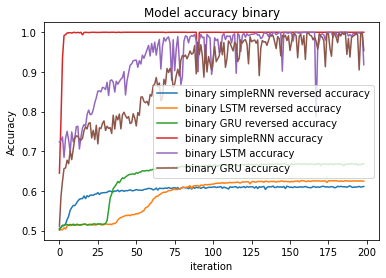

<Figure size 1440x720 with 0 Axes>

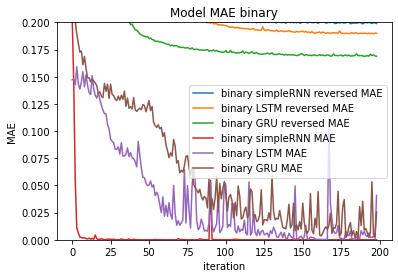

<Figure size 1440x720 with 0 Axes>

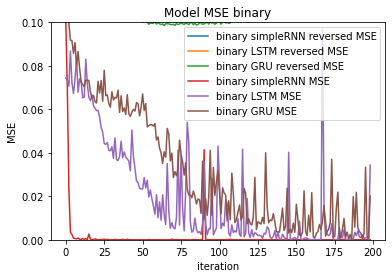

<Figure size 1440x720 with 0 Axes>

In [73]:
plt.plot(val_acc_simplernn_bit_true, label = "binary simpleRNN reversed accuracy")
plt.plot(val_acc_bit_lstm_true, label = "binary LSTM reversed accuracy")
plt.plot(val_acc_gru_bit_true, label = "binary GRU reversed accuracy")

plt.plot(val_acc_simplernn_bit_false, label = "binary simpleRNN accuracy")
plt.plot(val_acc_bit_lstm_false, label = "binary LSTM accuracy")
plt.plot(val_acc_gru_bit_false, label = "binary GRU accuracy")

plt.legend()
plt.title('Model accuracy binary')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.savefig("Model accuracy binary.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mae_simplernn_bit_true, label = "binary simpleRNN reversed MAE")
plt.plot(val_mae_bit_lstm_true, label = "binary LSTM reversed MAE")
plt.plot(val_mae_gru_bit_true, label = "binary GRU reversed MAE")

plt.plot(val_mae_simplernn_bit_false, label = "binary simpleRNN MAE")
plt.plot(val_mae_bit_lstm_false, label = "binary LSTM MAE")
plt.plot(val_mae_gru_bit_false, label = "binary GRU MAE")

plt.legend()
plt.title('Model MAE binary')
plt.ylabel('MAE')
plt.xlabel('iteration')
plt.ylim(0,.2)
plt.savefig("Model mae binary.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mse_simplernn_bit_true, label = "binary simpleRNN reversed MSE")
plt.plot(val_mse_bit_lstm_true, label = "binary LSTM reversed MSE")
plt.plot(val_mse_gru_bit_true, label = "binary GRU reversed MSE")

plt.plot(val_mse_simplernn_bit_false, label = "binary simpleRNN MSE")
plt.plot(val_mse_bit_lstm_false, label = "binary LSTM MSE")
plt.plot(val_mse_gru_bit_false, label = "binary GRU MSE")


plt.legend()
plt.title('Model MSE binary')
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.ylim(0,.1)
plt.savefig("Model mse binary.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)

Task 3 : Pair Decimal representation model reversed

In [ ]:
def strseq(str1):
    t = [pos for pos, char in enumerate(str1) if char == " "]
    tp = len([pos for pos, char in enumerate(str1) if char == " "])
    if 0 in t:
        str1_c = str1[tp:]
    if 0 not in t:
        if tp == 0:
            str1_c = str1
        if tp > 0:
            str1_c = str1[:-tp]

    posplus = [pos for pos, char in enumerate(str1_c) if char == "+"][0]
    str1_c_1 = str1_c[:posplus]
    str1_c_2 = str1_c[posplus+1:]
    while len(str1_c_1) != 3:
        str1_c_1 = ' ' + str1_c_1
    while len(str1_c_2) != 3:
        str1_c_2 = ' ' + str1_c_2
    k = str1_c_1[0] + str1_c_2[0] + str1_c_1[1] + str1_c_2[1] + str1_c_1[2] + str1_c_2[2]
    return k


# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))
        
questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = ' ' + str1
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)
        
paired_questions=[]

for i in range(0,len(questions)):
    paired_questions.append(strseq(questions[i]))
    
paired_questions1=[]
for i in range(0,len(questions1)):
    paired_questions1.append(strseq(questions1[i]))


print('Vectorization...')
x = np.zeros((len(paired_questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(paired_questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(paired_questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

x_val = np.zeros((len(paired_questions1), MAXLEN, len(chars)), dtype=np.bool)
y_val = np.zeros((len(paired_questions1), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(paired_questions1):
    x_val[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected1):
    y_val[i] = ctable.encode(sentence, DIGITS + 1)
    
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()
######simple rnn
RNN = layers.SimpleRNN
model_rnn = Sequential()

model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_rnn.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_rnn.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()


#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_gru.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    # the first dimension to be the timesteps.
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_gru.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

In [ ]:
val_acc_LSTM_digit_True_p = []
val_mae_LSTM_digit_True_p = []
val_mse_LSTM_digit_True_p = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_digit_True_p.append(model.history.history["val_accuracy"])
    val_mae_LSTM_digit_True_p.append(model.history.history["val_mae"])
    val_mse_LSTM_digit_True_p.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_true_p = (t1-t0)/200
print(timeperiteration_lstm_true_p)

simplernn true paired

In [ ]:
val_acc_simplernn_digit_True_p = []
val_mae_simplernn_digit_True_p = []
val_mse_simplernn_digit_True_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_digit_True_p.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_digit_True_p.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_digit_True_p.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_true_p = (t1-t0)/200
print(timeperiteration_simplernn_true_p)

gru true paired

In [ ]:
val_acc_gru_digit_True_p = []
val_mae_gru_digit_True_p = []
val_mse_gru_digit_True_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_True_p.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_True_p.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_True_p.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_true_p = (t1-t0)/200
print(timeperiteration_gru_true_p)

reverse = False

In [ ]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))
        
questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = ' ' + str1
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)
        
paired_questions=[]

for i in range(0,len(questions)):
    paired_questions.append(strseq(questions[i]))
    
paired_questions1=[]
for i in range(0,len(questions1)):
    paired_questions1.append(strseq(questions1[i]))


print('Vectorization...')
x = np.zeros((len(paired_questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(paired_questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(paired_questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

x_val = np.zeros((len(paired_questions1), MAXLEN, len(chars)), dtype=np.bool)
y_val = np.zeros((len(paired_questions1), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(paired_questions1):
    x_val[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected1):
    y_val[i] = ctable.encode(sentence, DIGITS + 1)
    
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()
######simple rnn
RNN = layers.SimpleRNN
model_rnn = Sequential()

model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_rnn.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_rnn.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()


#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

model_gru.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):

    # the first dimension to be the timesteps.
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))

model_gru.add(layers.TimeDistributed(layers.Dense(len(chars), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

In [ ]:
val_acc_LSTM_digit_False_p = []
val_mae_LSTM_digit_False_p = []
val_mse_LSTM_digit_False_p = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_digit_False_p.append(model.history.history["val_accuracy"])
    val_mae_LSTM_digit_False_p.append(model.history.history["val_mae"])
    val_mse_LSTM_digit_False_p.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_false_p = (t1-t0)/200
print(timeperiteration_lstm_false_p)

simple rnn false paired

In [ ]:
val_acc_simplernn_digit_false_p = []
val_mae_simplernn_digit_false_p = []
val_mse_simplernn_digit_false_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_digit_false_p.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_digit_false_p.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_digit_false_p.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_false_p = (t1-t0)/200
print(timeperiteration_simplernn_false_p)

gru false paired

In [ ]:
val_acc_gru_digit_false_p = []
val_mae_gru_digit_false_p = []
val_mse_gru_digit_false_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_false_p.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_false_p.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_false_p.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_false_p = (t1-t0)/200
print(timeperiteration_gru_false_p)

Plots task 3

In [ ]:
plt.plot(val_acc_simplernn_digit_True_p, label = "digit paired simpleRNN reversed accuracy")
plt.plot(val_acc_LSTM_digit_True_p, label = "digit paired LSTM reversed accuracy")
plt.plot(val_acc_gru_digit_True_p, label = "digit paired GRU reversed accuracy")

plt.plot(val_acc_simplernn_digit_false_p, label = "digit paired simpleRNN accuracy")
plt.plot(val_acc_LSTM_digit_False_p, label = "digit paired LSTM accuracy")
plt.plot(val_acc_gru_digit_false_p, label = "digit paired GRU accuracy")

plt.legend()
plt.title('Model accuracy digit paired')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.ylim(0,1)
plt.savefig("Model accuracy digit paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mae_simplernn_digit_True_p, label = "digit paired simpleRNN reversed MAE")
plt.plot(val_mae_LSTM_digit_True_p, label = "digit paired LSTM reversed MAE")
plt.plot(val_mae_gru_digit_True_p, label = "digit paired GRU reversed MAE")

plt.plot(val_mae_simplernn_digit_false_p, label = "digit paired simpleRNN MAE")
plt.plot(val_mae_LSTM_digit_False_p, label = "digit paired LSTM MAE")
plt.plot(val_mae_gru_digit_false_p, label = "digit paired GRU MAE")

plt.legend()
plt.title('Model MAE digit paired')
plt.ylabel('MAE')
plt.xlabel('iteration')
plt.ylim(0,.2)
plt.savefig("Model mae digit paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mse_simplernn_digit_True_p, label = "digit paired simpleRNN reversed MSE")
plt.plot(val_mse_LSTM_digit_True_p, label = "digit paired LSTM reversed MSE")
plt.plot(val_mse_gru_digit_True_p, label = "digit paired GRU reversed MSE")

plt.plot(val_mse_simplernn_digit_false_p, label = "digit paired simpleRNN MSE")
plt.plot(val_mse_LSTM_digit_False_p, label = "digit paired LSTM MSE")
plt.plot(val_mse_gru_digit_false_p, label = "digit paired GRU MSE")


plt.legend()
plt.title('Model MSE digit paired')
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.ylim(0,.1)
plt.savefig("Model mse digit paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)

task 4 reversed 

In [ ]:
def strseq_bin(str1):
    t = [pos for pos, char in enumerate(str1) if char == " "]
    tp = len([pos for pos, char in enumerate(str1) if char == " "])
    if 0 in t:
        str1_c = str1[tp:]
    if 0 not in t:
        if tp == 0:
            str1_c = str1
        if tp > 0:
            str1_c = str1[:-tp]

    posplus = [pos for pos, char in enumerate(str1_c) if char == "+"][0]
    str1_c_1 = str1_c[:posplus]
    str1_c_2 = str1_c[posplus+1:]
    k = str1_c_1[0] + str1_c_2[0]
    for i in range(1,len(str1_c_2)):
        k = k + str1_c_1[i] + str1_c_2[i] 
    return k



In [ ]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 7.
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))

questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = str1 + ' '
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Total addition questions:', len(questions))

#Convert questions to bit-notation
newquestions = []
for i in range(len(questions)):
    data = questions[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion = '+'.join(strings)
    newquestions.append(newquestion)

#Convert expected to bit-notation
newexpected = []
for i in range(len(expected)):
    newexp = [int(bit) for bit in '{:010b}'.format(int(expected[i]))]
    newexp = ''.join(map(str, newexp))
    if len(newexp) < 11:
        newexp = '0' + newexp
    newexpected.append(newexp)


#Convert questions1 to bit-notation
newquestions1 = []
for i in range(len(questions1)):
    data = questions1[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion1 = '+'.join(strings)
    newquestions1.append(newquestion1)

#Convert expected1 to bit-notation
newexpected1 = []
for i in range(len(expected1)):
    newexp1 = [int(bit) for bit in '{:010b}'.format(int(expected1[i]))]
    newexp1 = ''.join(map(str, newexp1))
    if len(newexp1) < 11:
        newexp1 = '0' + newexp1
    newexpected1.append(newexp1)

# Maximum length of input is 'binary + binary' (e.g., '0001101011+110001001'). Maximum length of 21.
# binary is DIGITS.
DIGITSBIT = 10
MAXLENBIT = DIGITSBIT + 1 + DIGITSBIT

# All the numbers, plus sign and space for padding.
charsbit = '01+ '
ctablebit = CharacterTable(charsbit)

print('Vectorization...')


newquestionsp = []
for i in range(0, len(newquestions)):
    newquestionsp.append(strseq_bin(newquestions[i]))

newquestions1p = []
for i in range(0, len(newquestions1)):
    newquestions1p.append(strseq_bin(newquestions1[i]))



x = np.zeros((len(newquestions), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestions), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestionsp):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1p):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.

indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITSBIT + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn

RNN = layers.SimpleRNN

model_rnn = Sequential()
model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_rnn.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_rnn.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()



#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_gru.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_gru.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

In [ ]:
val_acc_LSTM_bit_true_p = []
val_mae_LSTM_bit_true_p = []
val_mse_LSTM_bit_true_p = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_bit_true_p.append(model.history.history["val_accuracy"])
    val_mae_LSTM_bit_true_p.append(model.history.history["val_mae"])
    val_mse_LSTM_bit_true_p.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_bit_true_p = (t1-t0)/200
print(timeperiteration_lstm_bit_true_p)

simplernn bit true paired 

In [ ]:
val_acc_simplernn_bit_true_p = []
val_mae_simplernn_bit_true_p = []
val_mse_simplernn_bit_true_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_bit_true_p.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_bit_true_p.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_bit_true_p.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_bit_true_p = (t1-t0)/200
print(timeperiteration_simplernn_bit_true_p)

gru bit true paired 

In [ ]:
val_acc_gru_digit_bit_true_p = []
val_mae_gru_digit_bit_true_p = []
val_mse_gru_digit_bit_true_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_bit_true_p.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_bit_true_p.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_bit_true_p.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_bit_true_p = (t1-t0)/200
print(timeperiteration_gru_bit_true_p)

In [ ]:
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = False

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of 7.
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)

digit_list = []
for i in range(0,1000):
        digit_list.append(str(i))

questions1 = []
expected1 = []
for i in range(0,len(digit_list)):
    for j in range(0,len(digit_list)):
        ans = str(i + j)
        str1 = (digit_list[i] + '+' + digit_list[j])
        if REVERSE:
            str1 = str1[::-1]
        while len(str1) != 7:
            str1 = str1 + ' '
        while len(ans) != 4:
            ans = ans + ' '
        
        expected1.append(ans)
        questions1.append(str1)

print('Total addition questions:', len(questions))

newquestionsp = []
for i in range(0, len(newquestions)):
    newquestionsp.append(strseq_bin(newquestions[i]))

newquestions1p = []
for i in range(0, len(newquestions1)):
    newquestions1p.append(strseq_bin(newquestions1[i]))



x = np.zeros((len(newquestionsp), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestionsp), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestionsp):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1p), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1p), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1p):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.

#Convert questions to bit-notation
newquestions = []
for i in range(len(questions)):
    data = questions[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion = '+'.join(strings)
    newquestions.append(newquestion)

#Convert expected to bit-notation
newexpected = []
for i in range(len(expected)):
    newexp = [int(bit) for bit in '{:010b}'.format(int(expected[i]))]
    newexp = ''.join(map(str, newexp))
    if len(newexp) < 11:
        newexp = '0' + newexp
    newexpected.append(newexp)

#Convert questions1 to bit-notation
newquestions1 = []
for i in range(len(questions1)):
    data = questions1[i].split("+")
    bit_1 = [int(bit) for bit in '{:010b}'.format(int(data[0]))]
    bit_1 = ''.join(map(str, bit_1))
    bit_2 = [int(bit) for bit in '{:010b}'.format(int(data[1]))]
    bit_2 = ''.join(map(str, bit_2))
    strings = [bit_1, bit_2]
    newquestion1 = '+'.join(strings)
    newquestions1.append(newquestion1)

#Convert expected1 to bit-notation
newexpected1 = []
for i in range(len(expected1)):
    newexp1 = [int(bit) for bit in '{:010b}'.format(int(expected1[i]))]
    newexp1 = ''.join(map(str, newexp1))
    if len(newexp1) < 11:
        newexp1 = '0' + newexp1
    newexpected1.append(newexp1)

# Maximum length of input is 'binary + binary' (e.g., '0001101011+110001001'). Maximum length of 21.
# binary is DIGITS.
DIGITSBIT = 10
MAXLENBIT = DIGITSBIT + 1 + DIGITSBIT

# All the numbers, plus sign and space for padding.
charsbit = '01+ '
ctablebit = CharacterTable(charsbit)

print('Vectorization...')


newquestionsp = []
for i in range(0, len(newquestions)):
    newquestionsp.append(strseq_bin(newquestions[i]))

newquestions1p = []
for i in range(0, len(newquestions1)):
    newquestions1p.append(strseq_bin(newquestions1[i]))
    
x = np.zeros((len(newquestions), MAXLENBIT, len(charsbit)), dtype=np.bool)
y = np.zeros((len(newquestions), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestionsp):
    x[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected):
    y[i] = ctablebit.encode(sentence, DIGITSBIT + 1)

x_val = np.zeros((len(newquestions1), MAXLENBIT, len(charsbit)), dtype=np.bool)
y_val = np.zeros((len(newquestions1), DIGITSBIT + 1, len(charsbit)), dtype=np.bool)
for i, sentence in enumerate(newquestions1p):
    x_val[i] = ctablebit.encode(sentence, MAXLENBIT)
for i, sentence in enumerate(newexpected1):
    y_val[i] = ctablebit.encode(sentence, DIGITSBIT + 1)
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.




indices = np.arange(len(y))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x_val
(y_train, y_val) = y[:split_at], y_val

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITSBIT + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model.summary()

######simple rnn

RNN = layers.SimpleRNN

model_rnn = Sequential()
model_rnn.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_rnn.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_rnn.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_rnn.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_rnn.summary()



#gru
RNN = layers.GRU
model_gru = Sequential()

model_gru.add(RNN(HIDDEN_SIZE, input_shape=(MAXLENBIT, len(charsbit))))

model_gru.add(layers.RepeatVector(DIGITSBIT + 1))
for _ in range(LAYERS):
    model_gru.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
model_gru.add(layers.TimeDistributed(layers.Dense(len(charsbit), activation='softmax')))
model_gru.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'mae', 'mse'])
model_gru.summary()

In [ ]:
val_acc_LSTM_bit_False_p = []
val_mae_LSTM_bit_False_p = []
val_mse_LSTM_bit_False_p = []

# Train the model each generation and show predictions against the validation
# dataset.


t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_LSTM_bit_False_p.append(model.history.history["val_accuracy"])
    val_mae_LSTM_bit_False_p.append(model.history.history["val_mae"])
    val_mse_LSTM_bit_False_p.append(model.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_lstm_bit_False_p = (t1-t0)/200
print(timeperiteration_lstm_bit_False_p)

simple rnn bit false paired 

In [ ]:
val_acc_simplernn_bit_false_p = []
val_mae_simplernn_bit_false_p = []
val_mse_simplernn_bit_false_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_rnn.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_simplernn_bit_false_p.append(model_rnn.history.history["val_accuracy"])
    val_mae_simplernn_bit_false_p.append(model_rnn.history.history["val_mae"])
    val_mse_simplernn_bit_false_p.append(model_rnn.history.history["val_mse"])
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_rnn.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_simplernn_bit_false_p = (t1-t0)/200
print(timeperiteration_simplernn_bit_false_p)

gru bit false paired 

In [ ]:
val_acc_gru_digit_bit_false_p = []
val_mae_gru_digit_bit_false_p = []
val_mse_gru_digit_bit_false_p = []

# Train the model each generation and show predictions against the validation
# dataset.
t0 = time.time()
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model_gru.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))###
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    val_acc_gru_digit_bit_false_p.append(model_gru.history.history["val_accuracy"])##
    val_mae_gru_digit_bit_false_p.append(model_gru.history.history["val_mae"])##
    val_mse_gru_digit_bit_false_p.append(model_gru.history.history["val_mse"])##
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model_gru.predict_classes(rowx, verbose=0) ####
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if REVERSE else q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)
t1 = time.time()
timeperiteration_gru_bit_false_p = (t1-t0)/200
print(timeperiteration_gru_bit_false_p)

Task 4 plots

In [ ]:
plt.plot(val_acc_simplernn_bit_true_p, label = "binary paired simpleRNN reversed accuracy")
plt.plot(val_acc_LSTM_bit_true_p, label = "binary paired LSTM reversed accuracy")
plt.plot(val_acc_gru_digit_bit_true_p, label = "binary paired GRU reversed accuracy")

plt.plot(val_acc_simplernn_bit_false_p, label = "binary paired simpleRNN accuracy")
plt.plot(val_acc_LSTM_bit_False_p, label = "binary paired LSTM accuracy")
plt.plot(val_acc_gru_digit_bit_false_p, label = "binary paired GRU accuracy")

plt.legend()
plt.title('Model accuracy binary paired')
plt.ylabel('Accuracy')
plt.xlabel('iteration')
plt.ylim(0,1)
plt.savefig("Model accuracy binary paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mae_simplernn_bit_true_p, label = "binary paired simpleRNN reversed MAE")
plt.plot(val_mae_LSTM_bit_true_p, label = "binary paired LSTM reversed MAE")
plt.plot(val_mae_gru_digit_bit_true_p, label = "binary paired GRU reversed MAE")

plt.plot(val_mae_simplernn_bit_false_p, label = "binary paired simpleRNN MAE")
plt.plot(val_mae_LSTM_bit_False_p, label = "binary paired LSTM MAE")
plt.plot(val_mae_gru_digit_bit_false_p, label = "binary paired GRU MAE")

plt.legend()
plt.title('Model MAE binary paired')
plt.ylabel('MAE')
plt.xlabel('iteration')
plt.ylim(0,.2)
plt.savefig("Model mae binary paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)


plt.plot(val_mse_simplernn_bit_true_p, label = "binary paired simpleRNN reversed MSE")
plt.plot(val_mse_LSTM_bit_true_p, label = "binary paired LSTM reversed MSE")
plt.plot(val_mse_gru_digit_bit_true_p, label = "binary paired GRU reversed MSE")

plt.plot(val_mse_simplernn_bit_false_p, label = "binary paired simpleRNN MSE")
plt.plot(val_mse_LSTM_bit_False_p, label = "binary paired LSTM MSE")
plt.plot(val_mse_gru_digit_bit_false_p, label = "binary paired GRU MSE")


plt.legend()
plt.title('Model MSE binary paired')
plt.ylabel('MSE')
plt.xlabel('iteration')
plt.ylim(0,.1)
plt.savefig("Model mse binary paired.png")
plt.figure(figsize=(20,10)) 

plt.show(.5, 1)

Average time per iteration

In [ ]:
timeperiteration_lstm_true
timeperiteration_simplernn_true
timeperiteration_gru_true

timeperiteration_lstm_false
timeperiteration_simplernn_false
timeperiteration_gru_false

timeperiteration_lstm_true_bit
timeperiteration_simplernn_true_bit
timeperiteration_gru_true_bit

timeperiteration_lstm_false_bit
timeperiteration_simplernn_false_bit
timeperiteration_gru_false_bit

timeperiteration_lstm_true_p
timeperiteration_simplernn_true_p
timeperiteration_gru_true_p

timeperiteration_lstm_false_p
timeperiteration_simplernn_false_p
timeperiteration_gru_false_p

timeperiteration_lstm_bit_true_p
timeperiteration_simplernn_bit_true_p
timeperiteration_gru_bit_true_p

timeperiteration_lstm_bit_False_p
timeperiteration_simplernn_bit_false_p
timeperiteration_gru_bit_false_p
